# VaR and CVaR calculation

## Introduction

### Value-at-Risk (VaR)

Given a confidence level ⍺ (e.g. 5%), the VaR (100-⍺)% (e.g. VaR 95%) of a financial portfolio or instrument is the upper limit (or cut-off point) of their expected returns in the ⍺% percentile of their return distribution over a specific timeframe (a 1-year period is often standard).

### Expected Shortfall (CVaR)

Also called conditional VaR (CVaR), ES represents the expected loss when it is greater than the calculated VaR value (a cut-off point), given the confidence level ⍺.

## Extracting Stock Data

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from scipy.stats import norm

In [2]:
pandas_type = "pandas.core.frame.DataFrame"

As the data is ectracted by 'stock = stock[-260:]' which is an index way, so the data is 260 days before running time

In [22]:
def download_stock_data(ticker: str) -> (str, pandas_type):
    """
    Downloads and reshapes stock data based on the yfinance library.
    """
    stock_data = yf.download(ticker)
    columns_to_remove = [col for col in stock_data.columns if col != "Adj Close"] #lists all column not 'Adj Close'
    stock = stock_data.drop(columns = columns_to_remove)
    stock = stock[-260:] #260 is the expected number of business days in 1 year (conventional time frame to compute VaR)
    return ticker, stock

In [23]:
def calculate_stock_return(ticker: str, stock: pandas_type) -> (str, pandas_type):
    """
    Calculates daily returns over the chosen timeframe.
    Plots stock returns.
    """
    stock = stock[1:].values / stock[:-1] - 1 #computes stock returns
    stock.dropna() #drops all NAs
    
    #plots
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    ax.plot(stock, linewidth = 2)
    ax.set_xlabel('Time', fontsize=18)
    ax.set_ylabel('% Return', fontsize=18)
    ax.set_title("Return Time Series", size=25, weight = "bold")
    ax.grid(linestyle='-', linewidth='0.5', color='red')
    
    return ticker, stock

In [24]:
def standard_deviation(stock: pandas_type) -> pandas_type:
    """
    Calculates standard deviation of stock over the chosen timeframe.
    """
    mean = stock.mean()
    stock = (stock - mean)**2
    
    return math.sqrt(stock.mean())

In [25]:
def show_distribution(ticker: str, stock: pandas_type) -> None:
    """
    Plots the distribution of returns of the stock over the chosen timeframe.
    """
    normal_dist = np.random.normal(0, standard_deviation(stock), len(stock))
    
    #plots
    fig = plt.figure(figsize=(20,10))
    fig = plt.hist(normal_dist, bins=30, density=True, alpha=0.5,
                   histtype='stepfilled', color='red', edgecolor = 'gray', 
                   label = "Normal Distribution")
    fig = plt.hist(stock.transpose().values[0], bins=30, density=True, alpha=0.5,
                   histtype='stepfilled', color='steelblue', edgecolor = 'gray', 
                   label = ticker + " Return")
    fig = plt.xlabel('% Return', fontsize=18)
    fig = plt.ylabel('Nb of Times', fontsize=18)
    fig = plt.title('Return Distribution', fontsize=25, weight = "bold")
    fig = plt.legend(fontsize=18)
    
    return None

## Calculating VaR 

In [26]:
def value_at_risk(alpha: float, ticker: str, stock: pandas_type, quantile: bool = True) -> float:
    """
    Calculates value-at-risk over the chosen timeframe.
    """
    ticker_value = yf.Ticker(ticker)
    value = ticker_value.info["bid"]
    
    if quantile == True:
        
        percentage = stock.quantile(alpha)
        value *= percentage[0]
        value = np.around(value, 2)
        percentage = round(percentage[0] * 100, 2)
        print(f"Based on quantile:\n The value-at-risk of one stock of company " + 
              f"{ticker} is {value} in {ticker_value.info['currency']} " +
              f"or {percentage}% of current value ${ticker_value.info['bid']} (as at today).")
        
        return stock.quantile(alpha)
    
    else:
        
        alpha = norm.ppf(1 - alpha, stock.mean(), standard_deviation(stock))
        value -= value * (alpha + 1)
        value = np.around(value, 2)
        alpha = np.around(alpha * 100, 2)
        print(f"Based on normal distribution:\n The value-at-risk of one stock of company " + 
              f"{ticker} is {value[0]} in {ticker_value.info['currency']} " +
              f"or -{alpha[0]}% of current value ${ticker_value.info['bid']} (as at today).")
        
        return value

## Calculating CVaR 

In [27]:
def expected_shortfall(alpha: float, ticker: str, stock: pandas_type, quantile: bool = True) -> float:
    """
    Calculates expected shortfall over the chosen timeframe.
    """
    ticker_value = yf.Ticker(ticker)
    value = ticker_value.info["bid"]
    percentage = value_at_risk(alpha, ticker, stock, quantile)
    
    if quantile == True:
        
        stock = stock[stock <= percentage]
        value *= stock.mean()
        print(f"Based on quantile:\n The expected shortfall of one stock of company " + 
              f"{ticker} is {round(value[0],2)} in {ticker_value.info['currency']} " +
              f"or {round(stock.mean()[0]*100,2)}% of current value ${ticker_value.info['bid']} (as at today).")
        
        return stock.mean()
    
    else:
        
        percentage = norm.ppf(1 - alpha, stock.mean(), standard_deviation(stock))
        stock = stock[stock <= -percentage]
        percentabge = (value * stock.mean())/ value
        value *= stock.mean()
        value = np.around(value, 2)
        percentage = np.around(percentage * 100, 2)
        
        print(f"Based on normal distribution:\n The expected shortfall of one stock of company " + 
              f"{ticker} is {value[0]} in {ticker_value.info['currency']} " +
              f"or {percentage[0]}% of current value ${ticker_value.info['bid']} (as at today).")
        return value

## Calculation for 20 stocks

[*********************100%***********************]  1 of 1 completed
Based on quantile:
 The value-at-risk of one stock of company HMSO.L is -1.14 in GBp or -4.33% of current value $26.26 (as at today).
Based on quantile:
 The expected shortfall of one stock of company HMSO.L is -1.7 in GBp or -6.47% of current value $26.26 (as at today).
Based on normal distribution:
 The value-at-risk of one stock of company HMSO.L is -1.2 in GBp or -4.56% of current value $26.26 (as at today).
Based on normal distribution:
 The expected shortfall of one stock of company HMSO.L is -1.7 in GBp or 4.56% of current value $26.26 (as at today).
Based on quantile:
 The value-at-risk of one stock of company HMSO.L is -2.07 in GBp or -7.88% of current value $26.26 (as at today).
Based on quantile:
 The expected shortfall of one stock of company HMSO.L is -2.33 in GBp or -8.86% of current value $26.26 (as at today).
Based on normal distribution:
 The value-at-risk of one stock of company HMSO.L is -1.71 in GB

[*********************100%***********************]  1 of 1 completed
Based on quantile:
 The value-at-risk of one stock of company NG.L is -20.72 in GBp or -1.82% of current value $1138 (as at today).
Based on quantile:
 The expected shortfall of one stock of company NG.L is -113.98 in GBp or -10.02% of current value $1138 (as at today).
Based on normal distribution:
 The value-at-risk of one stock of company NG.L is -12032.34 in GBp or -1055.47% of current value $1140 (as at today).
Based on normal distribution:
 The expected shortfall of one stock of company NG.L is nan in GBp or 1055.47% of current value $1140 (as at today).
Based on quantile:
 The value-at-risk of one stock of company NG.L is -36.63 in GBp or -3.21% of current value $1140 (as at today).
Based on quantile:
 The expected shortfall of one stock of company NG.L is -405.07 in GBp or -35.53% of current value $1140 (as at today).
Based on normal distribution:
 The value-at-risk of one stock of company NG.L is -16837.05 in

[*********************100%***********************]  1 of 1 completed
Based on quantile:
 The value-at-risk of one stock of company TLW.L is -2.67 in GBp or -5.06% of current value $52.7 (as at today).
Based on quantile:
 The expected shortfall of one stock of company TLW.L is -4.23 in GBp or -8.03% of current value $52.7 (as at today).
Based on normal distribution:
 The value-at-risk of one stock of company TLW.L is -3.05 in GBp or -5.79% of current value $52.7 (as at today).
Based on normal distribution:
 The expected shortfall of one stock of company TLW.L is -4.47 in GBp or 5.79% of current value $52.7 (as at today).
Based on quantile:
 The value-at-risk of one stock of company TLW.L is -4.48 in GBp or -8.5% of current value $52.7 (as at today).
Based on quantile:
 The expected shortfall of one stock of company TLW.L is -6.57 in GBp or -12.46% of current value $52.7 (as at today).
Based on normal distribution:
 The value-at-risk of one stock of company TLW.L is -4.29 in GBp or -8.15

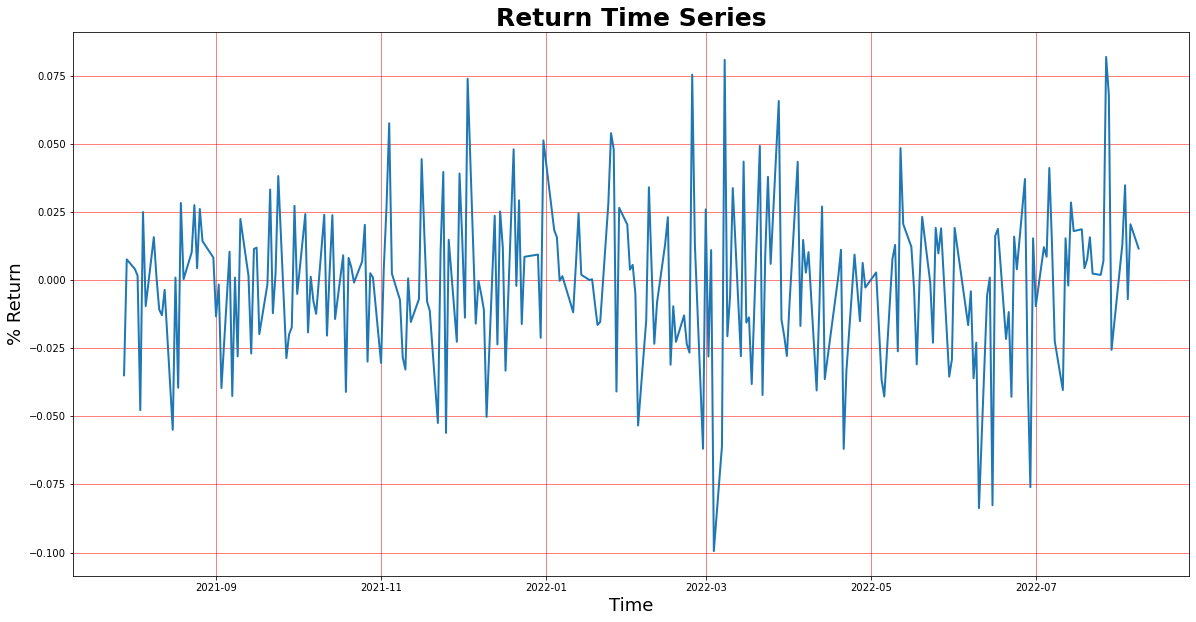

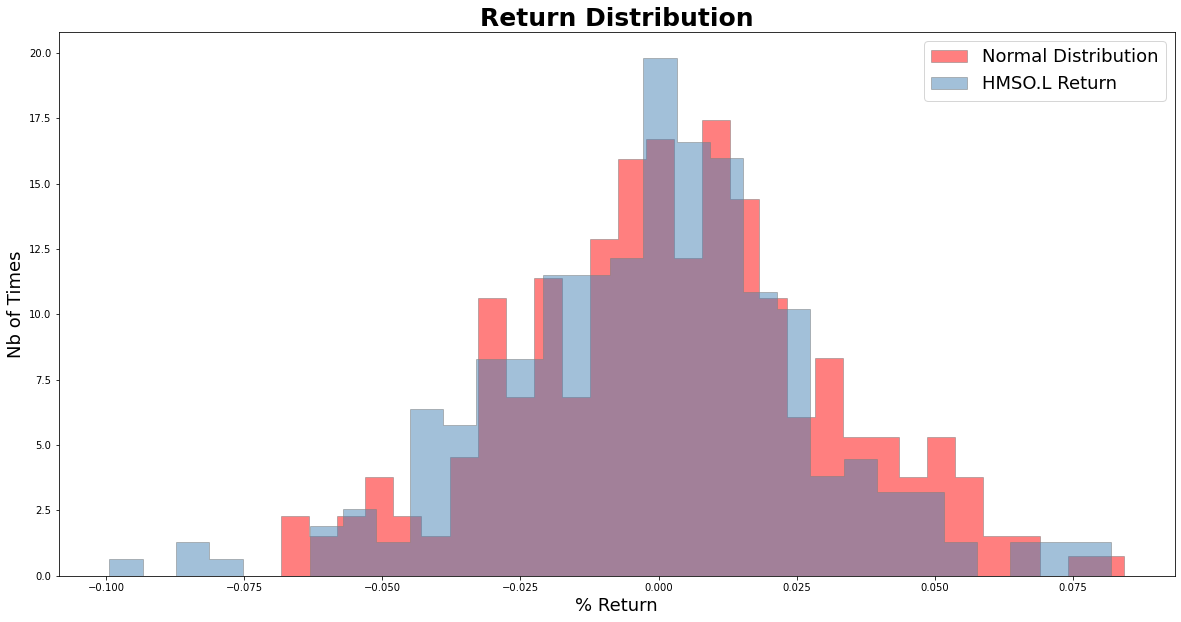

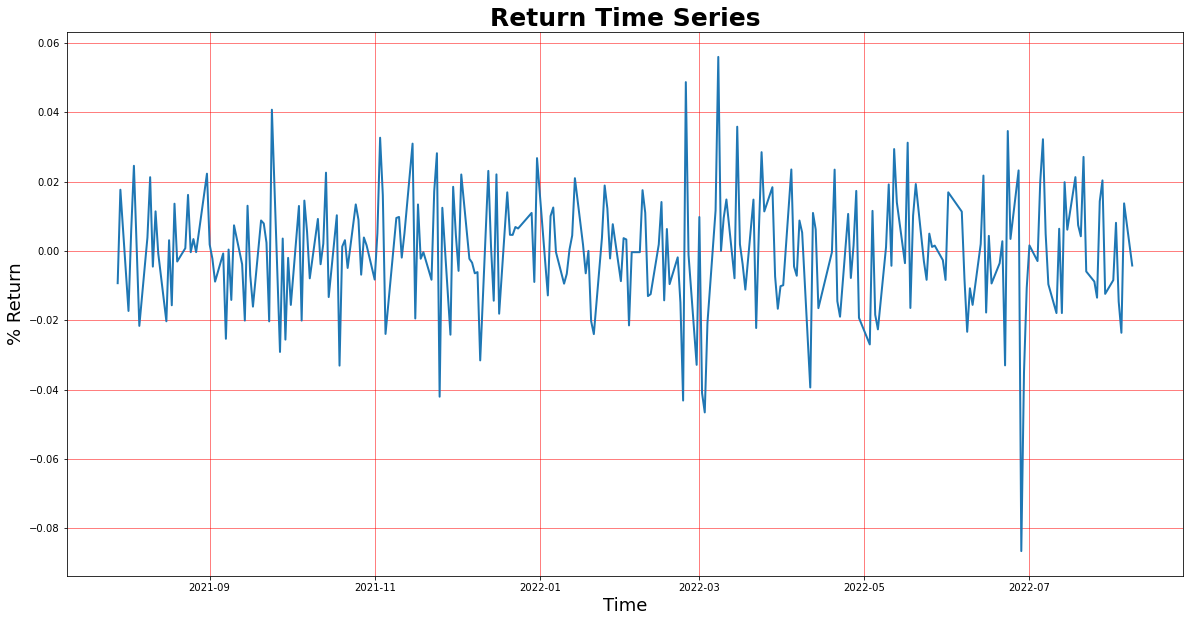

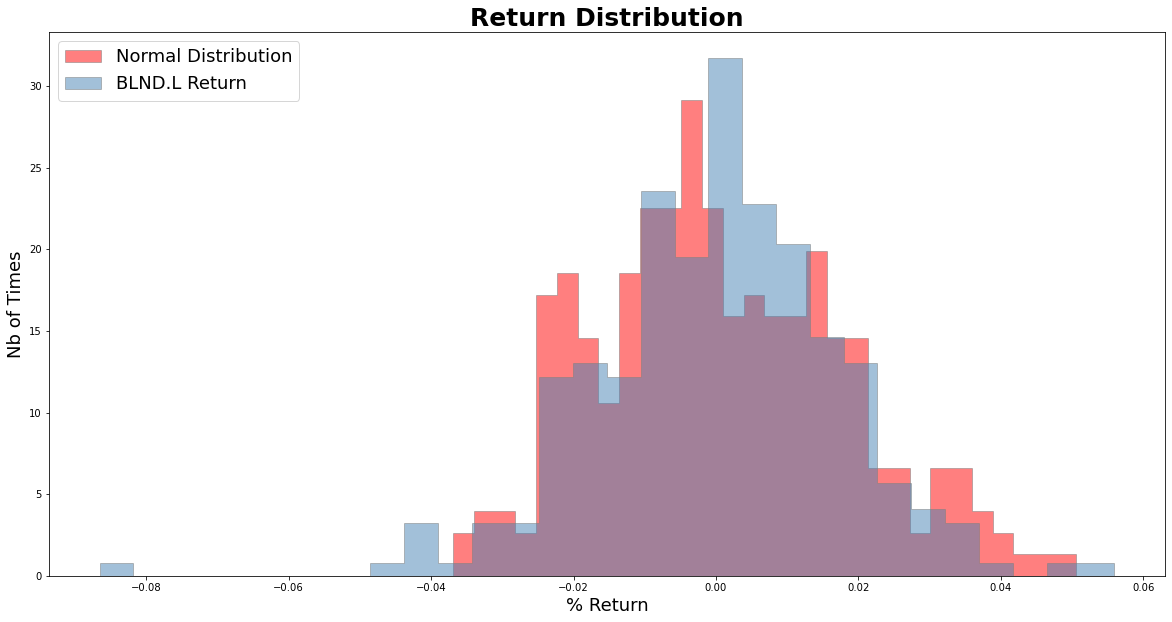

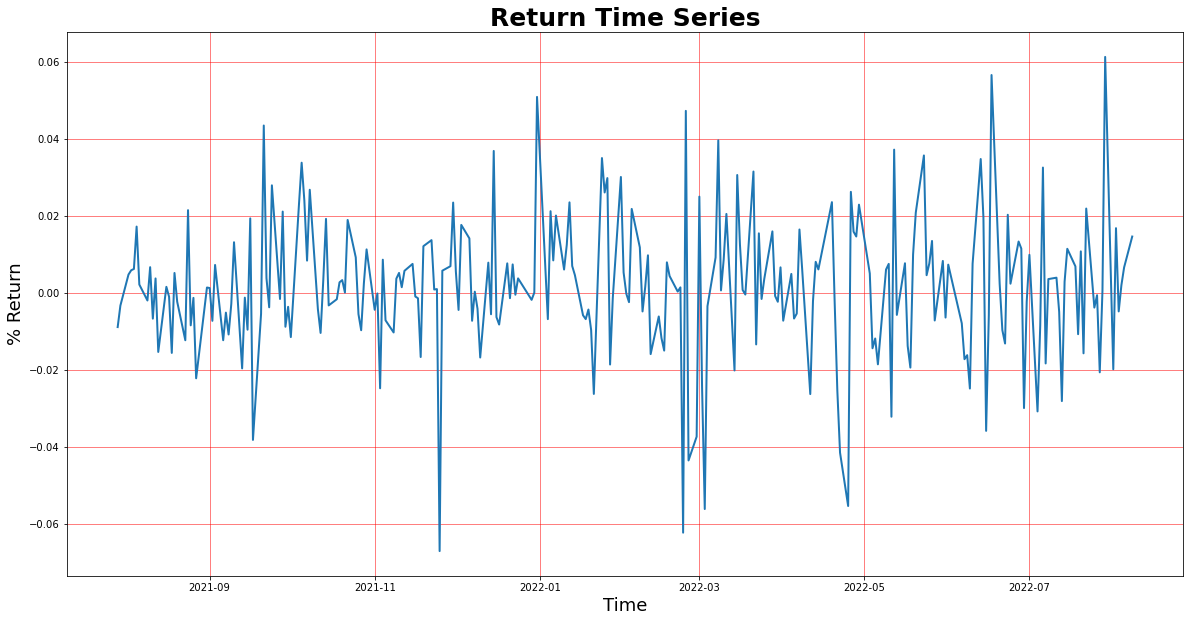

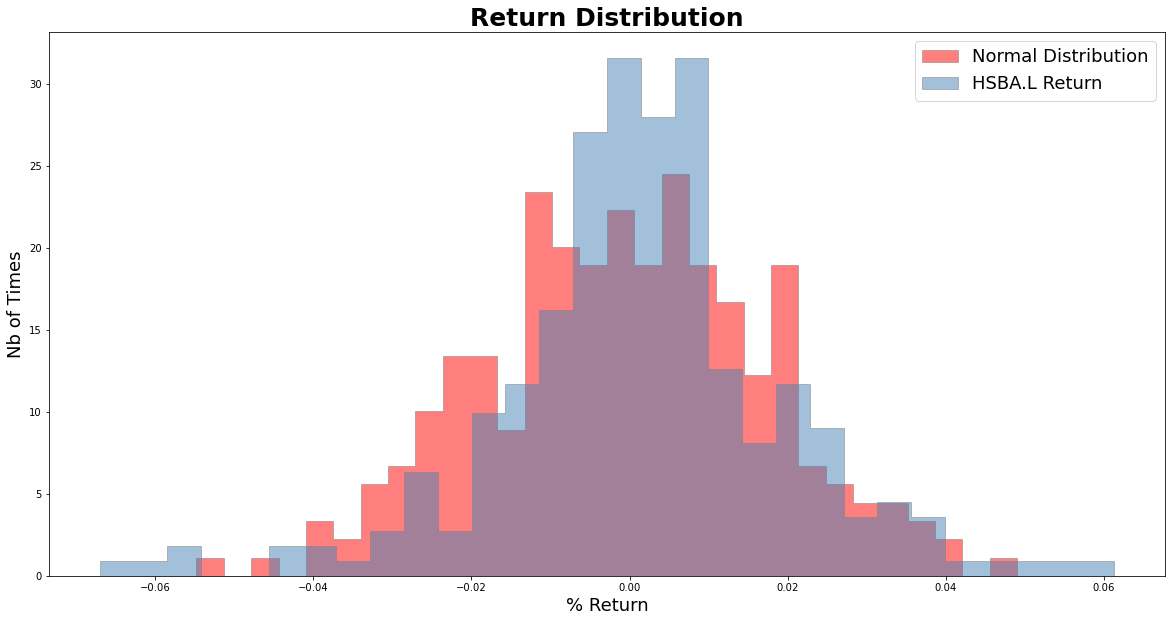

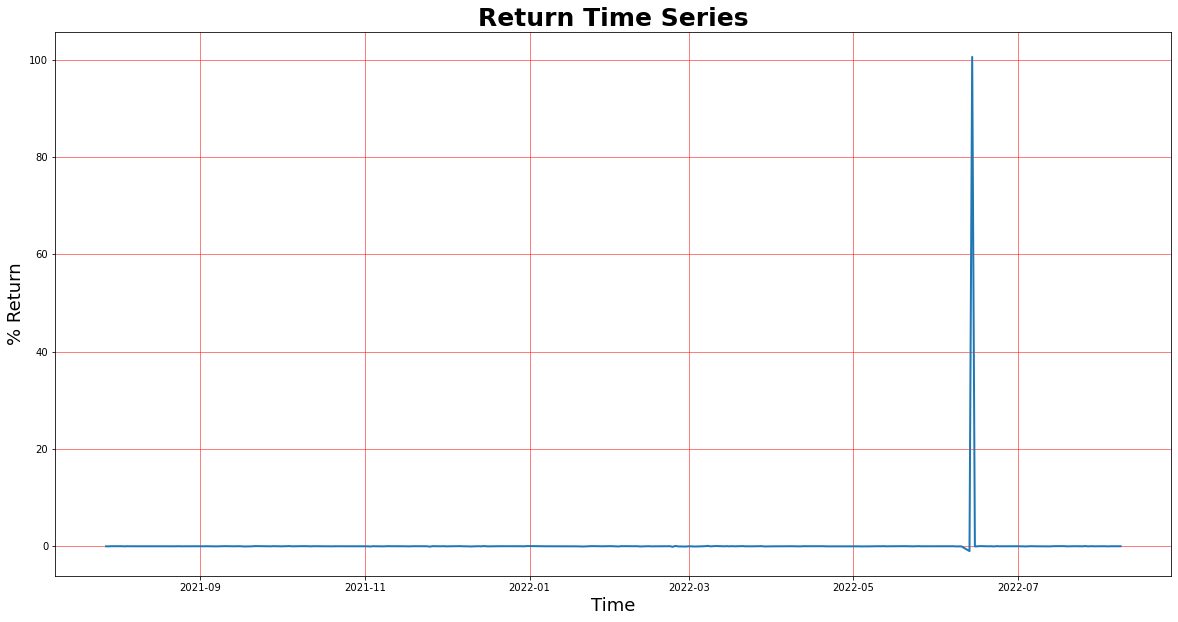

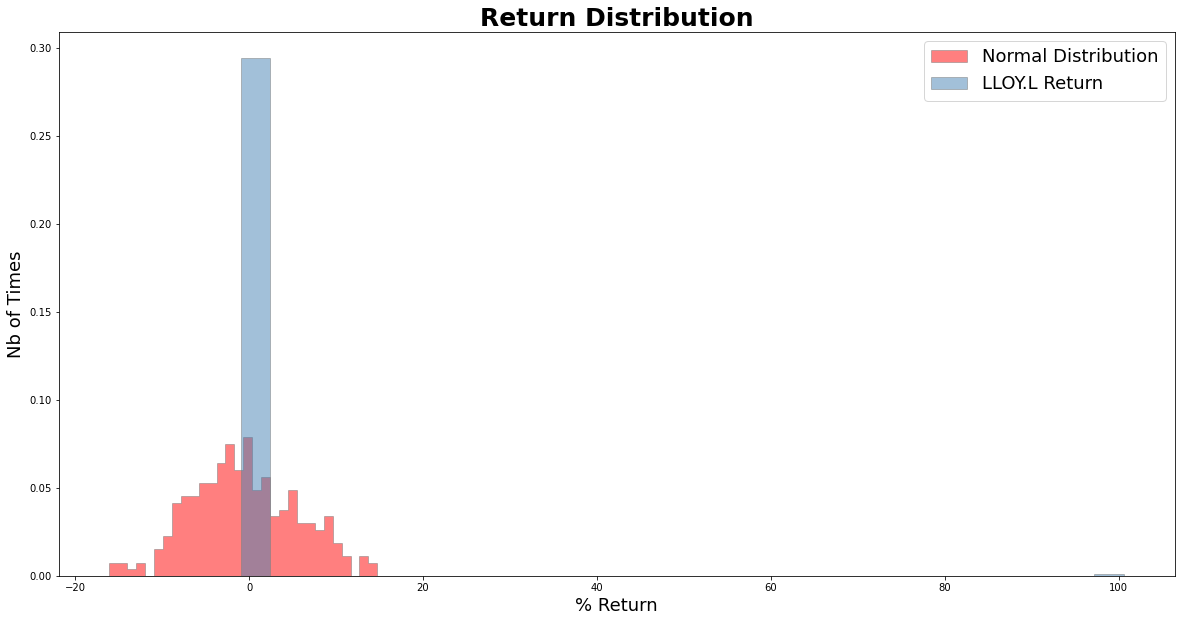

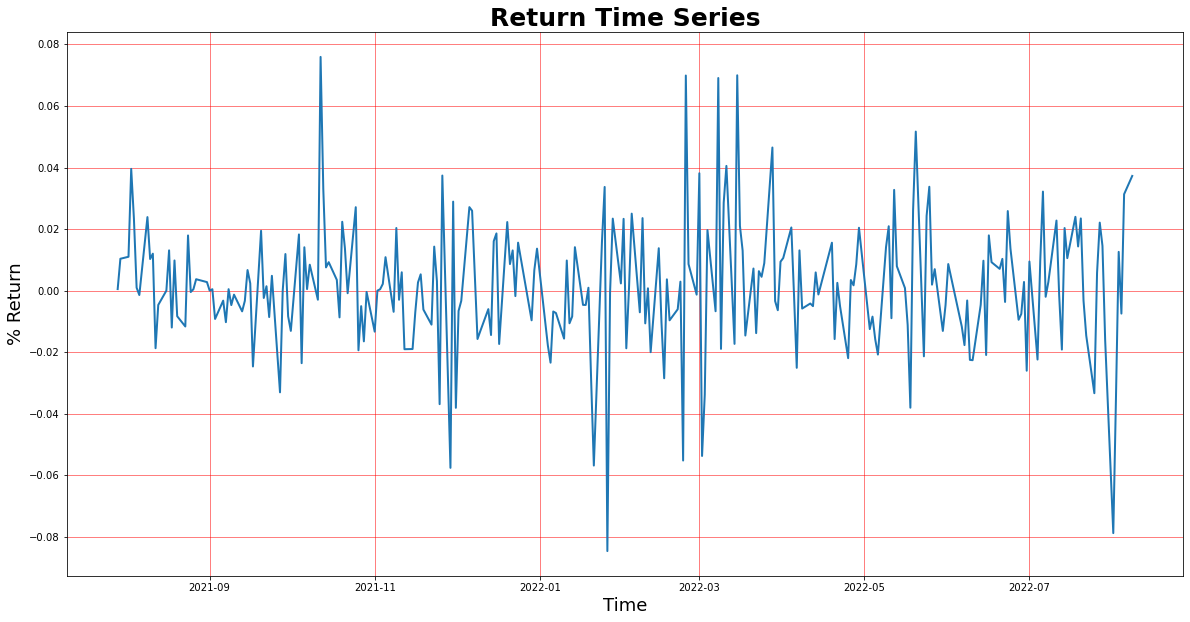

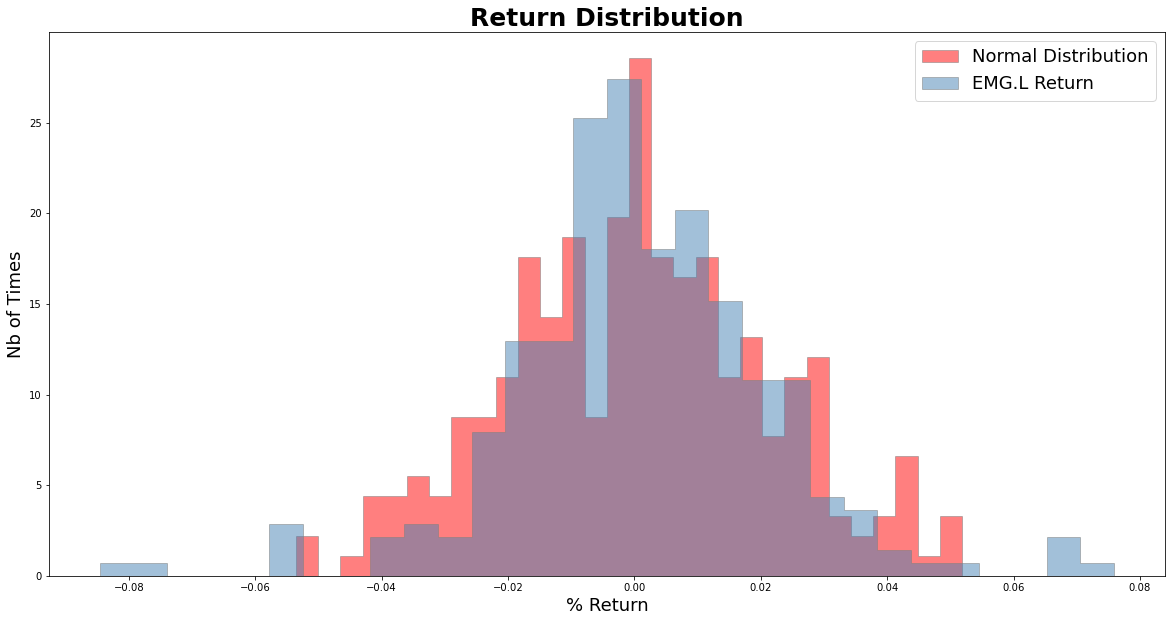

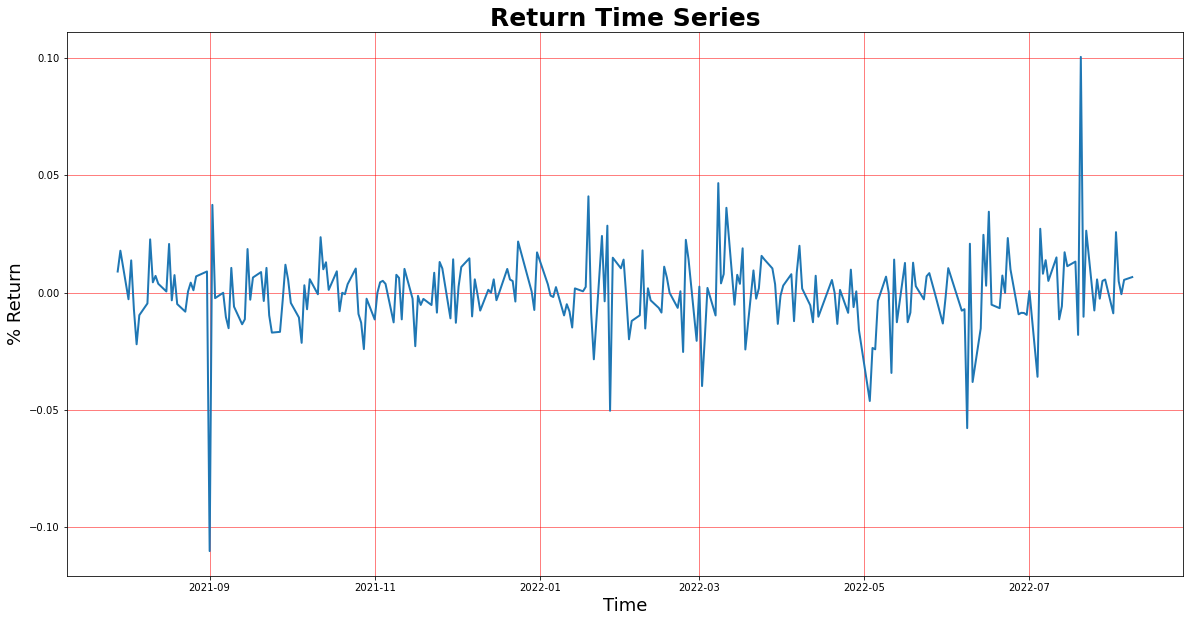

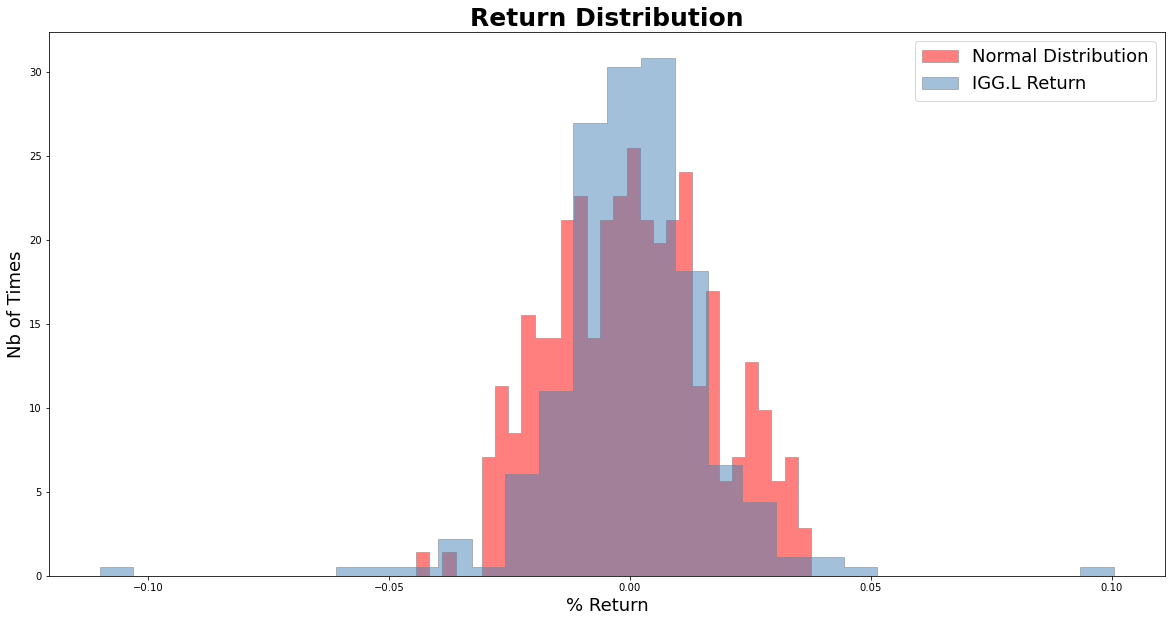

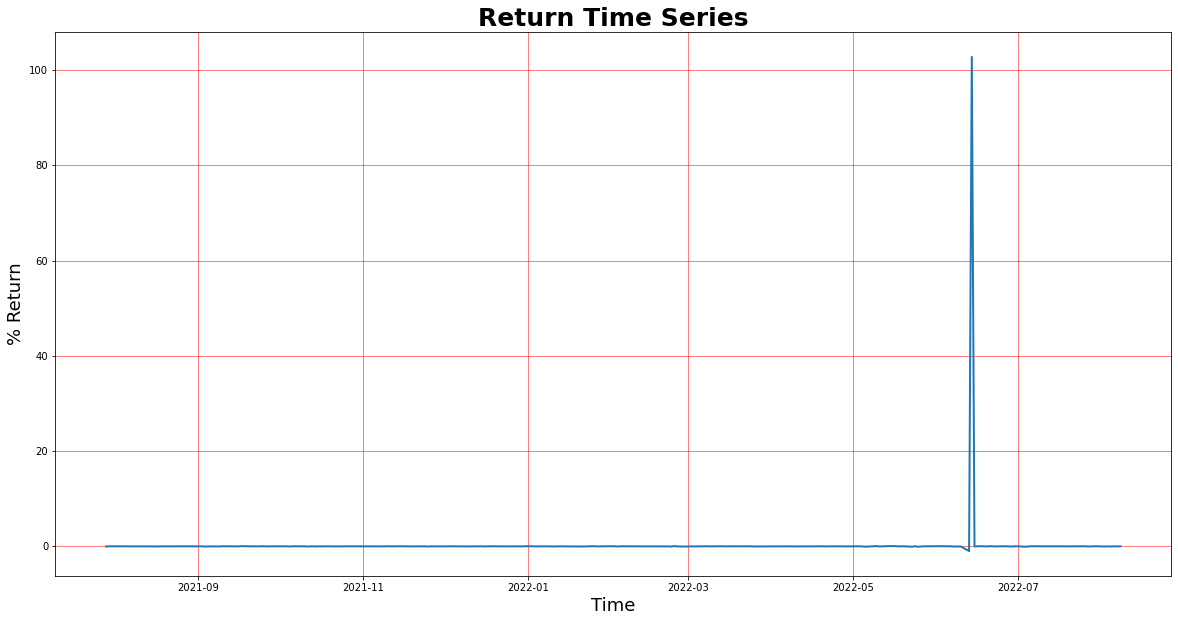

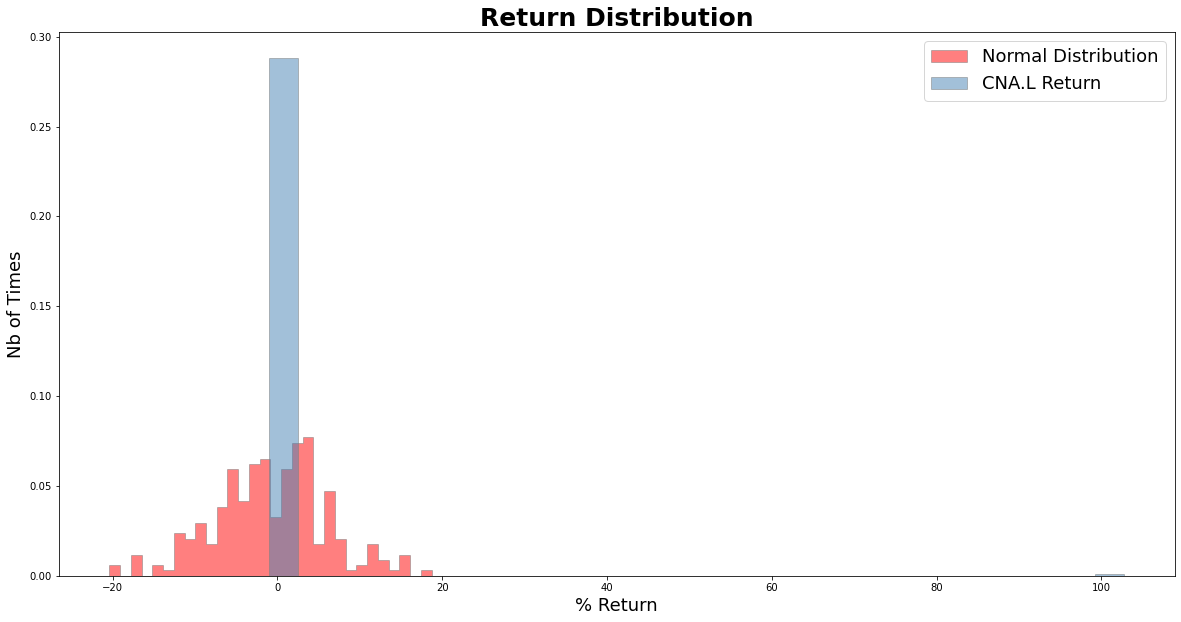

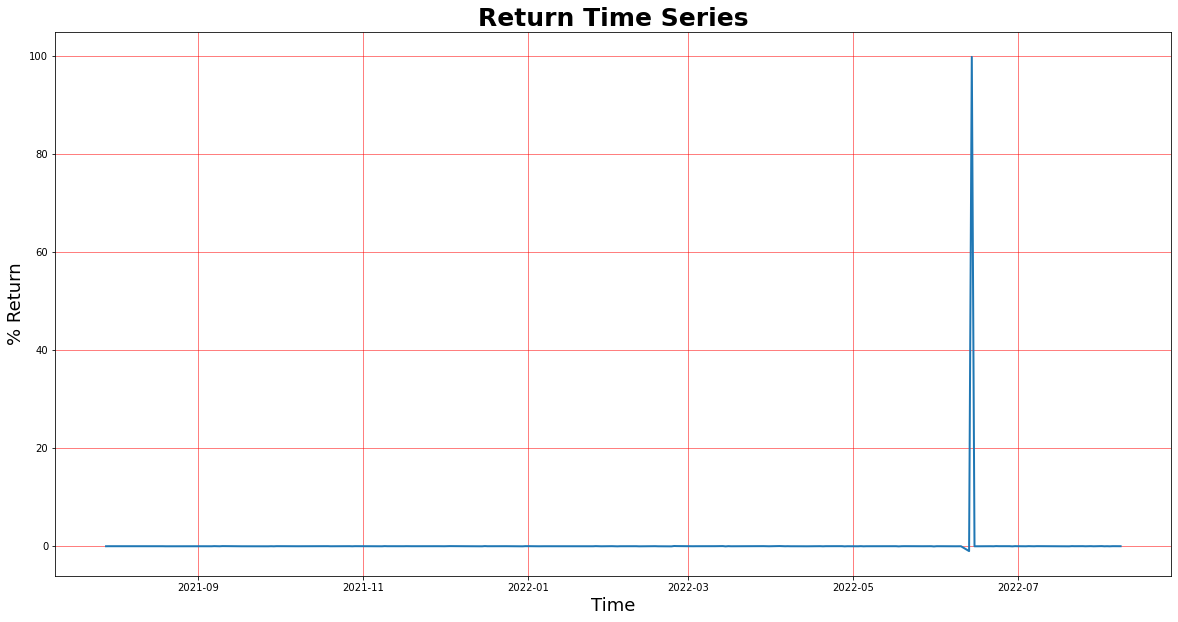

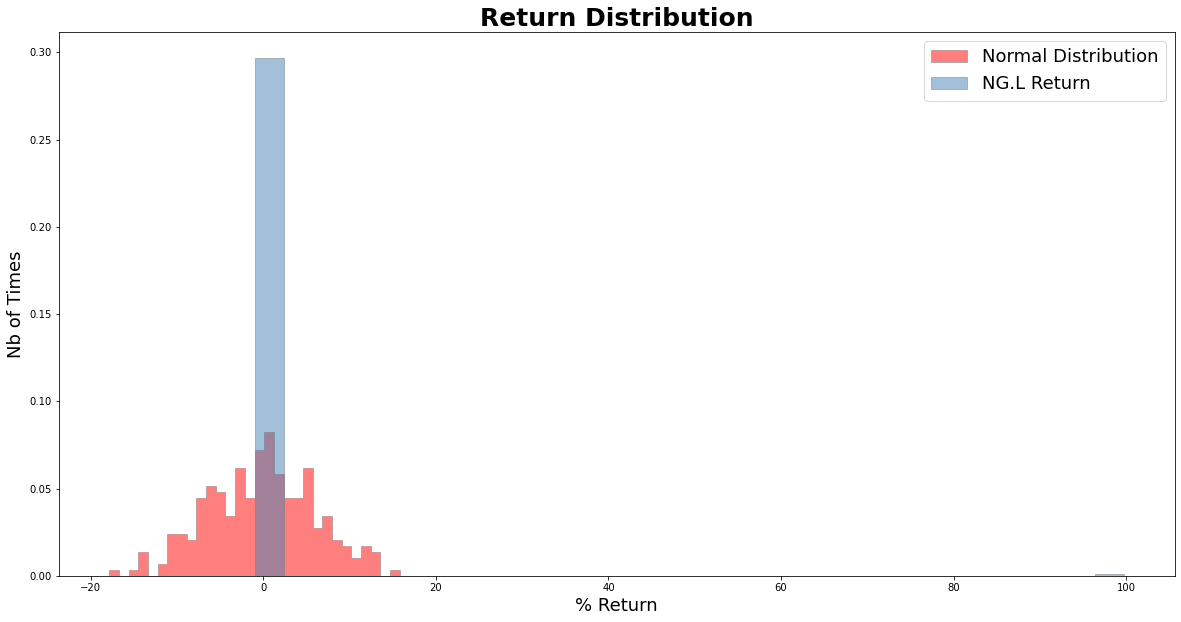

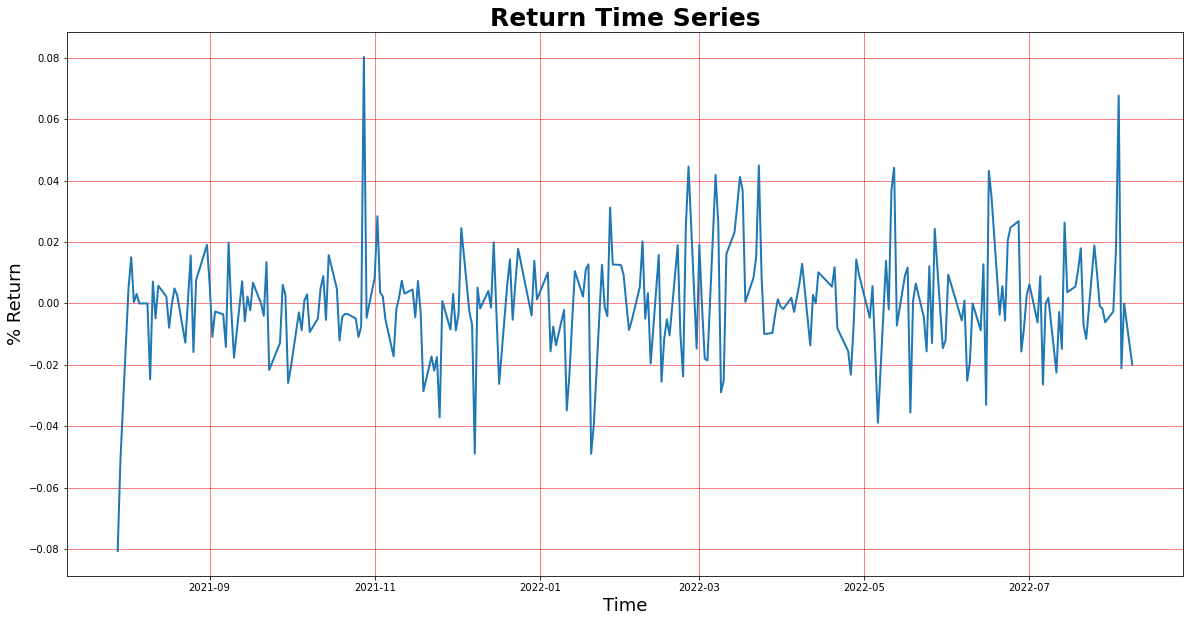

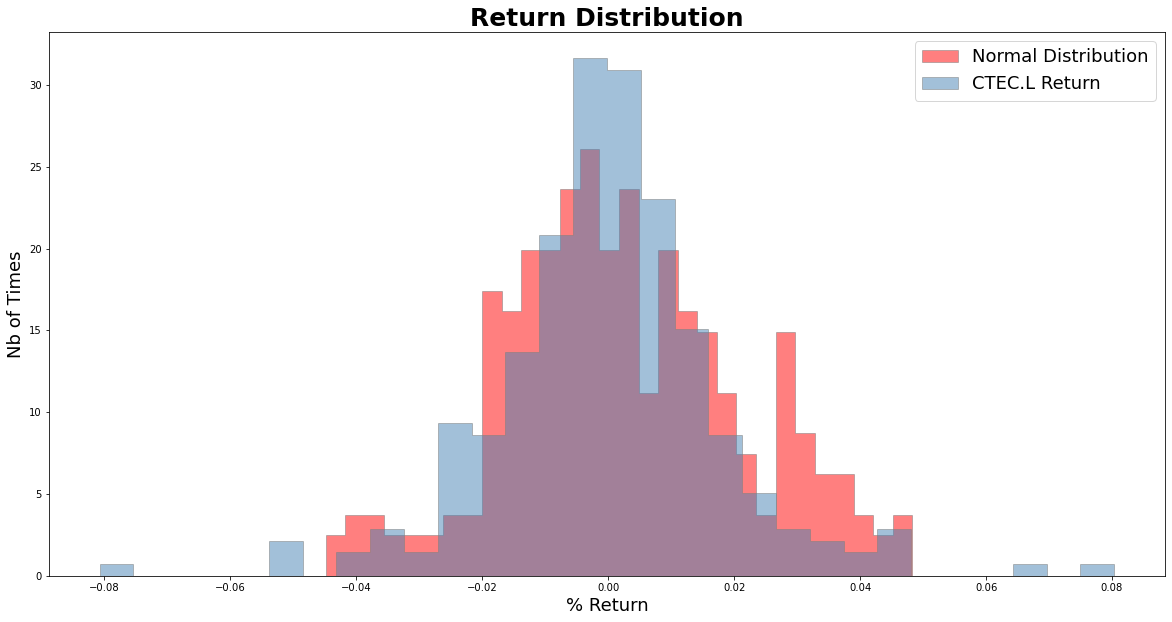

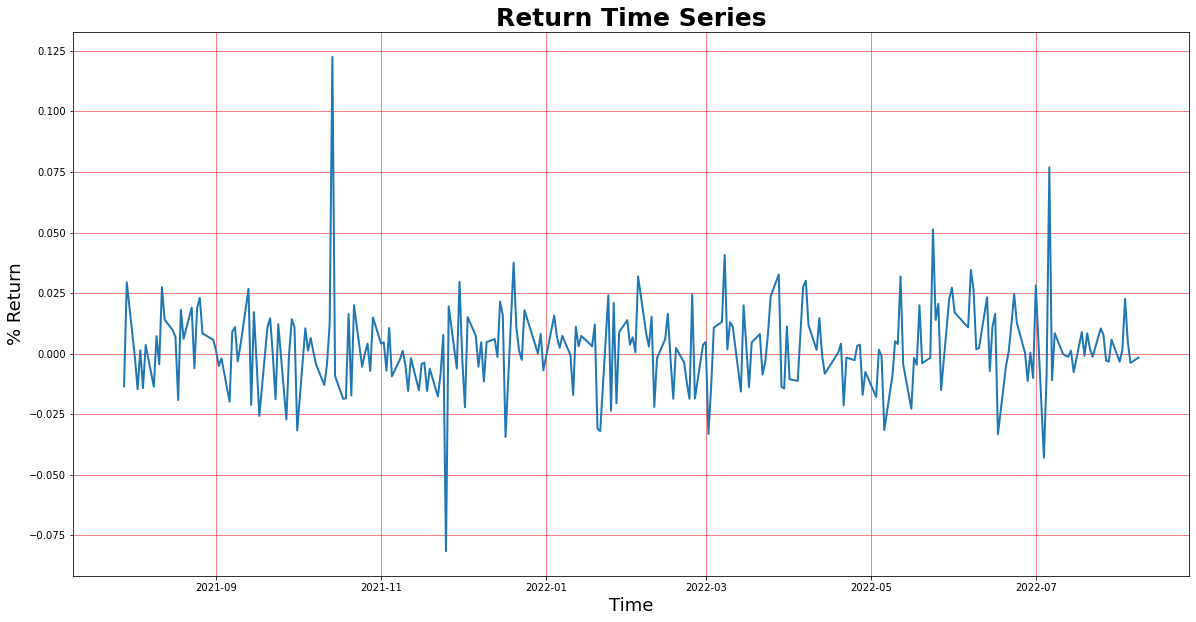

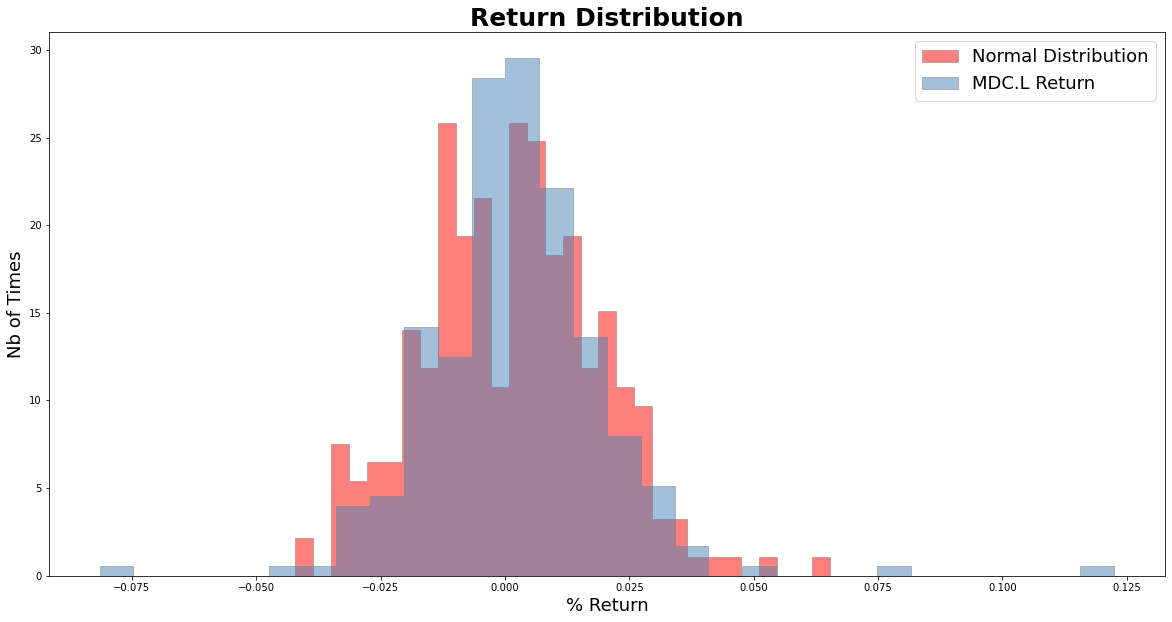

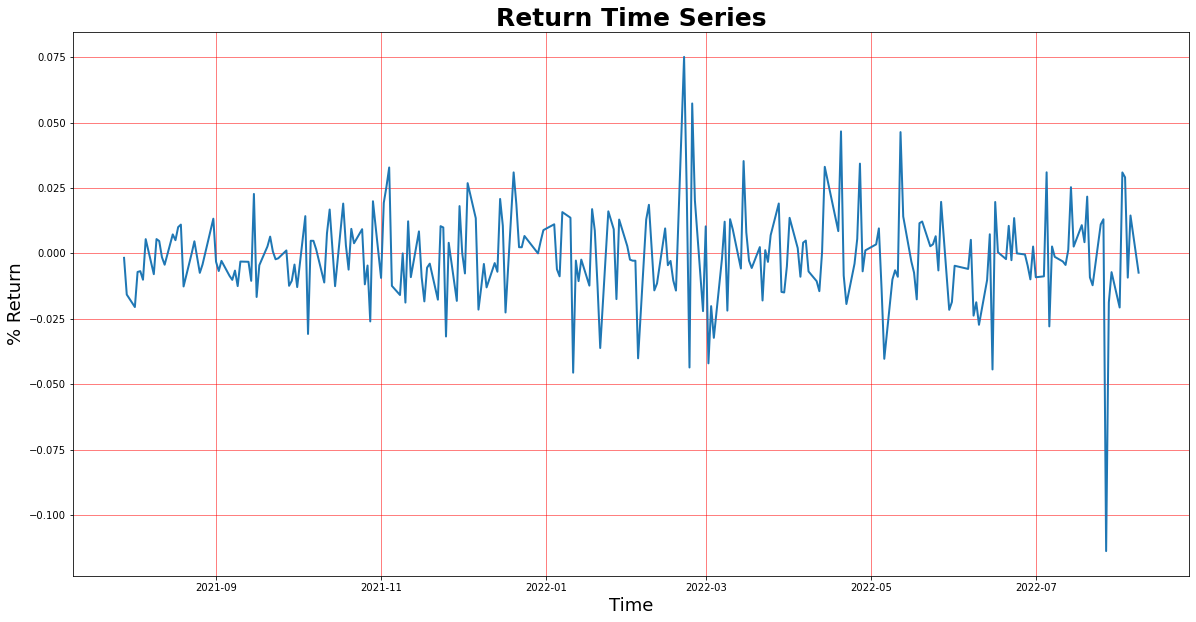

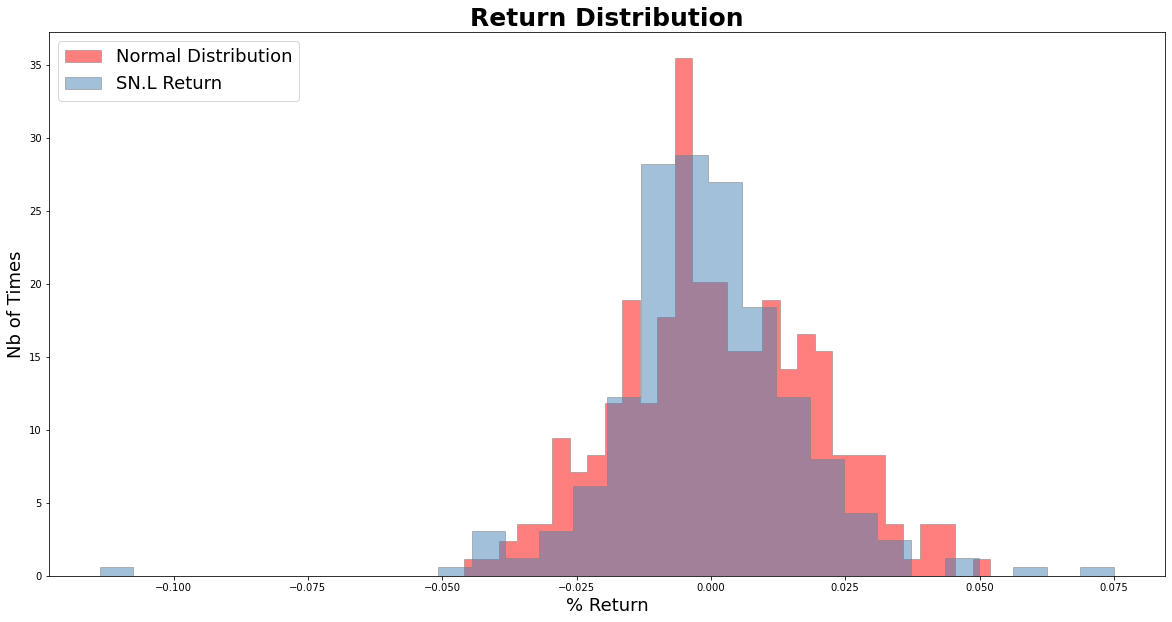

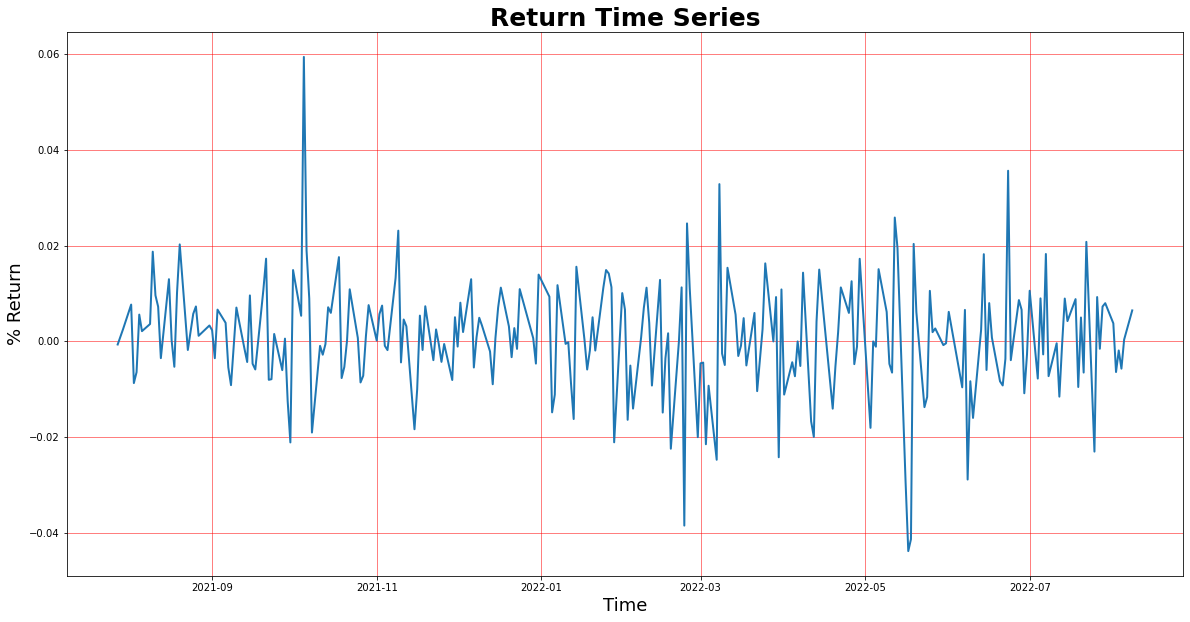

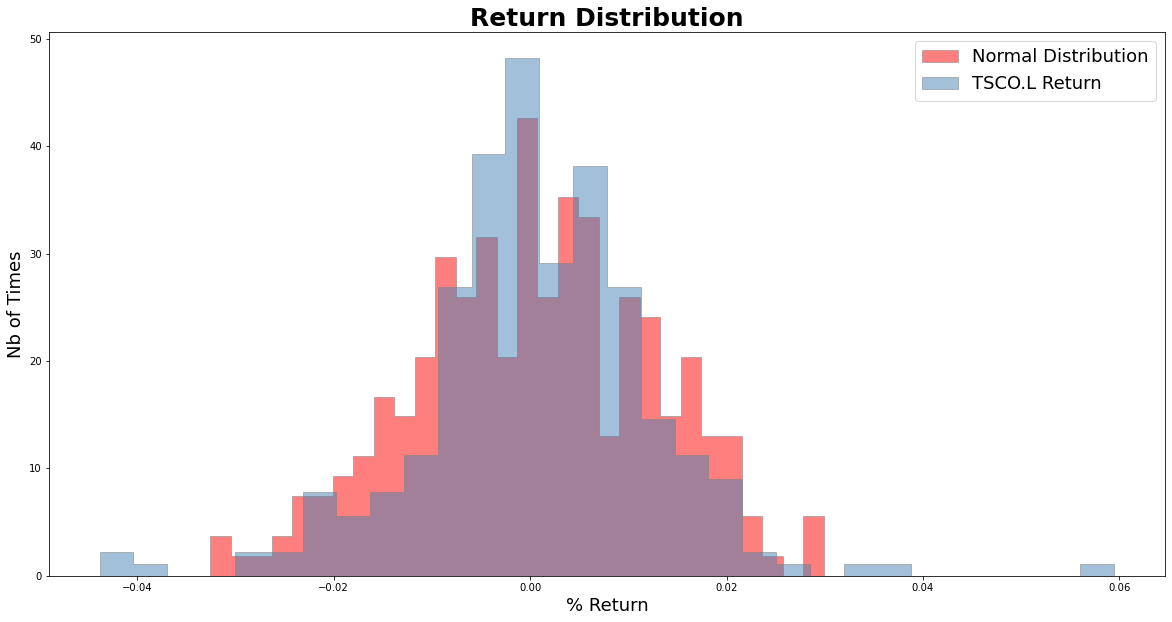

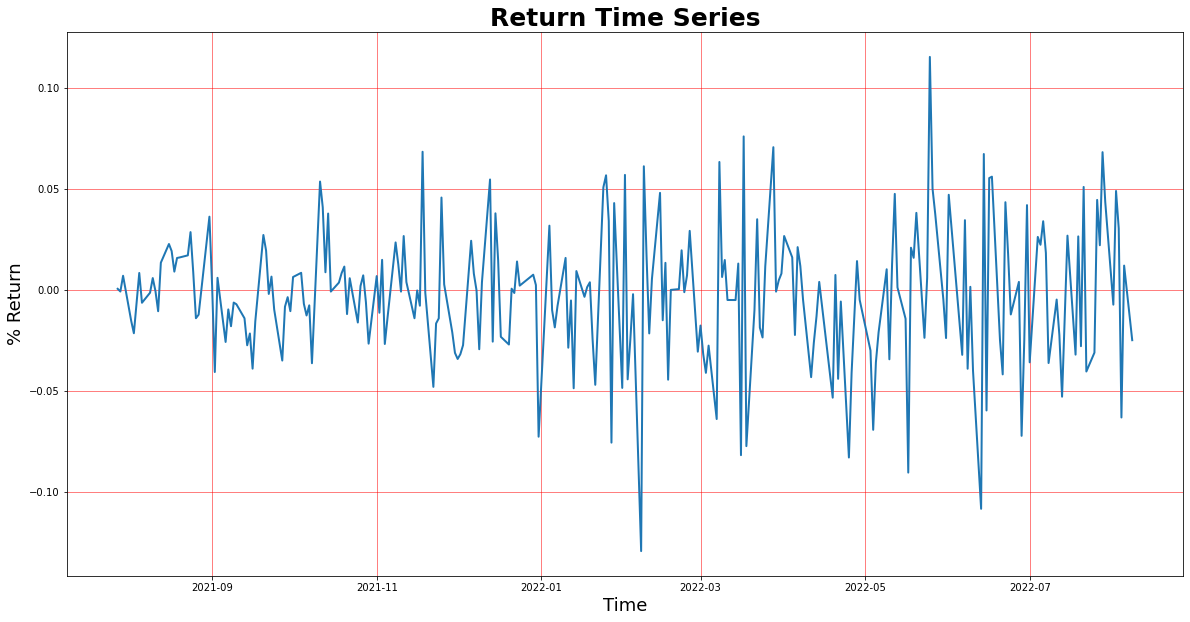

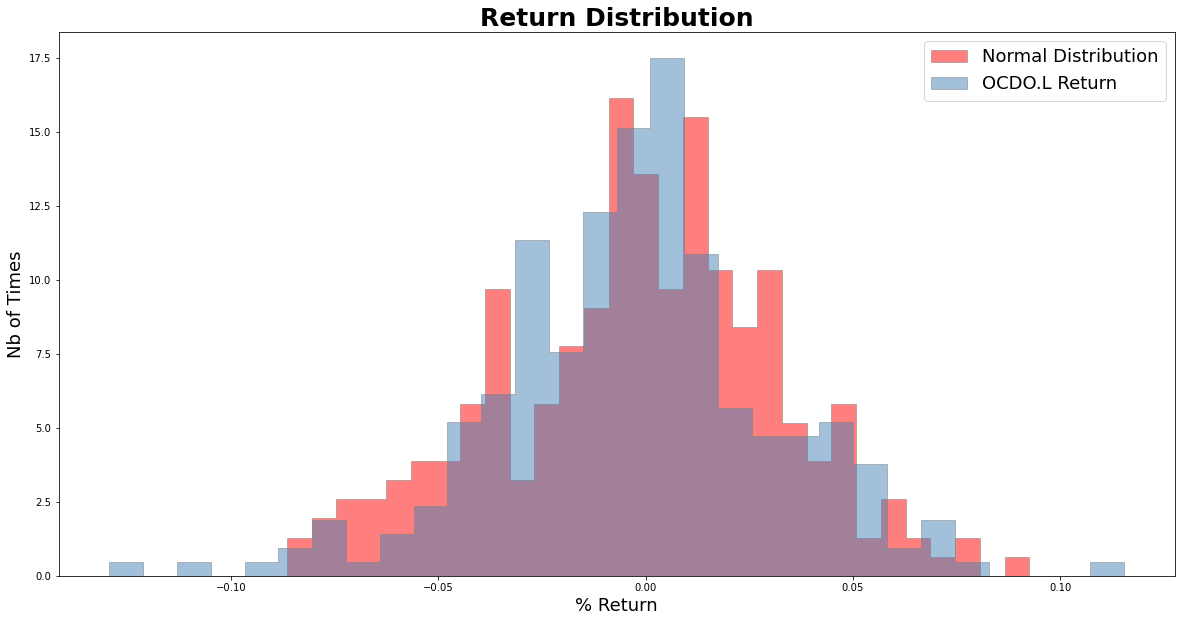

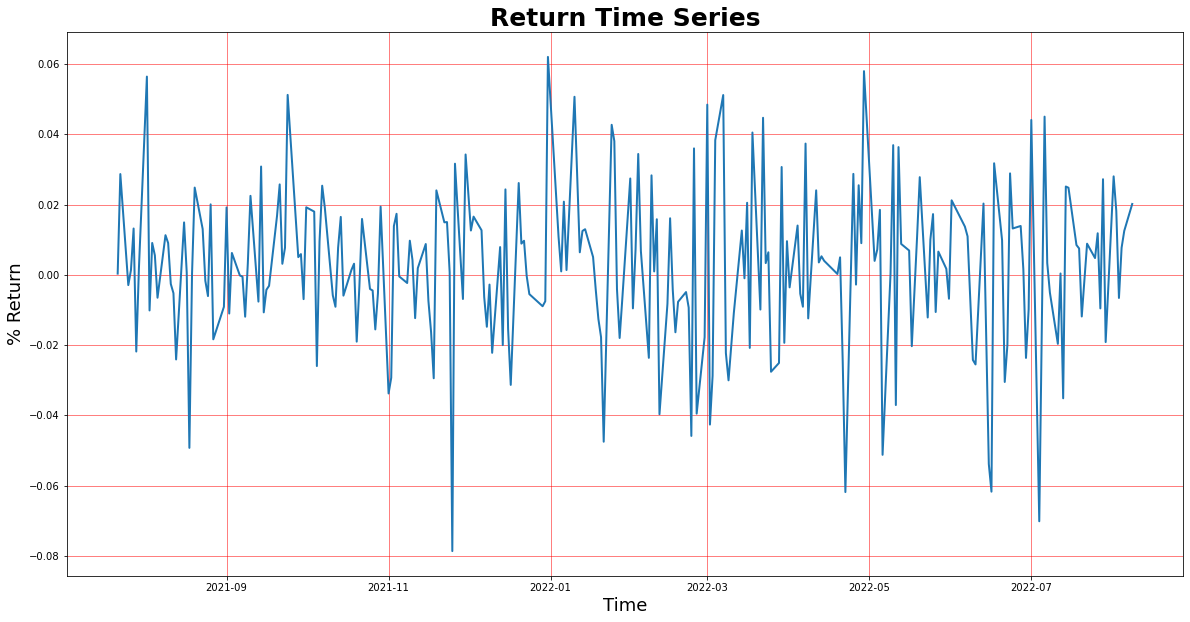

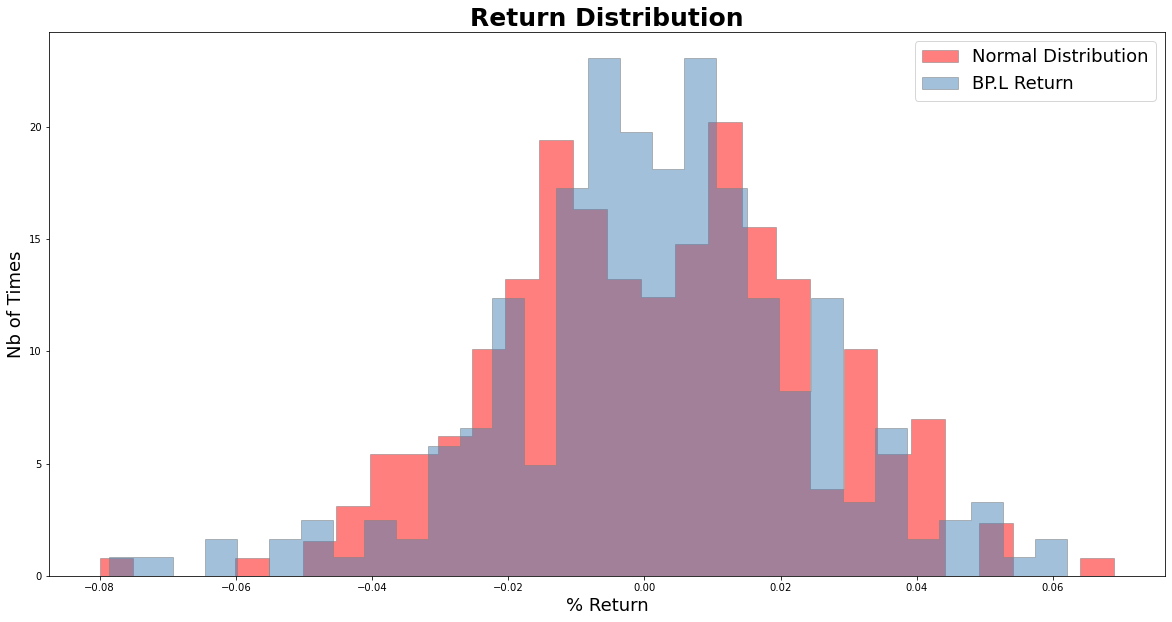

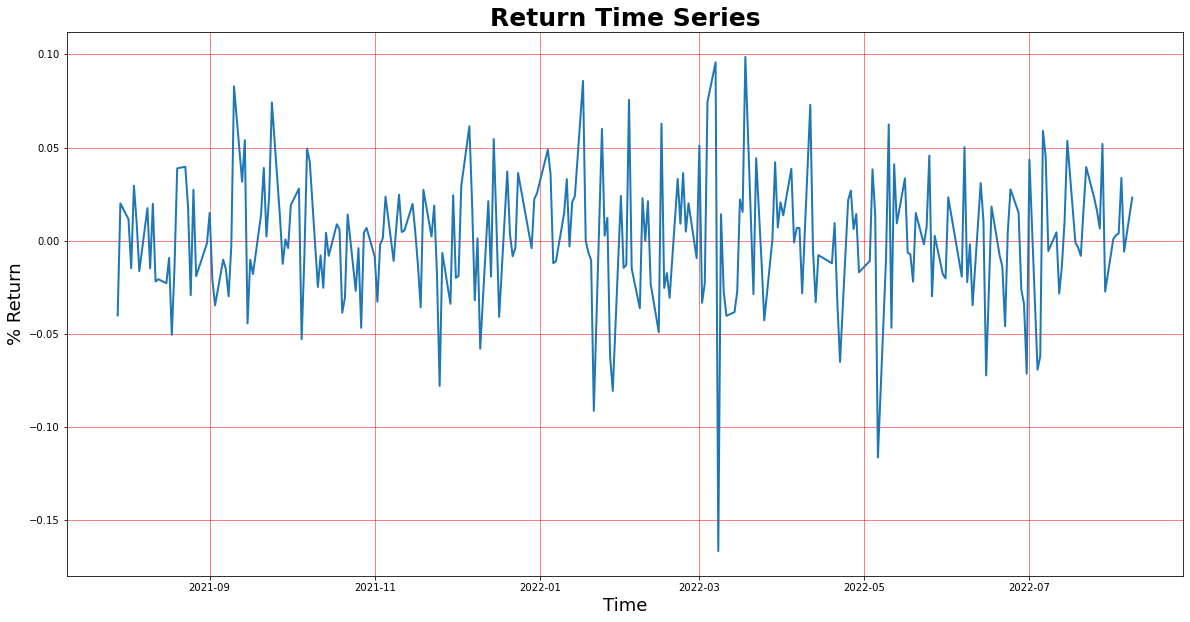

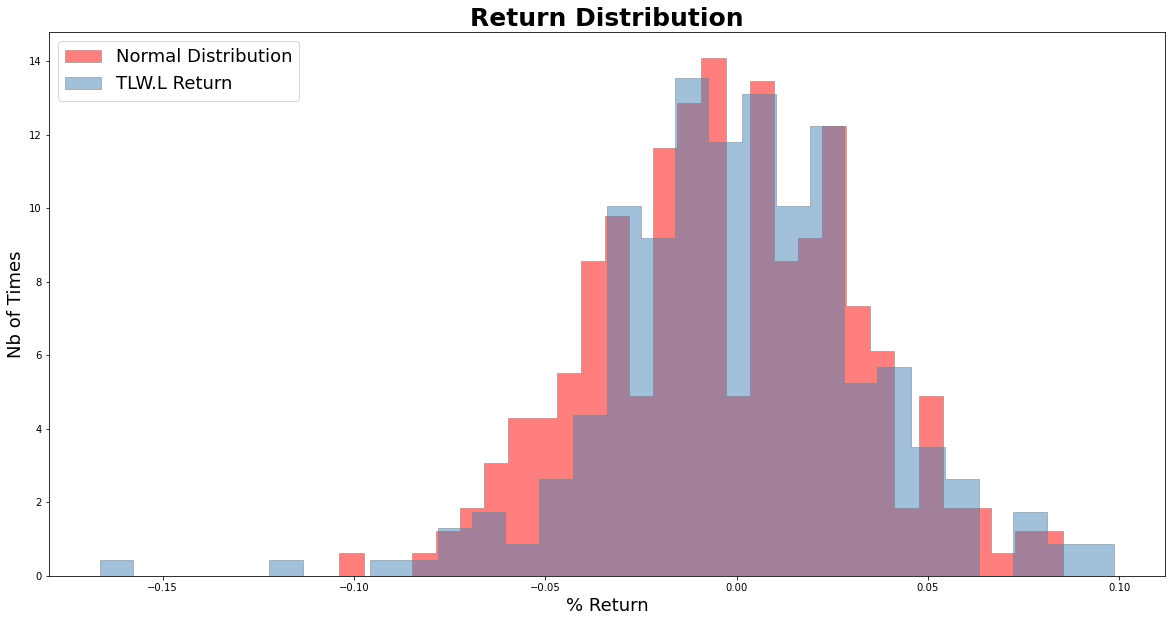

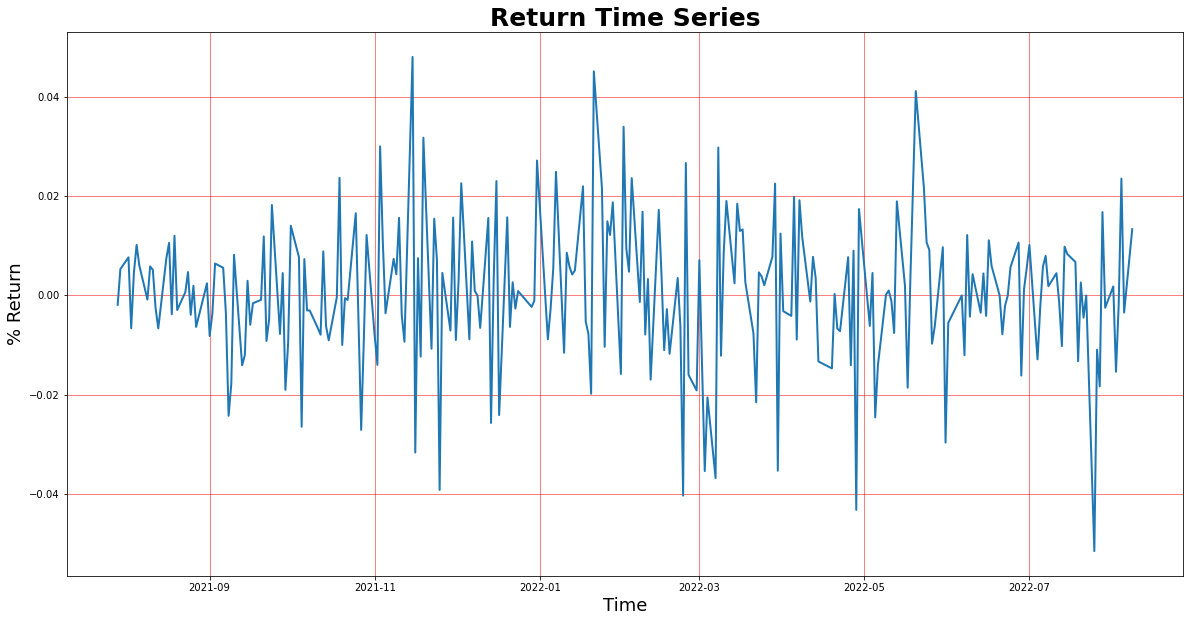

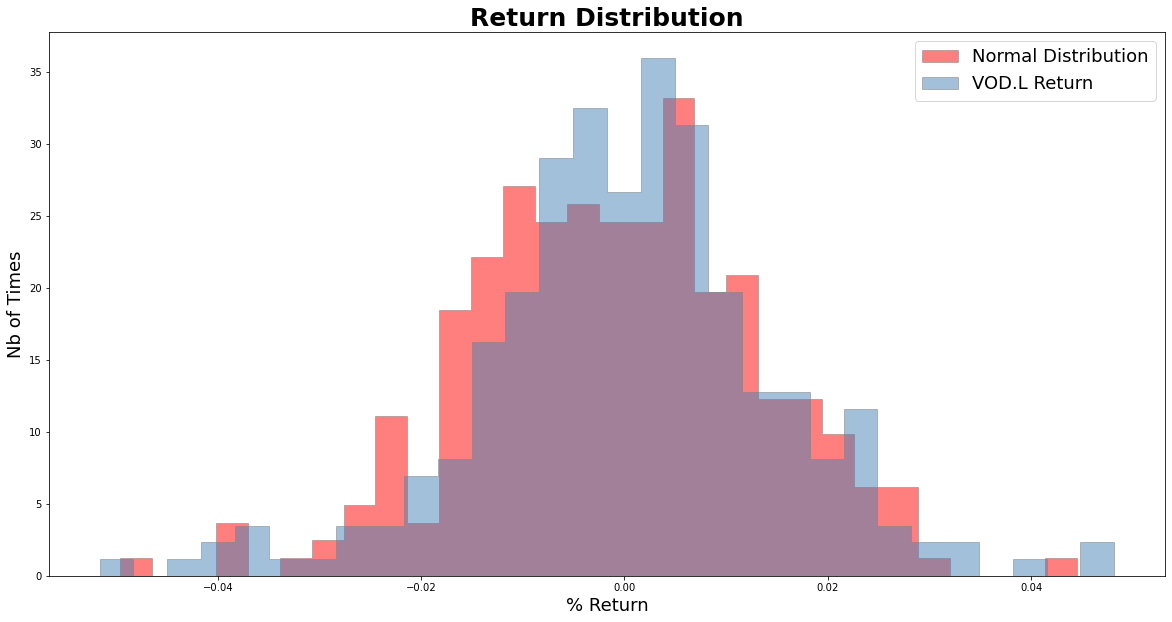

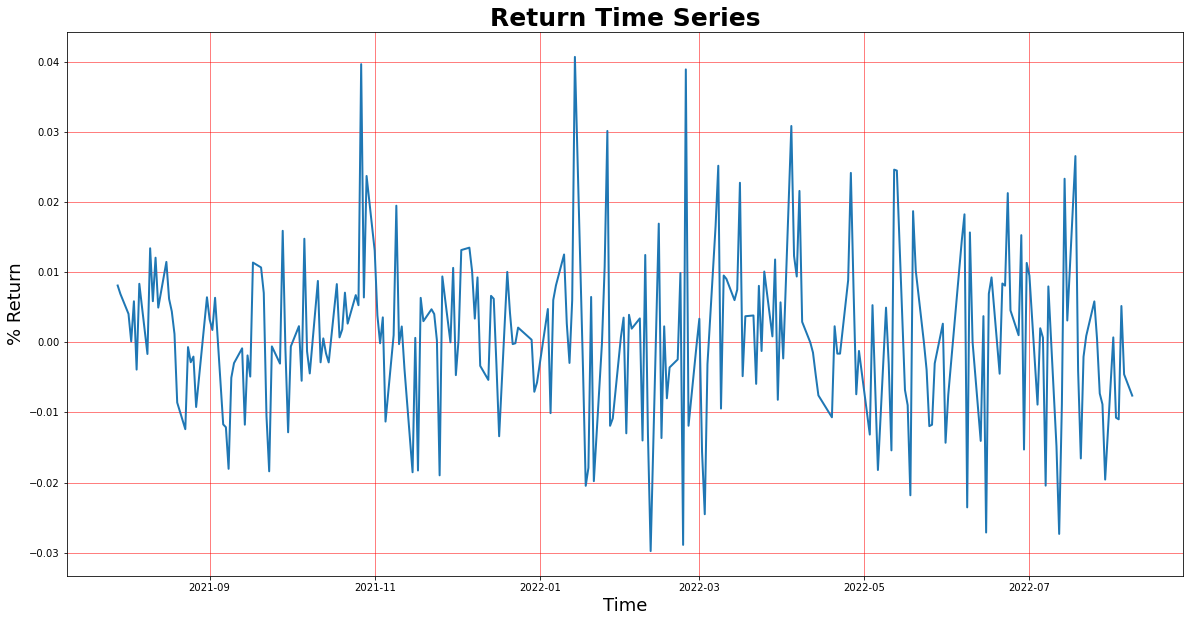

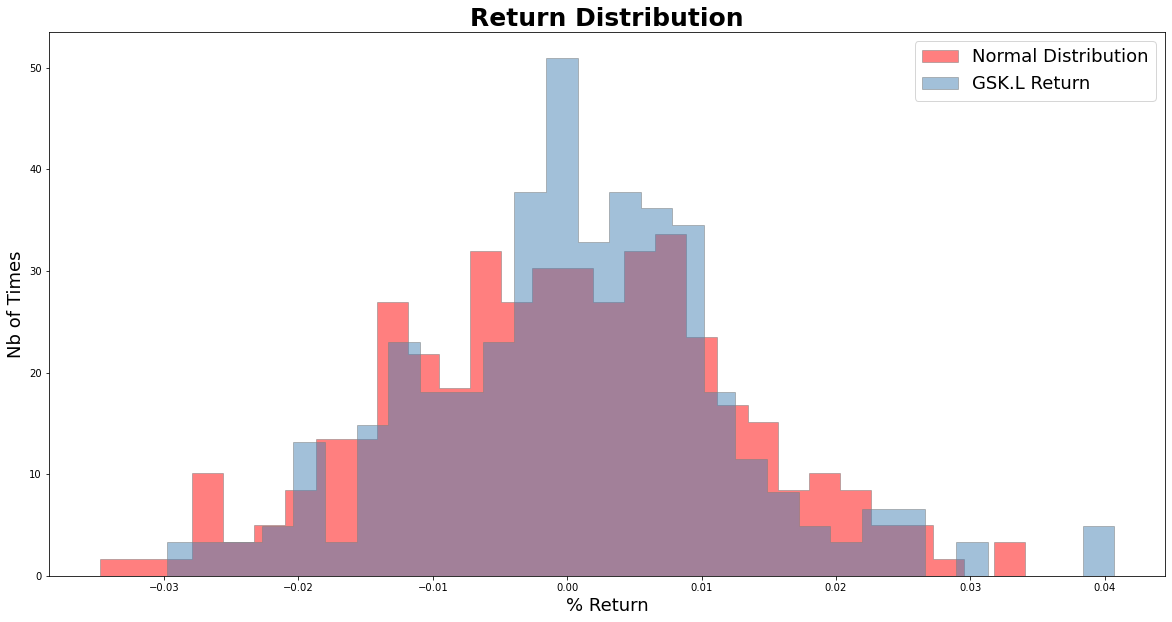

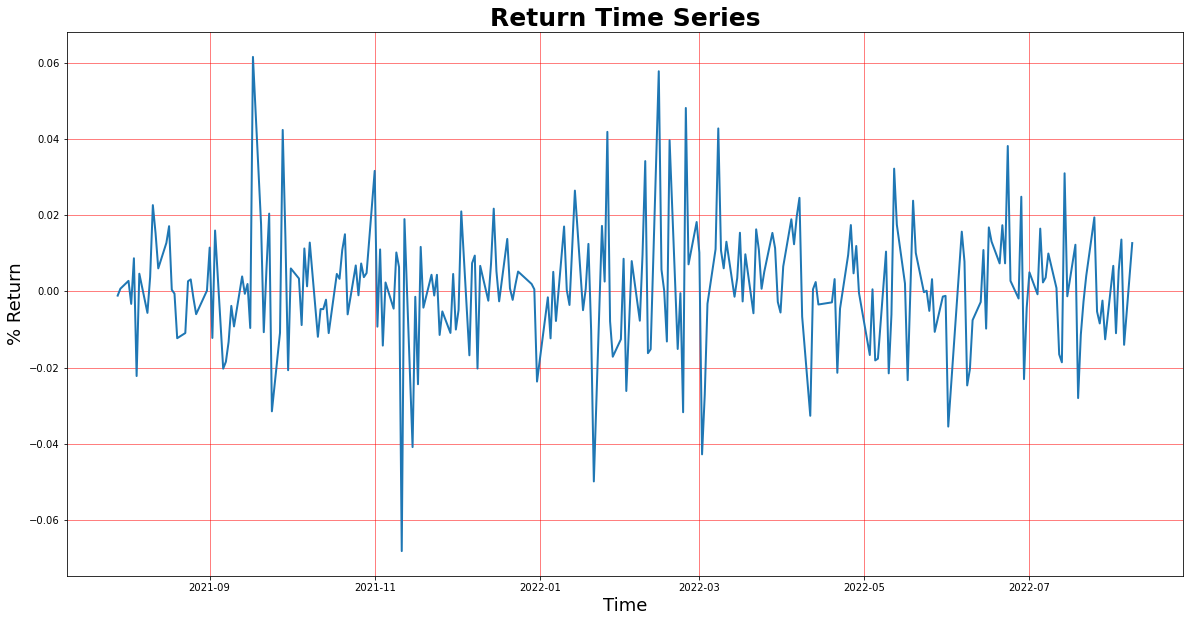

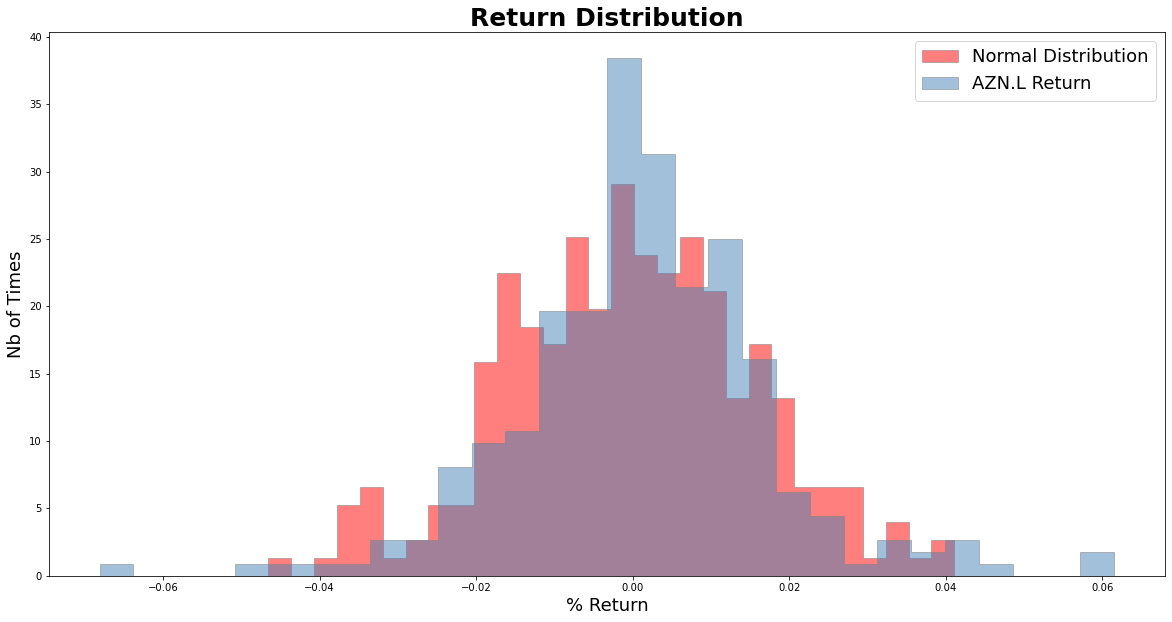

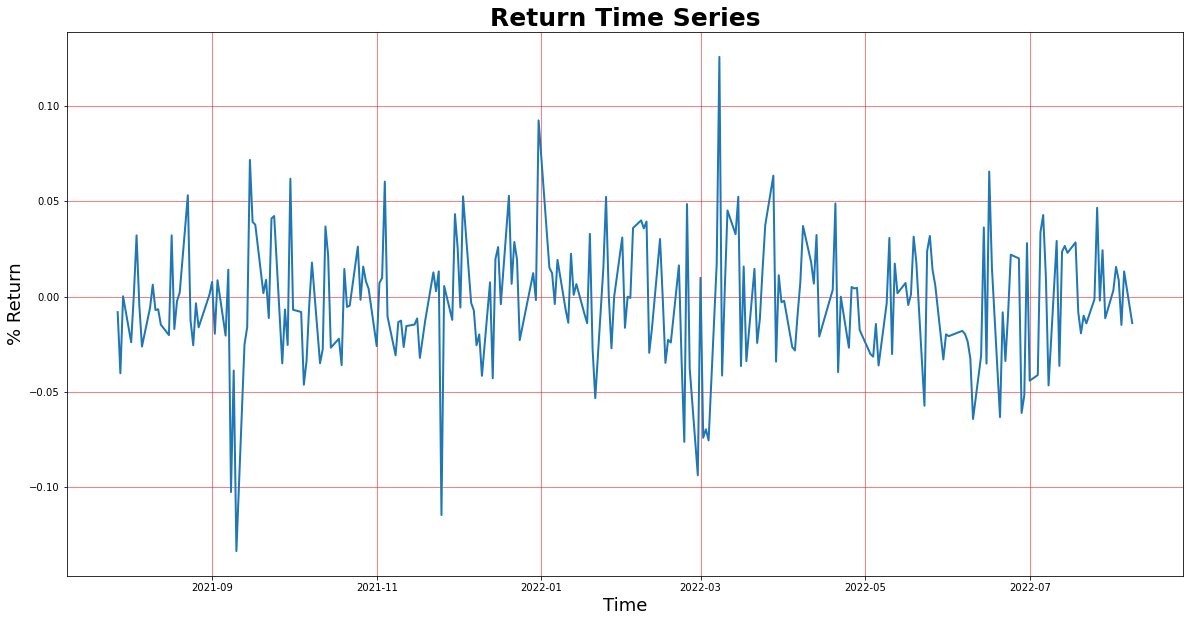

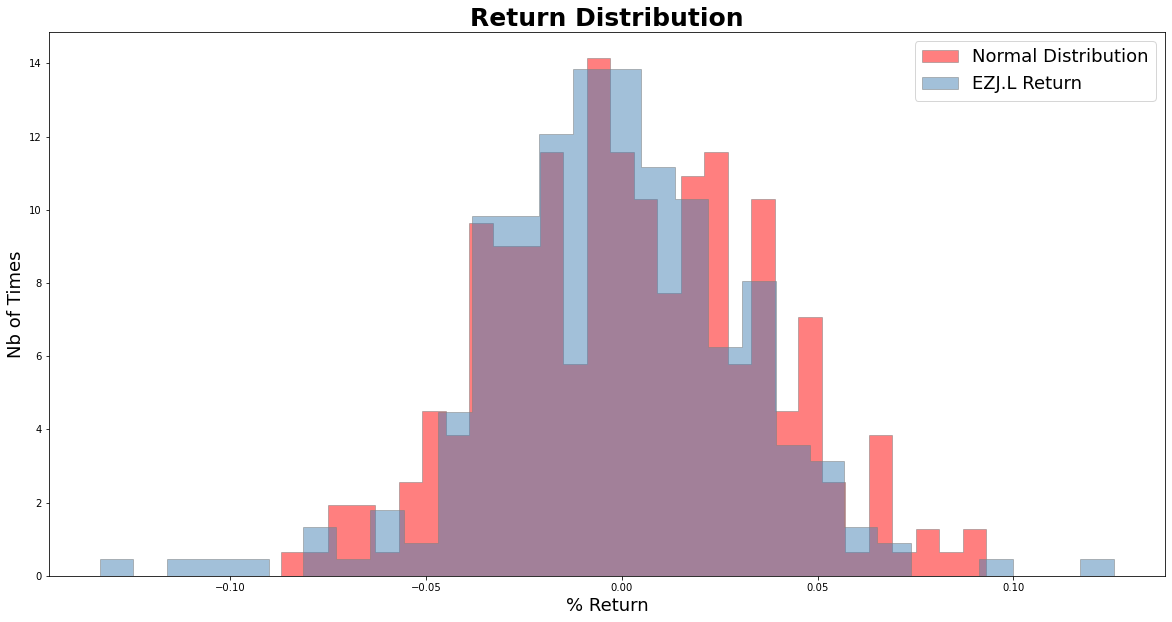

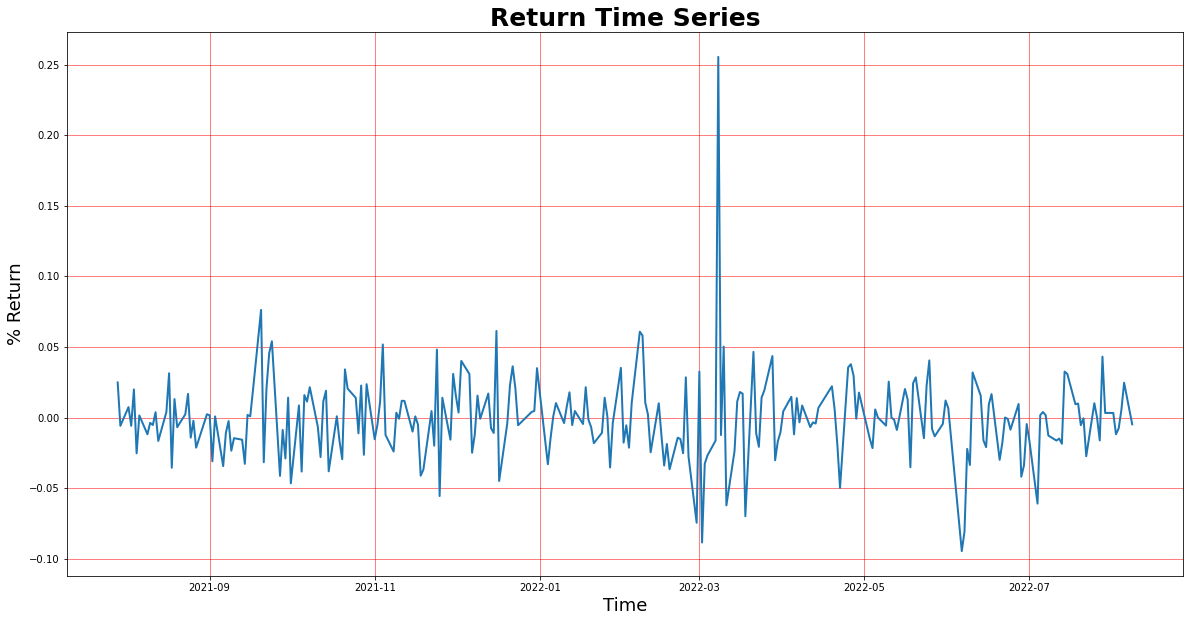

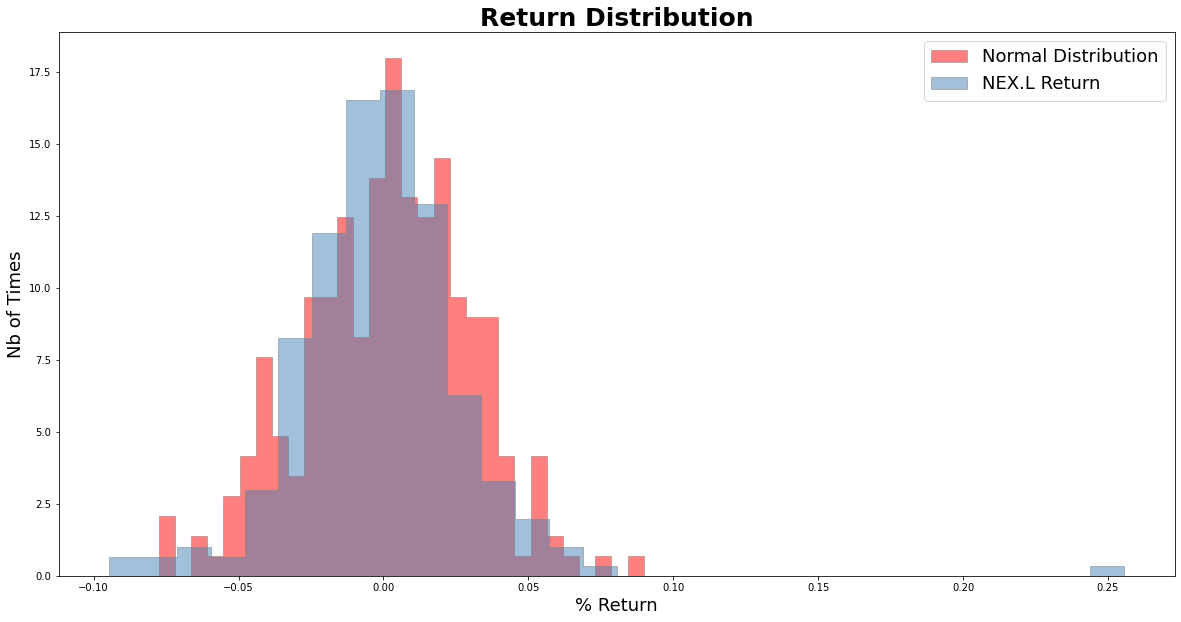

In [154]:
assets = ['HMSO.L','BLND.L',"HSBA.L",'LLOY.L','EMG.L',
          'IGG.L','CNA.L','NG.L','CTEC.L','MDC.L',
          'SN.L','TSCO.L','OCDO.L','BP.L','TLW.L',
          'VOD.L','GSK.L','AZN.L','EZJ.L','NEX.L']
for i in assets:
    stock = download_stock_data(i)
    stock = calculate_stock_return(stock[0],stock[1])
    show_distribution(stock[0],stock[1])
    alpha = 0.05
    CVaR95_actual_percentile = expected_shortfall(alpha, stock[0], stock[1], True)
    CVaR95_actual_percentile = expected_shortfall(alpha, stock[0], stock[1], False)
    alpha = 0.01
    CVaR95_actual_percentile = expected_shortfall(alpha, stock[0], stock[1], True)
    CVaR95_actual_percentile = expected_shortfall(alpha, stock[0], stock[1], False)

# MV and CVaR for three period

## Lockdown Period

### Downloading the data

In [331]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2020-04-01'
end = '2021-07-31'

# Tickers of assets
assets = ['HMSO.L','BLND.L',"HSBA.L",'LLOY.L','EMG.L',
          'IGG.L','CNA.L','NG.L','CTEC.L','MDC.L',
          'SN.L','TSCO.L','OCDO.L','BP.L','TLW.L',
          'VOD.L','GSK.L','AZN.L','EZJ.L','NEX.L']
assets.sort()

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

[*********************100%***********************]  20 of 20 completed


In [332]:
# Calculating returns

Y = data[assets].pct_change().dropna()

display(Y.head())

AZN.L   BLND.L     BP.L    CNA.L   CTEC.L    EMG.L    EZJ.L  \
Date                                                                        
2020-04-02 -1.7178%  2.8999%  5.8885% -8.5961%  2.7258%  1.6491% -5.4033%   
2020-04-03  2.3496% -2.6014% -4.5422% -6.1321% -0.3320% -0.0832% -4.4650%   
2020-04-06  0.5599%  6.5501% -0.4299% -1.1307% -0.0555%  4.7044% 16.2947%   
2020-04-07 -2.5613% 10.4148%  1.5334%  2.8590%  0.0556% -0.7555% 15.0977%   
2020-04-08 -0.4143%  4.4324% -1.6569%  4.0148% -1.3326% -1.4022%  1.6043%   

              GSK.L    HMSO.L   HSBA.L    IGG.L   LLOY.L    MDC.L     NEX.L  \
Date                                                                          
2020-04-02 -0.4135%  -4.9381% -3.2238% -1.9118%  2.2462% -3.5606% -12.7941%   
2020-04-03 -0.2545% -25.1112% -0.1383%  0.0750% -4.0823% -3.6135%   3.9348%   
2020-04-06  1.3428%   6.0091%  4.4058%  1.5731%  7.9892%  3.3415%   8.7074%   
2020-04-07  0.3578%  34.7096%  1.1816%  2.2861%  4.2752%  8.4385%  11.3433%   
2020-04-08 -1.0167%   0.7794%  0.2026%  0.7931%  2.0500%  2.6182%  -0.2681%   

               NG.L   OCDO.L     SN.L     TLW.L   TSCO.L    VOD.L  
Date                                                               
2020-04-02 -4.4537%  0.4137% -2.2779%  12.6869% -2.0591%  0.6387%  
2020-04-03 -3.3525%  2.2097%  1.3760%  47.9880%  2.3309%  0.6528%  
2020-04-06  2.8748%  1.7955%  5.0991%  39.4851% -1.0272%  4.9901%  
2020-04-07 -1.0854% -4.6436%  2.8272%  13.8117%  1.1733% -0.7550%  
2020-04-08  1.8211%  2.3028%  1.9688% -11.6254% -0.5799% -4.1840%

### Estimating Mean Variance Portfolios

#### Calculating the portfolio that maximizes Sharpe ratio

In [333]:
#Calculating the portfolio that maximizes Sharpe ratio.
import riskfolio as rp

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

AZN.L  BLND.L    BP.L   CNA.L   CTEC.L    EMG.L   EZJ.L   GSK.L  \
weights 2.5789% 8.2086% 0.0000% 0.9758% 21.2718% 30.5612% 0.0000% 0.0000%   

         HMSO.L  HSBA.L   IGG.L  LLOY.L   MDC.L   NEX.L    NG.L   OCDO.L  \
weights 0.0000% 0.0000% 6.6666% 0.7508% 0.0000% 0.0000% 0.0000% 19.6250%   

           SN.L   TLW.L  TSCO.L   VOD.L  
weights 0.0000% 9.3611% 0.0000% 0.0000%

#### Plotting portfolio composition

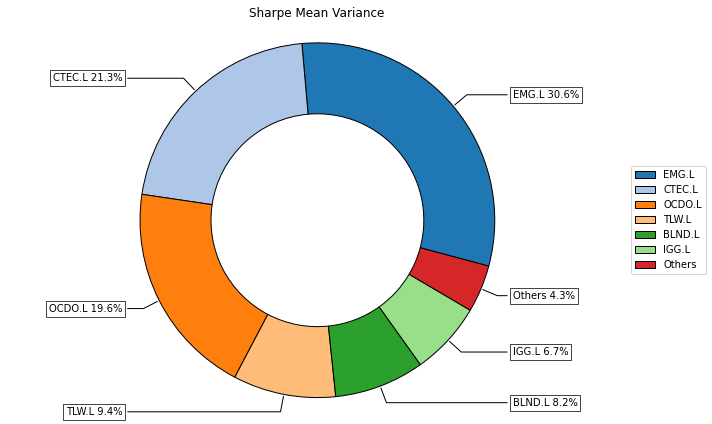

In [334]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

#### Calculate efficient frontier

In [335]:
#Calculate efficient frontier
points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

AZN.L  BLND.L    BP.L   CNA.L   CTEC.L    EMG.L   EZJ.L   GSK.L  HMSO.L  \
0 10.4078% 4.4026% 0.0000% 0.0769% 19.4096%  0.0000% 0.0000% 1.0327% 0.0000%   
1 10.3439% 6.8698% 0.0000% 1.6377% 22.2151% 15.4871% 0.0000% 0.0000% 0.0000%   
2  9.5464% 7.5088% 0.0000% 2.0717% 22.8662% 22.9475% 0.0000% 0.0000% 0.0000%   
3  4.4329% 8.0256% 0.0000% 1.2754% 21.7050% 28.6220% 0.0000% 0.0000% 0.0000%   
4  0.0000% 8.4562% 0.0000% 0.5569% 20.6542% 33.2699% 0.0000% 0.0000% 0.0000%   

   HSBA.L    IGG.L  LLOY.L   MDC.L   NEX.L     NG.L   OCDO.L    SN.L    TLW.L  \
0 3.1702%  9.7656% 0.0000% 4.1318% 0.0000% 13.1521%  5.7509% 0.0000%  0.0000%   
1 0.0000% 10.3460% 2.5676% 0.0000% 0.0000%  4.2270% 12.8565% 0.0000%  3.5155%   
2 0.0000% 10.1817% 2.4957% 0.0000% 0.0000%  0.0000% 16.2585% 0.0000%  5.4798%   
3 0.0000%  7.6073% 1.2199% 0.0000% 0.0000%  0.0000% 18.7673% 0.0000%  8.3447%   
4 0.0000%  5.3414% 0.1131% 0.0000% 0.0000%  0.0000% 20.8240% 0.0000% 10.7843%   

    TSCO.L   VOD.L  
0 28.4411% 0.2587%  
1  9.9338% 0.0000%  
2  0.6437% 0.0000%  
3  0.0000% 0.0000%  
4  0.0000% 0.0000%

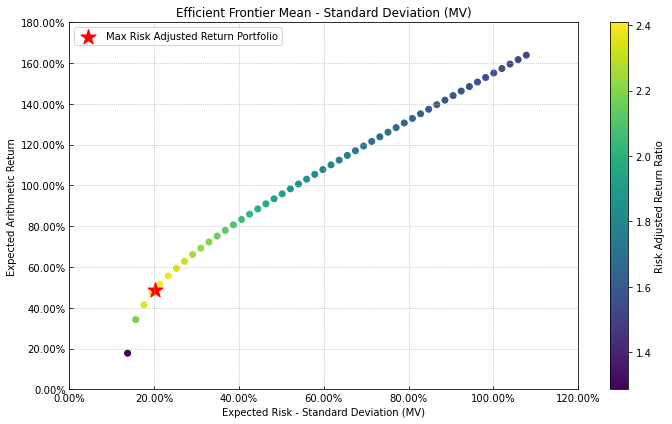

In [336]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

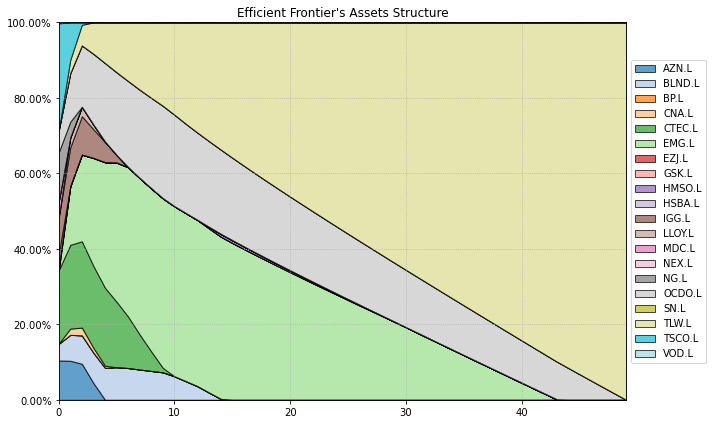

In [337]:
# Plotting efficient frontier composition

ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

### Estimating Mean Risk Portfolios

In this part I will calculate optimal portfolios for several risk measures. First I'm going to calculate the portfolio that maximizes risk adjusted return when CVaR is the risk measure, then I'm going to calculate the portfolios that maximize the risk adjusted return for all available risk measures.

#### Calculating the portfolio that maximizes Return/CVaR ratio

In [338]:
#Estimating Mean Risk Portfolios
#3.1 Calculating the portfolio that maximizes Return/CVaR ratio
rm = 'CVaR' # Risk measure

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

AZN.L   BLND.L    BP.L   CNA.L   CTEC.L    EMG.L   EZJ.L   GSK.L  \
weights 0.0000% 10.2148% 0.0000% 0.2851% 16.7009% 35.3001% 0.0000% 0.0000%   

         HMSO.L  HSBA.L   IGG.L  LLOY.L   MDC.L   NEX.L    NG.L   OCDO.L  \
weights 0.0000% 0.0000% 0.0000% 0.0000% 0.0000% 0.0000% 0.0000% 21.3279%   

           SN.L    TLW.L  TSCO.L   VOD.L  
weights 0.0000% 16.1712% 0.0000% 0.0000%

#### Plotting portfolio composition

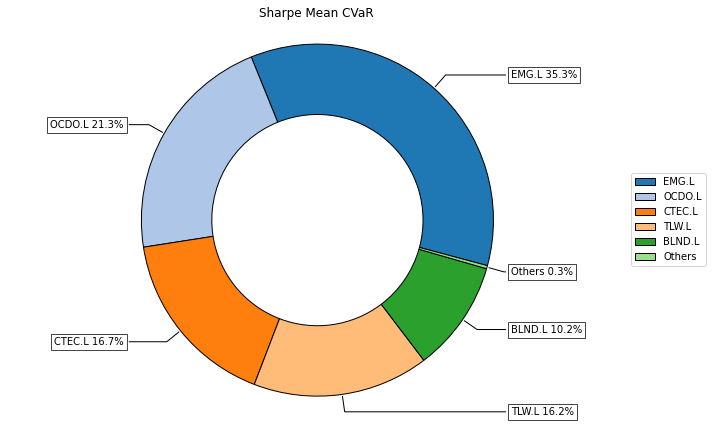

In [339]:
ax = rp.plot_pie(w=w, title='Sharpe Mean CVaR', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

#### Calculate efficient frontier

In [340]:
points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

AZN.L  BLND.L    BP.L   CNA.L   CTEC.L    EMG.L   EZJ.L    GSK.L  HMSO.L  \
0 17.0996% 0.0000% 0.0000% 0.0000% 19.6208%  0.0000% 0.3130% 11.9608% 0.0000%   
1 23.4083% 0.0000% 0.0000% 0.3126% 16.0143% 11.3274% 0.0000%  0.0000% 0.0000%   
2 17.7470% 0.0000% 0.0000% 0.0000% 16.0153% 20.6909% 0.0000%  0.0000% 0.0000%   
3  9.6074% 6.7904% 0.0000% 0.0000% 16.7182% 32.2247% 0.0000%  0.0000% 0.0000%   
4  6.9754% 7.2104% 0.0000% 0.2598% 17.0078% 38.5836% 0.0000%  0.0000% 0.0000%   

   HSBA.L   IGG.L  LLOY.L   MDC.L   NEX.L    NG.L   OCDO.L    SN.L    TLW.L  \
0 0.0000% 7.8902% 0.0000% 2.3553% 4.7403% 4.8582%  6.2778% 0.0000%  0.0000%   
1 0.0000% 0.0000% 0.0000% 0.0000% 6.0688% 0.0000% 16.9064% 0.0000%  5.6039%   
2 0.0000% 0.0000% 0.0000% 0.0000% 3.3918% 0.0000% 18.8759% 0.0000%  8.1096%   
3 0.0000% 0.0000% 0.0000% 0.0000% 1.1311% 0.0000% 18.4581% 0.0000%  8.3867%   
4 0.0000% 0.0000% 0.0000% 0.0000% 0.0000% 0.0000% 19.1878% 0.0000% 10.1430%   

    TSCO.L   VOD.L  
0 24.8840% 0.0000%  
1 20.3583% 0.0000%  
2 15.1696% 0.0000%  
3  6.6834% 0.0000%  
4  0.6322% 0.0000%

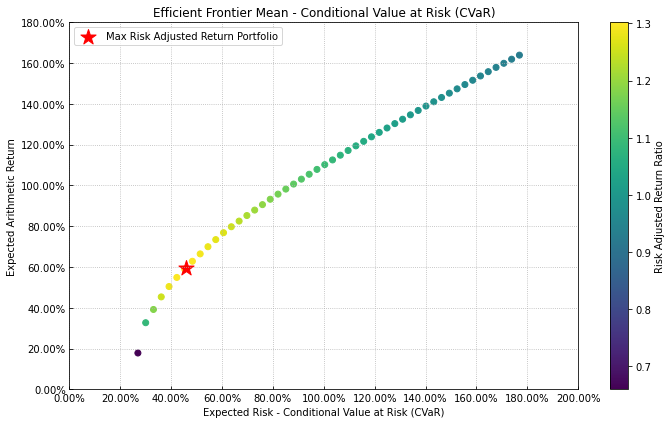

In [341]:
label = 'Max Risk Adjusted Return Portfolio' # Title of point

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

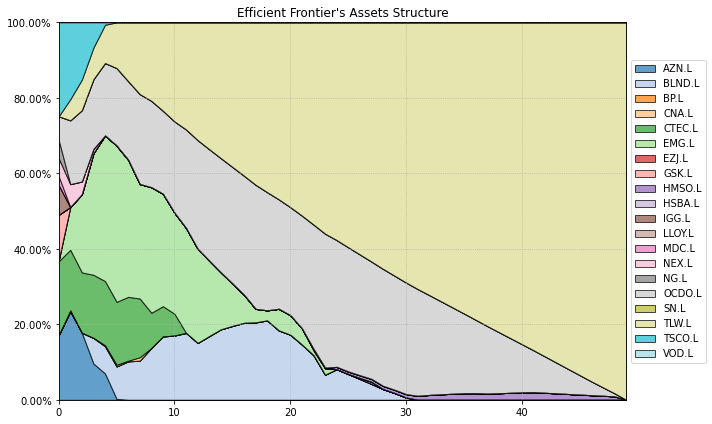

In [342]:
# Plotting efficient frontier composition

ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

#### Calculate Optimal Portfolios for Several Risk Measures

In [343]:
# Risk Measures available:
#
# 'MV': Standard Deviation.

# 'CVaR': Conditional Value at Risk.


rms = ['MV', 'CVaR']

w_s = pd.DataFrame([])

for i in rms:
    w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms

In [344]:
w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

<AxesSubplot:>

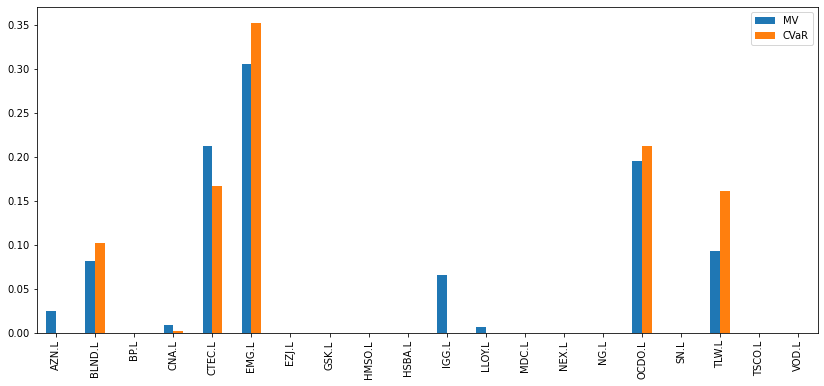

In [345]:
import matplotlib.pyplot as plt

# Plotting a comparison of assets weights for each portfolio

fig = plt.gcf()
fig.set_figwidth(14)
fig.set_figheight(6)
ax = fig.subplots(nrows=1, ncols=1)

w_s.plot.bar(ax=ax)

### Constraints on Assets and Assets Classes

In [346]:
asset_classes = {'Assets': ['HMSO.L','BLND.L',"HSBA.L",'LLOY.L','EMG.L',
          'IGG.L','CNA.L','NG.L','CTEC.L','MDC.L',
          'SN.L','TSCO.L','OCDO.L','BP.L','TLW.L',
          'VOD.L','GSK.L','AZN.L','EZJ.L','NEX.L'], 
                 'Industry': ['Real Estate','Real Estate',
                              'Financial Services', 'Financial Services',
                              'Financial Services','Financial Services','Utilities',
                              'Utilities','Healthcare','Healthcare',
                              'Healthcare','Consumer Defensive','Consumer Defensive',
                              'Energy','Energy','Communication Services',
                              'Healthcare','Healthcare',
                              'Industrials','Industrials']}

asset_classes = pd.DataFrame(asset_classes)
asset_classes = asset_classes.sort_values(by=['Assets'])

constraints = {'Disabled': [False, False, False],
               'Type': ['All Assets', 'Classes', 'Classes'],
               'Set': ['', 'Industry', 'Industry'],
               'Position': ['', 'Financial Services', 'Healthcare'],
               'Sign': ['<=', '<=', '<='],
               'Weight': [0.1, 0.2, 0.25],
               'Type Relative': ['', '', ''],
               'Relative Set': ['', '', ''],
               'Relative': ['', '', ''],
               'Factor': ['', '', '']
               }

constraints = pd.DataFrame(constraints)

display(constraints)

Disabled        Type       Set            Position Sign   Weight  \
0     False  All Assets                                 <= 10.0000%   
1     False     Classes  Industry  Financial Services   <= 20.0000%   
2     False     Classes  Industry          Healthcare   <= 25.0000%   

  Type Relative Relative Set Relative Factor  
0                                             
1                                             
2

In [347]:
A, B = rp.assets_constraints(constraints, asset_classes)

In [348]:
port.ainequality = A
port.binequality = B

model = 'Classic'
rm = 'MV'
obj = 'Sharpe'
rf = 0

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

AZN.L   BLND.L    BP.L   CNA.L   CTEC.L    EMG.L   EZJ.L   GSK.L  \
weights 10.0000% 10.0000% 0.0000% 7.6948% 10.0000% 10.0000% 0.5447% 1.3932%   

         HMSO.L  HSBA.L    IGG.L  LLOY.L   MDC.L   NEX.L     NG.L   OCDO.L  \
weights 0.0000% 0.0000% 10.0000% 0.0000% 0.0000% 0.0000% 10.0000% 10.0000%   

           SN.L    TLW.L   TSCO.L   VOD.L  
weights 0.0000% 10.0000% 10.0000% 0.3673%

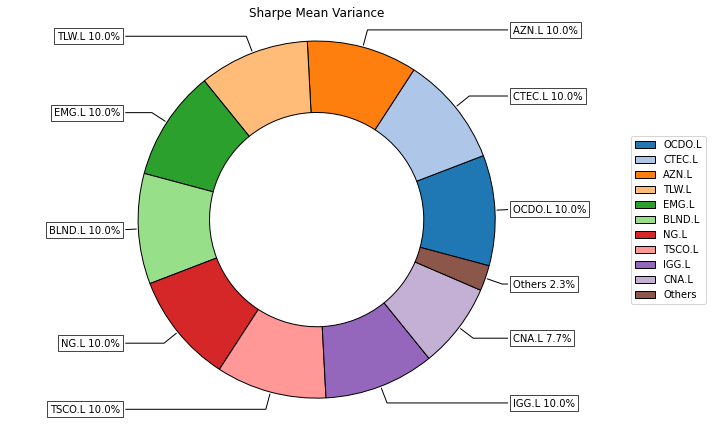

In [349]:
ax = rp.plot_pie(w=w, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

In [350]:
w_classes = pd.concat([asset_classes.set_index('Assets'), w], axis=1)

display(w_classes)

Industry  weights
AZN.L               Healthcare 10.0000%
BLND.L             Real Estate 10.0000%
BP.L                    Energy  0.0000%
CNA.L                Utilities  7.6948%
CTEC.L              Healthcare 10.0000%
EMG.L       Financial Services 10.0000%
EZJ.L              Industrials  0.5447%
GSK.L               Healthcare  1.3932%
HMSO.L             Real Estate  0.0000%
HSBA.L      Financial Services  0.0000%
IGG.L       Financial Services 10.0000%
LLOY.L      Financial Services  0.0000%
MDC.L               Healthcare  0.0000%
NEX.L              Industrials  0.0000%
NG.L                 Utilities 10.0000%
OCDO.L      Consumer Defensive 10.0000%
SN.L                Healthcare  0.0000%
TLW.L                   Energy 10.0000%
TSCO.L      Consumer Defensive 10.0000%
VOD.L   Communication Services  0.3673%

In [351]:
w_classes = w_classes.groupby(['Industry']).sum()

display(w_classes)

weights
Industry                       
Communication Services  0.3673%
Consumer Defensive     20.0000%
Energy                 10.0000%
Financial Services     20.0000%
Healthcare             21.3932%
Industrials             0.5447%
Real Estate            10.0000%
Utilities              17.6948%

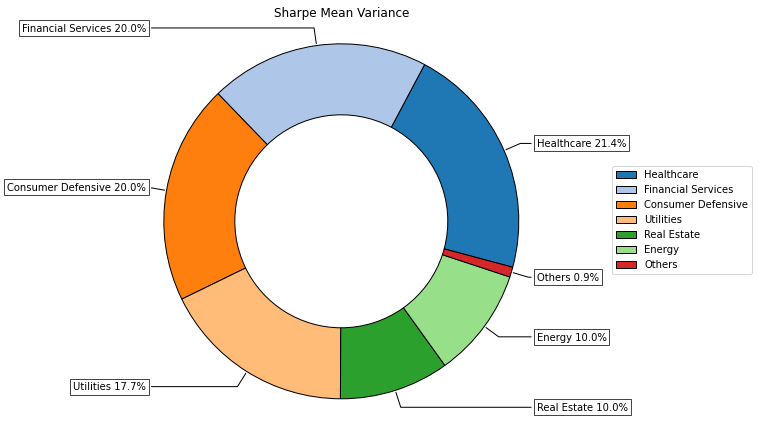

In [352]:
ax = rp.plot_pie(w=w_classes, title='Sharpe Mean Variance', others=0.05, nrow=25,
                 cmap = "tab20", height=6, width=10, ax=None)

In [353]:
#Calculate efficient frontier
points = 50# Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

AZN.L   BLND.L    BP.L   CNA.L   CTEC.L    EMG.L   EZJ.L   GSK.L  HMSO.L  \
0 10.0000%  7.9760% 1.9209% 5.1031% 10.0000%  8.8073% 0.0000% 4.4991% 0.0000%   
1 10.0000% 10.0000% 0.0000% 4.5079% 10.0000% 10.0000% 0.0000% 4.4269% 0.0000%   
2 10.0000% 10.0000% 0.0000% 4.9090% 10.0000% 10.0000% 0.0000% 4.5661% 0.0000%   
3 10.0000% 10.0000% 0.0000% 5.2252% 10.0000% 10.0000% 0.0000% 4.6737% 0.0000%   
4 10.0000% 10.0000% 0.0000% 5.4980% 10.0000% 10.0000% 0.0000% 4.7684% 0.0000%   

   HSBA.L    IGG.L  LLOY.L   MDC.L   NEX.L     NG.L   OCDO.L    SN.L   TLW.L  \
0 1.1927% 10.0000% 0.0000% 0.5009% 0.0000% 10.0000% 10.0000% 0.0000% 0.0000%   
1 0.0000% 10.0000% 0.0000% 0.5731% 0.0000% 10.0000% 10.0000% 0.0000% 2.5928%   
2 0.0000% 10.0000% 0.0000% 0.4339% 0.0000% 10.0000% 10.0000% 0.0000% 4.0321%   
3 0.0000% 10.0000% 0.0000% 0.3263% 0.0000% 10.0000% 10.0000% 0.0000% 5.1674%   
4 0.0000% 10.0000% 0.0000% 0.2316% 0.0000% 10.0000% 10.0000% 0.0000% 6.1464%   

    TSCO.L    VOD.L  
0 10.0000% 10.0000%  
1 10.0000%  7.8993%  
2 10.0000%  6.0589%  
3 10.0000%  4.6073%  
4 10.0000%  3.3556%

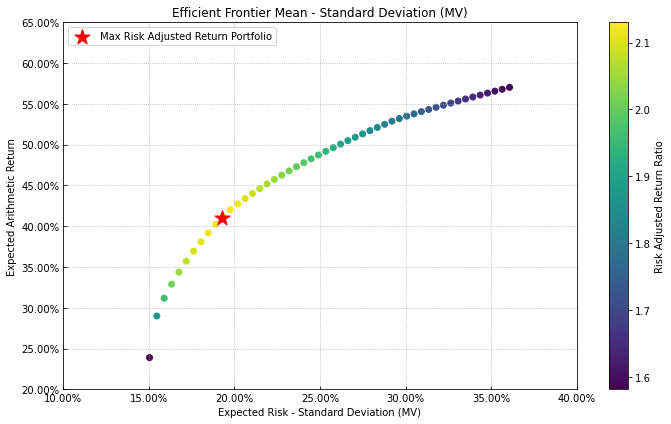

In [354]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

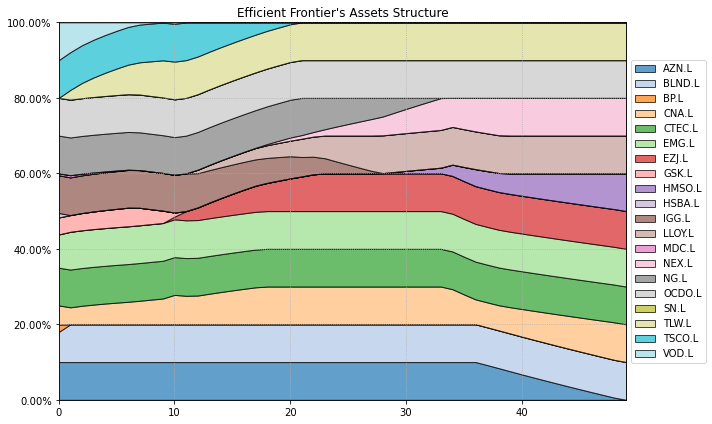

In [355]:
# Plotting efficient frontier composition

ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

In [356]:
rm = 'CVaR' # Risk measure

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

AZN.L   BLND.L    BP.L    CNA.L   CTEC.L    EMG.L   EZJ.L   GSK.L  \
weights 10.0000% 10.0000% 0.0000% 10.0000% 10.0000% 10.0000% 4.1400% 0.0000%   

         HMSO.L  HSBA.L    IGG.L  LLOY.L   MDC.L   NEX.L    NG.L   OCDO.L  \
weights 0.0000% 0.0000% 10.0000% 0.0000% 0.0000% 4.2759% 1.5841% 10.0000%   

           SN.L    TLW.L   TSCO.L   VOD.L  
weights 0.0000% 10.0000% 10.0000% 0.0000%

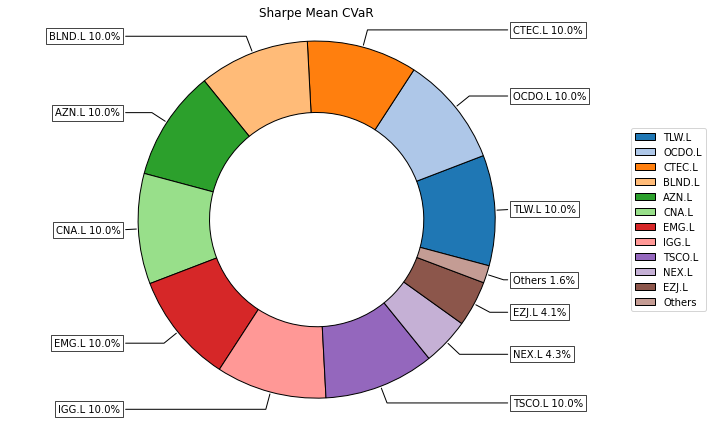

In [357]:
ax = rp.plot_pie(w=w, title='Sharpe Mean CVaR', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

In [358]:
w_classes = pd.concat([asset_classes.set_index('Assets'), w], axis=1)

display(w_classes)

Industry  weights
AZN.L               Healthcare 10.0000%
BLND.L             Real Estate 10.0000%
BP.L                    Energy  0.0000%
CNA.L                Utilities 10.0000%
CTEC.L              Healthcare 10.0000%
EMG.L       Financial Services 10.0000%
EZJ.L              Industrials  4.1400%
GSK.L               Healthcare  0.0000%
HMSO.L             Real Estate  0.0000%
HSBA.L      Financial Services  0.0000%
IGG.L       Financial Services 10.0000%
LLOY.L      Financial Services  0.0000%
MDC.L               Healthcare  0.0000%
NEX.L              Industrials  4.2759%
NG.L                 Utilities  1.5841%
OCDO.L      Consumer Defensive 10.0000%
SN.L                Healthcare  0.0000%
TLW.L                   Energy 10.0000%
TSCO.L      Consumer Defensive 10.0000%
VOD.L   Communication Services  0.0000%

In [359]:
w_classes = w_classes.groupby(['Industry']).sum()

display(w_classes)

weights
Industry                       
Communication Services  0.0000%
Consumer Defensive     20.0000%
Energy                 10.0000%
Financial Services     20.0000%
Healthcare             20.0000%
Industrials             8.4159%
Real Estate            10.0000%
Utilities              11.5841%

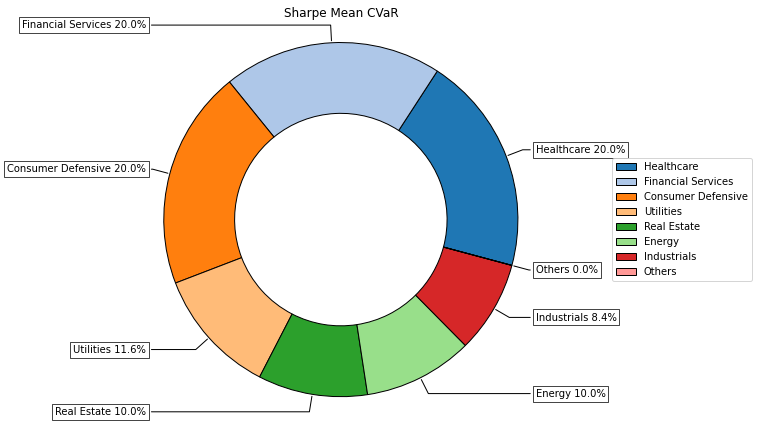

In [360]:
ax = rp.plot_pie(w=w_classes, title='Sharpe Mean CVaR', others=0.05, nrow=25,
                 cmap = "tab20", height=6, width=10, ax=None)

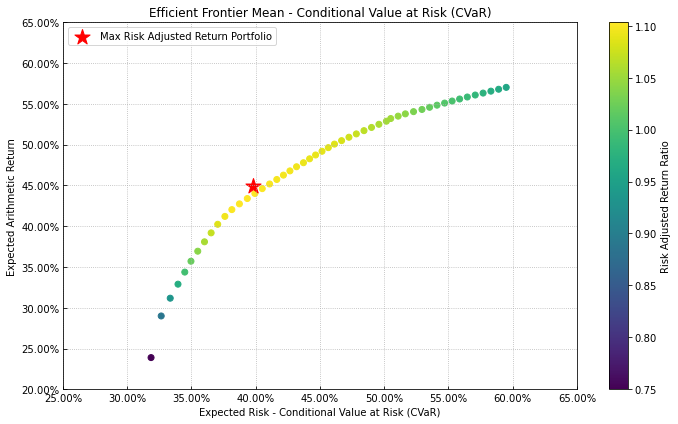

In [361]:
label = 'Max Risk Adjusted Return Portfolio' # Title of point

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

In [362]:
# Risk Measures available:
#
# 'MV': Standard Deviation.

# 'CVaR': Conditional Value at Risk.


rms = ['MV', 'CVaR']

w_s = pd.DataFrame([])

for i in rms:
    w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms

In [363]:
w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

<AxesSubplot:>

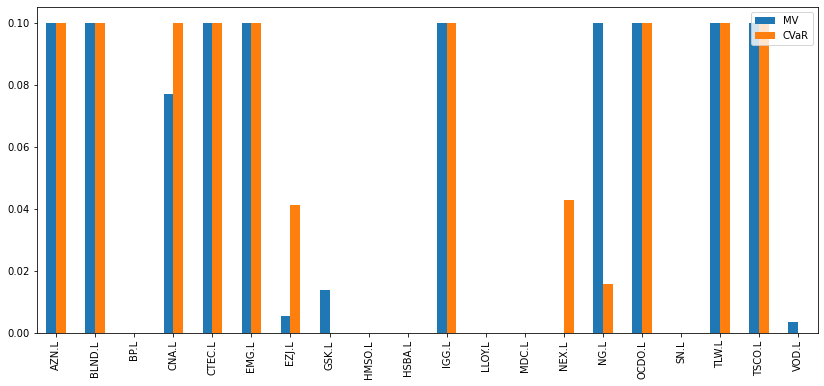

In [364]:
import matplotlib.pyplot as plt

# Plotting a comparison of assets weights for each portfolio

fig = plt.gcf()
fig.set_figwidth(14)
fig.set_figheight(6)
ax = fig.subplots(nrows=1, ncols=1)

w_s.plot.bar(ax=ax)

## Last One Year

In [38]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2021-08-01'
end = '2022-07-31'

# Tickers of assets
assets = ['HMSO.L','BLND.L',"HSBA.L",'LLOY.L','EMG.L',
          'IGG.L','CNA.L','NG.L','CTEC.L','MDC.L',
          'SN.L','TSCO.L','OCDO.L','BP.L','TLW.L',
          'VOD.L','GSK.L','AZN.L','EZJ.L','NEX.L']
assets.sort()

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

[*********************100%***********************]  20 of 20 completed


In [39]:
# Calculating returns

Y = data[assets].pct_change().dropna()

display(Y.head())

AZN.L   BLND.L     BP.L   CNA.L  CTEC.L    EMG.L    EZJ.L  \
Date                                                                      
2021-08-03  0.2780% -1.7321%  5.6428% 2.5462% 0.4896%  1.1000% -2.3866%   
2021-08-04 -0.3254%  0.5875% -1.0127% 0.9975% 1.5057%  3.9565%  0.1210%   
2021-08-05  0.8706%  2.4533%  0.9076% 0.8615% 0.0436%  1.5814%  3.2157%   
2021-08-06 -2.2177%  0.1900%  0.5560% 2.0625% 0.3053%  0.0955% -0.3982%   
2021-08-09  0.4659% -2.1624% -0.6505% 0.5715% 0.0000% -0.1431% -2.6105%   

              GSK.L   HMSO.L  HSBA.L    IGG.L   LLOY.L    MDC.L    NEX.L  \
Date                                                                       
2021-08-03  0.4063%  0.4022% 0.4796% -0.2753%  1.3302% -0.1395%  0.7396%   
2021-08-04  0.0140%  0.1603% 0.5904%  1.3804%  0.9712% -1.4665% -0.5874%   
2021-08-05  0.5859% -4.7733% 0.6244% -0.7081% -1.5653%  0.1417%  1.9941%   
2021-08-06 -0.3883%  2.4923% 1.7250% -2.1942%  1.4704% -1.4154% -2.5344%   
2021-08-09  0.8354% -0.9563% 0.2196% -0.9535%  0.1288%  0.3589%  0.1486%   

               NG.L   OCDO.L     SN.L    TLW.L   TSCO.L    VOD.L  
Date                                                              
2021-08-03 -0.0215% -1.5257% -2.0500%  1.1587%  0.7705%  0.7705%  
2021-08-04 -0.0647% -2.1473% -0.7095% -1.4696% -0.8709% -0.6627%  
2021-08-05  0.7225% -0.6389% -0.6788%  2.9612% -0.6428%  0.4619%  
2021-08-06  0.7923%  0.8387% -1.0072%  1.0226%  0.5607%  1.0216%  
2021-08-09  0.3930% -0.6376%  0.5451% -1.6238%  0.2145%  0.6068%

In [40]:
#Calculating the portfolio that maximizes Sharpe ratio.
import riskfolio as rp

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

AZN.L  BLND.L     BP.L   CNA.L  CTEC.L   EMG.L   EZJ.L    GSK.L  \
weights 10.5009% 0.0000% 12.2647% 0.0746% 0.0000% 6.8565% 0.0000% 19.3504%   

         HMSO.L  HSBA.L   IGG.L  LLOY.L    MDC.L   NEX.L    NG.L  OCDO.L  \
weights 0.0000% 0.0000% 0.0000% 0.0000% 40.2213% 0.0000% 0.0000% 0.0000%   

           SN.L   TLW.L   TSCO.L   VOD.L  
weights 0.0000% 0.0000% 10.7317% 0.0000%

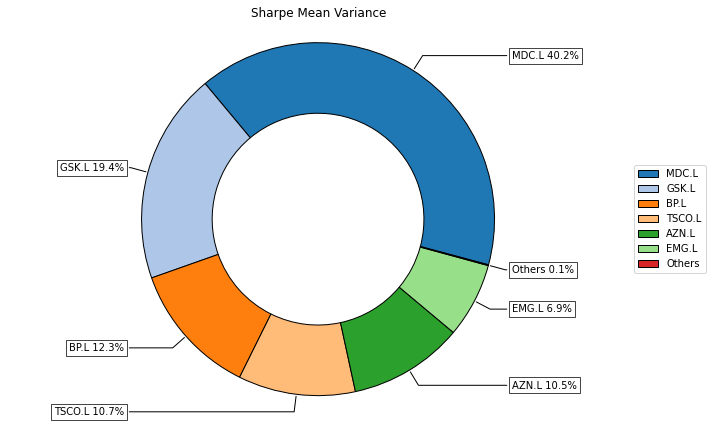

In [41]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

In [42]:
points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

AZN.L  BLND.L    BP.L   CNA.L   CTEC.L   EMG.L   EZJ.L    GSK.L  HMSO.L  \
0 1.8517% 0.0000% 0.0000% 0.0000% 12.8209% 0.0000% 0.0000% 22.8324% 0.0000%   
1 0.0000% 0.0000% 0.0000% 2.1550%  0.0000% 0.0000% 0.0000%  0.0000% 0.0000%   
2 0.0000% 0.0000% 0.0000% 4.2019%  0.0000% 0.0000% 0.0000%  0.0000% 0.0000%   
3 0.0000% 0.0000% 0.0000% 6.2430%  0.0000% 0.0000% 0.0000%  0.0000% 0.0000%   
4 0.0000% 0.0000% 0.0000% 8.2826%  0.0000% 0.0000% 0.0000%  0.0000% 0.0000%   

   HSBA.L   IGG.L  LLOY.L    MDC.L   NEX.L    NG.L  OCDO.L    SN.L   TLW.L  \
0 0.0000% 7.3389% 0.0000%  7.8745% 0.0000% 0.0000% 0.0000% 0.0000% 3.9857%   
1 0.0000% 0.0000% 0.0000% 97.8450% 0.0000% 0.0000% 0.0000% 0.0000% 0.0000%   
2 0.0000% 0.0000% 0.0000% 95.7981% 0.0000% 0.0000% 0.0000% 0.0000% 0.0000%   
3 0.0000% 0.0000% 0.0000% 93.7570% 0.0000% 0.0000% 0.0000% 0.0000% 0.0000%   
4 0.0000% 0.0000% 0.0000% 91.7174% 0.0000% 0.0000% 0.0000% 0.0000% 0.0000%   

    TSCO.L    VOD.L  
0 26.4002% 16.8957%  
1  0.0000%  0.0000%  
2  0.0000%  0.0000%  
3  0.0000%  0.0000%  
4  0.0000%  0.0000%

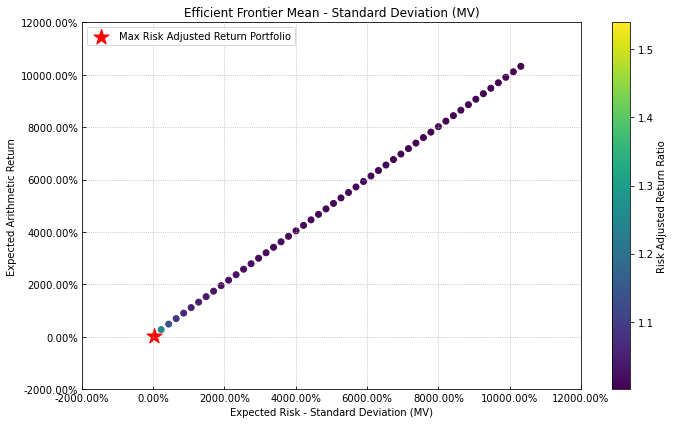

In [43]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

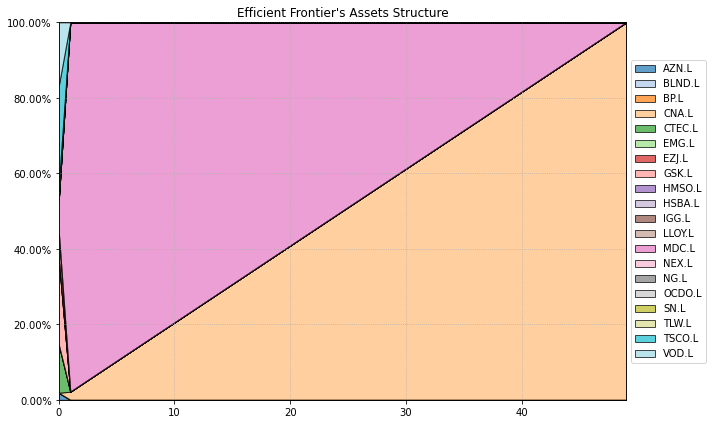

In [44]:
# Plotting efficient frontier composition

ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

In [45]:
rm = 'CVaR' # Risk measure

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

AZN.L  BLND.L    BP.L   CNA.L  CTEC.L   EMG.L   EZJ.L   GSK.L  \
weights 0.0000% 0.0000% 0.0000% 3.2539% 0.0000% 0.0000% 0.0000% 0.0000%   

         HMSO.L  HSBA.L   IGG.L  LLOY.L   MDC.L   NEX.L     NG.L  OCDO.L  \
weights 0.0000% 0.0000% 0.0000% 7.3431% 4.1116% 0.0000% 81.9798% 0.0000%   

           SN.L   TLW.L  TSCO.L   VOD.L  
weights 0.0000% 3.3116% 0.0000% 0.0000%

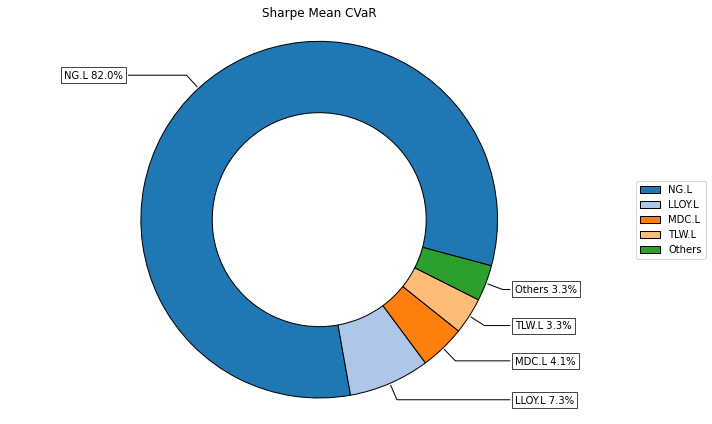

In [46]:
ax = rp.plot_pie(w=w, title='Sharpe Mean CVaR', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

In [47]:
points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

AZN.L  BLND.L    BP.L   CNA.L   CTEC.L   EMG.L   EZJ.L    GSK.L  HMSO.L  \
0 2.3472% 0.0000% 0.0000% 0.0000% 16.1525% 0.0000% 0.0000% 20.4454% 0.7213%   
1 0.6123% 0.0000% 0.0000% 0.0000% 15.2245% 0.0000% 0.0000% 14.7198% 3.6648%   
2 0.5716% 0.0000% 0.0000% 0.0000% 14.0132% 0.0000% 0.0000% 12.4627% 4.5756%   
3 0.9988% 0.0000% 0.0000% 0.0000% 13.1718% 0.0000% 0.0000% 10.1299% 4.7274%   
4 0.1816% 0.0000% 0.0000% 0.0000% 12.4102% 0.0000% 0.0000%  7.2780% 3.7838%   

   HSBA.L   IGG.L  LLOY.L    MDC.L   NEX.L     NG.L  OCDO.L    SN.L   TLW.L  \
0 0.0000% 0.0000% 0.0000% 16.1733% 0.0000%  1.1754% 0.9291% 0.0000% 0.0000%   
1 0.0000% 0.0000% 0.0000% 19.0602% 0.0000%  4.2819% 0.0000% 0.0000% 0.0000%   
2 0.0000% 0.0000% 0.0000% 19.3679% 0.0000%  7.2946% 0.0000% 0.0000% 0.0000%   
3 0.0000% 0.0000% 0.0000% 18.9106% 0.0000% 10.3003% 0.0000% 0.0000% 0.0000%   
4 0.0000% 0.0000% 0.0000% 18.6579% 0.0000% 13.2871% 0.0000% 0.0000% 1.2019%   

    TSCO.L    VOD.L  
0 30.9489% 11.1070%  
1 34.6516%  7.7849%  
2 34.8303%  6.8841%  
3 35.5208%  6.2404%  
4 36.9847%  6.2148%

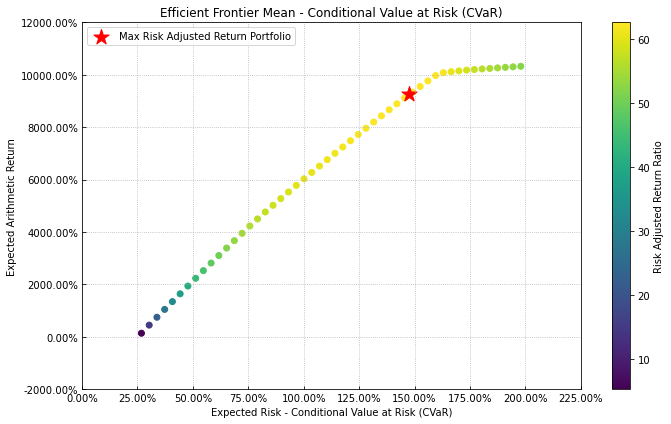

In [48]:
label = 'Max Risk Adjusted Return Portfolio' # Title of point

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

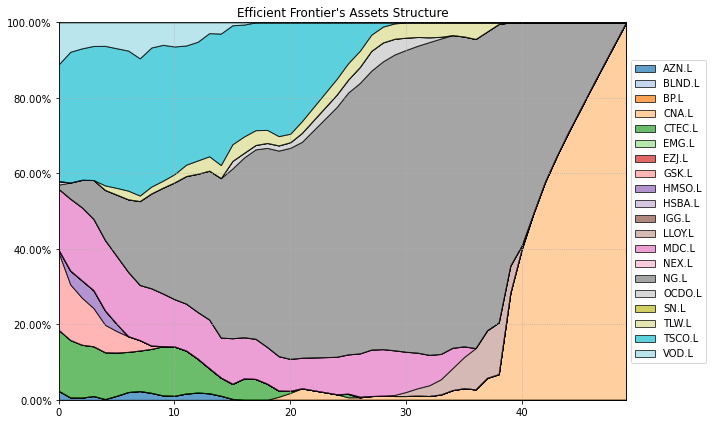

In [49]:
# Plotting efficient frontier composition

ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

In [50]:
# Risk Measures available:
#
# 'MV': Standard Deviation.

# 'CVaR': Conditional Value at Risk.


rms = ['MV', 'CVaR']

w_s = pd.DataFrame([])

for i in rms:
    w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms

In [51]:
w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

<AxesSubplot:>

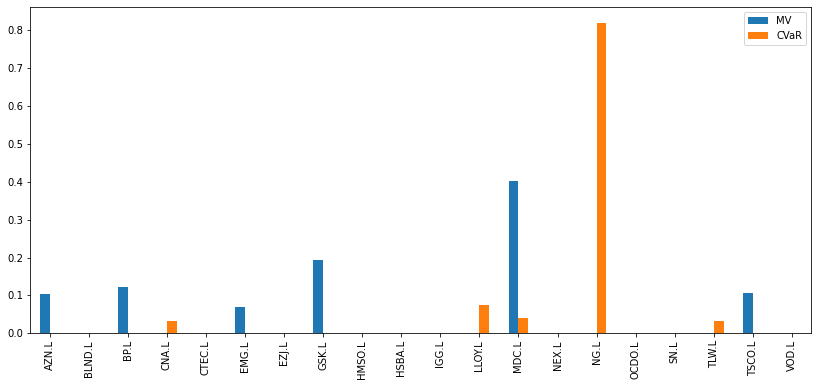

In [52]:
import matplotlib.pyplot as plt

# Plotting a comparison of assets weights for each portfolio

fig = plt.gcf()
fig.set_figwidth(14)
fig.set_figheight(6)
ax = fig.subplots(nrows=1, ncols=1)

w_s.plot.bar(ax=ax)

In [53]:
asset_classes = {'Assets': ['HMSO.L','BLND.L',"HSBA.L",'LLOY.L','EMG.L',
          'IGG.L','CNA.L','NG.L','CTEC.L','MDC.L',
          'SN.L','TSCO.L','OCDO.L','BP.L','TLW.L',
          'VOD.L','GSK.L','AZN.L','EZJ.L','NEX.L'], 
                 'Industry': ['Real Estate','Real Estate',
                              'Financial Services', 'Financial Services',
                              'Financial Services','Financial Services','Utilities',
                              'Utilities','Healthcare','Healthcare',
                              'Healthcare','Consumer Defensive','Consumer Defensive',
                              'Energy','Energy','Communication Services',
                              'Healthcare','Healthcare',
                              'Industrials','Industrials']}

asset_classes = pd.DataFrame(asset_classes)
asset_classes = asset_classes.sort_values(by=['Assets'])

constraints = {'Disabled': [False, False, False],
               'Type': ['All Assets', 'Classes', 'Classes'],
               'Set': ['', 'Industry', 'Industry'],
               'Position': ['', 'Financial Services', 'Healthcare'],
               'Sign': ['<=', '<=', '<='],
               'Weight': [0.1, 0.2, 0.25],
               'Type Relative': ['', '', ''],
               'Relative Set': ['', '', ''],
               'Relative': ['', '', ''],
               'Factor': ['', '', '']
               }

constraints = pd.DataFrame(constraints)

display(constraints)

Disabled        Type       Set            Position Sign   Weight  \
0     False  All Assets                                 <= 10.0000%   
1     False     Classes  Industry  Financial Services   <= 20.0000%   
2     False     Classes  Industry          Healthcare   <= 25.0000%   

  Type Relative Relative Set Relative Factor  
0                                             
1                                             
2

In [54]:
A, B = rp.assets_constraints(constraints, asset_classes)

In [55]:
port.ainequality = A
port.binequality = B

model = 'Classic'
rm = 'MV'
obj = 'Sharpe'
rf = 0

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

AZN.L   BLND.L     BP.L   CNA.L  CTEC.L    EMG.L   EZJ.L   GSK.L  \
weights 10.0000% 10.0000% 10.0000% 0.1110% 0.0000% 10.0000% 0.0000% 5.0000%   

         HMSO.L   HSBA.L   IGG.L  LLOY.L    MDC.L   NEX.L    NG.L  OCDO.L  \
weights 0.0000% 10.0000% 0.0000% 0.0000% 10.0000% 4.8889% 0.0000% 0.0000%   

           SN.L    TLW.L   TSCO.L    VOD.L  
weights 0.0000% 10.0000% 10.0000% 10.0000%

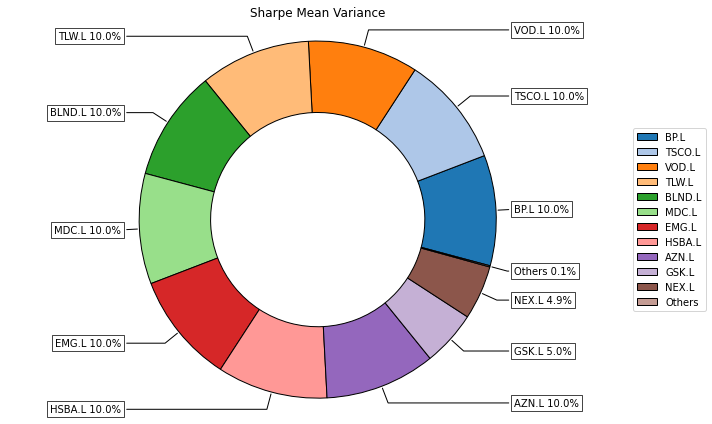

In [56]:
ax = rp.plot_pie(w=w, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

In [57]:
w_classes = pd.concat([asset_classes.set_index('Assets'), w], axis=1)

display(w_classes)

Industry  weights
AZN.L               Healthcare 10.0000%
BLND.L             Real Estate 10.0000%
BP.L                    Energy 10.0000%
CNA.L                Utilities  0.1110%
CTEC.L              Healthcare  0.0000%
EMG.L       Financial Services 10.0000%
EZJ.L              Industrials  0.0000%
GSK.L               Healthcare  5.0000%
HMSO.L             Real Estate  0.0000%
HSBA.L      Financial Services 10.0000%
IGG.L       Financial Services  0.0000%
LLOY.L      Financial Services  0.0000%
MDC.L               Healthcare 10.0000%
NEX.L              Industrials  4.8889%
NG.L                 Utilities  0.0000%
OCDO.L      Consumer Defensive  0.0000%
SN.L                Healthcare  0.0000%
TLW.L                   Energy 10.0000%
TSCO.L      Consumer Defensive 10.0000%
VOD.L   Communication Services 10.0000%

In [58]:
w_classes = w_classes.groupby(['Industry']).sum()

display(w_classes)

weights
Industry                       
Communication Services 10.0000%
Consumer Defensive     10.0000%
Energy                 20.0000%
Financial Services     20.0000%
Healthcare             25.0000%
Industrials             4.8889%
Real Estate            10.0000%
Utilities               0.1110%

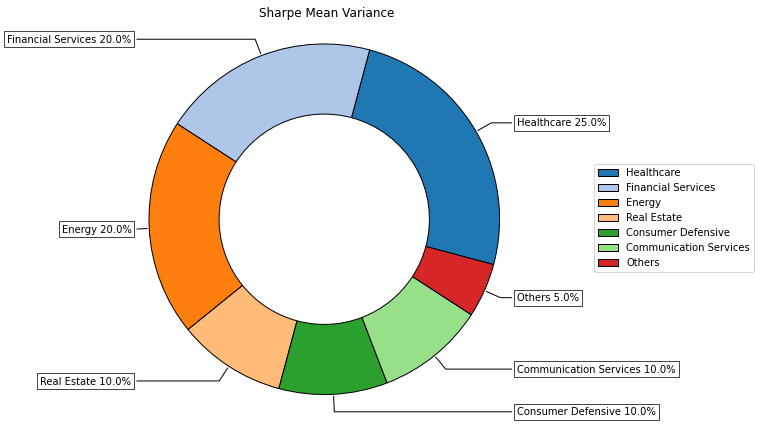

In [59]:
ax = rp.plot_pie(w=w_classes, title='Sharpe Mean Variance', others=0.05, nrow=25,
                 cmap = "tab20", height=6, width=10, ax=None)

In [60]:
#Calculate efficient frontier
points = 50# Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

AZN.L   BLND.L     BP.L   CNA.L  CTEC.L    EMG.L   EZJ.L    GSK.L  \
0  5.2126% 10.0000% 10.0000% 0.0000% 8.8697%  1.1384% 0.0000% 10.0000%   
1 10.0000% 10.0000% 10.0000% 0.7265% 0.0000% 10.0000% 0.0000%  5.0000%   
2 10.0000% 10.0000% 10.0000% 1.3343% 0.0000% 10.0000% 0.0000%  5.0000%   
3 10.0000% 10.0000% 10.0000% 1.9366% 0.0000% 10.0000% 0.0000%  5.0000%   
4 10.0000% 10.0000% 10.0000% 2.5373% 0.0000% 10.0000% 0.0000%  5.0000%   

   HMSO.L   HSBA.L    IGG.L  LLOY.L    MDC.L   NEX.L    NG.L  OCDO.L    SN.L  \
0 0.0000%  8.8616% 10.0000% 0.0000%  0.9176% 2.4182% 0.0000% 7.1446% 0.0000%   
1 0.0000% 10.0000%  0.0000% 0.0000% 10.0000% 4.2735% 0.0000% 0.0000% 0.0000%   
2 0.0000% 10.0000%  0.0000% 0.0000% 10.0000% 3.6657% 0.0000% 0.0000% 0.0000%   
3 0.0000% 10.0000%  0.0000% 0.0000% 10.0000% 3.0634% 0.0000% 0.0000% 0.0000%   
4 0.0000% 10.0000%  0.0000% 0.0000% 10.0000% 2.4627% 0.0000% 0.0000% 0.0000%   

     TLW.L   TSCO.L    VOD.L  
0  5.4372% 10.0000% 10.0000%  
1 10.0000% 10.0000% 10.0000%  
2 10.0000% 10.0000% 10.0000%  
3 10.0000% 10.0000% 10.0000%  
4 10.0000% 10.0000% 10.0000%

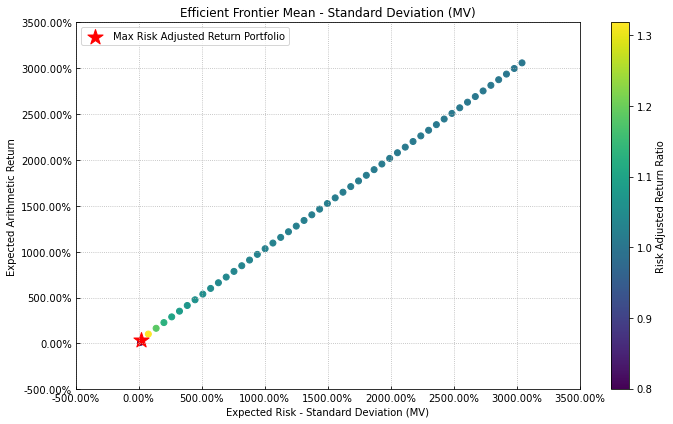

In [61]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

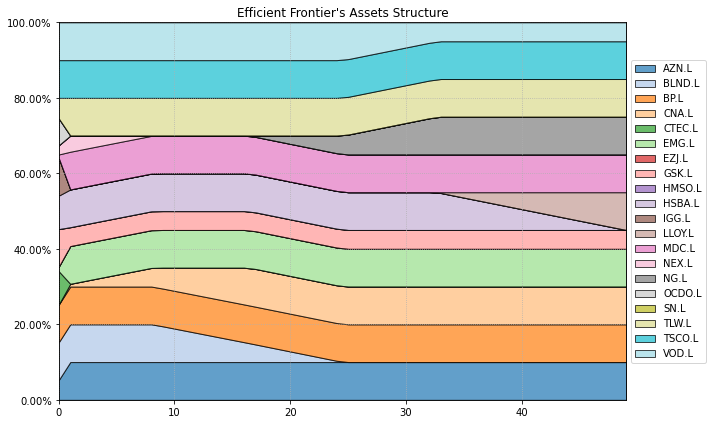

In [62]:
 #Plotting efficient frontier composition

ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

In [63]:
rm = 'CVaR' # Risk measure

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

AZN.L  BLND.L    BP.L    CNA.L  CTEC.L   EMG.L   EZJ.L    GSK.L  \
weights 5.0000% 9.0780% 0.0000% 10.0000% 0.0000% 0.0000% 0.0000% 10.0000%   

         HMSO.L  HSBA.L    IGG.L   LLOY.L    MDC.L   NEX.L     NG.L  OCDO.L  \
weights 2.5340% 0.0000% 10.0000% 10.0000% 10.0000% 0.0000% 10.0000% 3.3880%   

           SN.L   TLW.L   TSCO.L    VOD.L  
weights 0.0000% 0.0000% 10.0000% 10.0000%

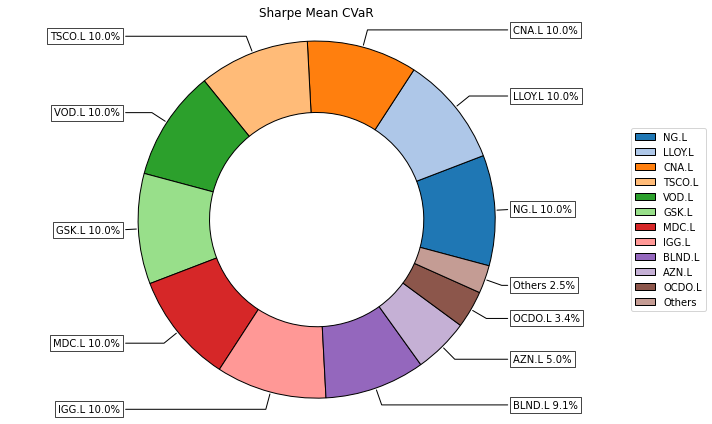

In [64]:
ax = rp.plot_pie(w=w, title='Sharpe Mean CVaR', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

In [65]:
w_classes = pd.concat([asset_classes.set_index('Assets'), w], axis=1)

display(w_classes)
w_classes = w_classes.groupby(['Industry']).sum()

display(w_classes)

Industry  weights
AZN.L               Healthcare  5.0000%
BLND.L             Real Estate  9.0780%
BP.L                    Energy  0.0000%
CNA.L                Utilities 10.0000%
CTEC.L              Healthcare  0.0000%
EMG.L       Financial Services  0.0000%
EZJ.L              Industrials  0.0000%
GSK.L               Healthcare 10.0000%
HMSO.L             Real Estate  2.5340%
HSBA.L      Financial Services  0.0000%
IGG.L       Financial Services 10.0000%
LLOY.L      Financial Services 10.0000%
MDC.L               Healthcare 10.0000%
NEX.L              Industrials  0.0000%
NG.L                 Utilities 10.0000%
OCDO.L      Consumer Defensive  3.3880%
SN.L                Healthcare  0.0000%
TLW.L                   Energy  0.0000%
TSCO.L      Consumer Defensive 10.0000%
VOD.L   Communication Services 10.0000%

weights
Industry                       
Communication Services 10.0000%
Consumer Defensive     13.3880%
Energy                  0.0000%
Financial Services     20.0000%
Healthcare             25.0000%
Industrials             0.0000%
Real Estate            11.6120%
Utilities              20.0000%

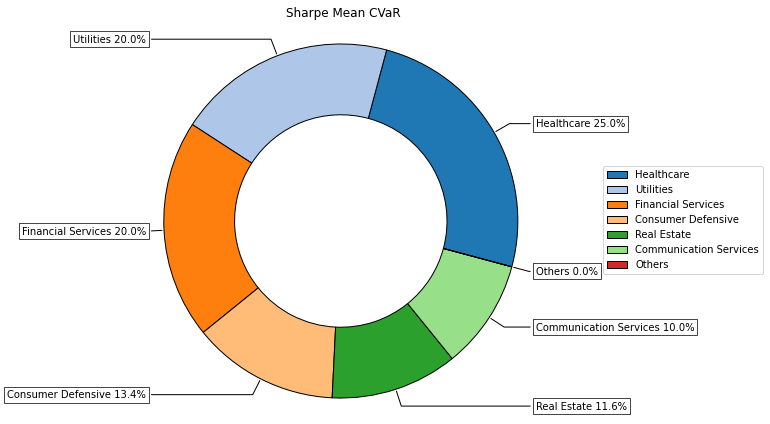

In [66]:
ax = rp.plot_pie(w=w_classes, title='Sharpe Mean CVaR', others=0.05, nrow=25,
                 cmap = "tab20", height=6, width=10, ax=None)

In [67]:
points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

AZN.L   BLND.L    BP.L   CNA.L  CTEC.L    EMG.L   EZJ.L    GSK.L  HMSO.L  \
0 9.0714%  9.1619% 8.6354% 0.0000% 1.2465% 10.0000% 0.0000% 10.0000% 3.3560%   
1 6.4675% 10.0000% 6.7831% 0.0000% 0.0000% 10.0000% 0.0000% 10.0000% 5.6367%   
2 5.3378% 10.0000% 5.9547% 0.0000% 0.0000% 10.0000% 0.0000% 10.0000% 6.0911%   
3 5.0000% 10.0000% 5.2699% 0.0000% 0.0000% 10.0000% 0.0000% 10.0000% 6.4872%   
4 5.0000% 10.0000% 4.8315% 0.0000% 0.0000%  9.5207% 0.0000% 10.0000% 6.2171%   

   HSBA.L    IGG.L  LLOY.L    MDC.L   NEX.L    NG.L  OCDO.L    SN.L   TLW.L  \
0 0.0000% 10.0000% 0.0000%  4.6821% 3.8503% 0.6278% 9.3686% 0.0000% 0.0000%   
1 0.0000% 10.0000% 0.0000%  8.5325% 3.5597% 1.8686% 7.1520% 0.0000% 0.0000%   
2 0.0000% 10.0000% 0.0000%  9.6622% 3.3895% 2.8859% 6.6788% 0.0000% 0.0000%   
3 0.0000% 10.0000% 0.0000% 10.0000% 3.3803% 3.8797% 5.9829% 0.0000% 0.0000%   
4 0.4793% 10.0000% 0.0000% 10.0000% 3.0873% 4.8251% 6.0391% 0.0000% 0.0000%   

    TSCO.L    VOD.L  
0 10.0000% 10.0000%  
1 10.0000% 10.0000%  
2 10.0000% 10.0000%  
3 10.0000% 10.0000%  
4 10.0000% 10.0000%

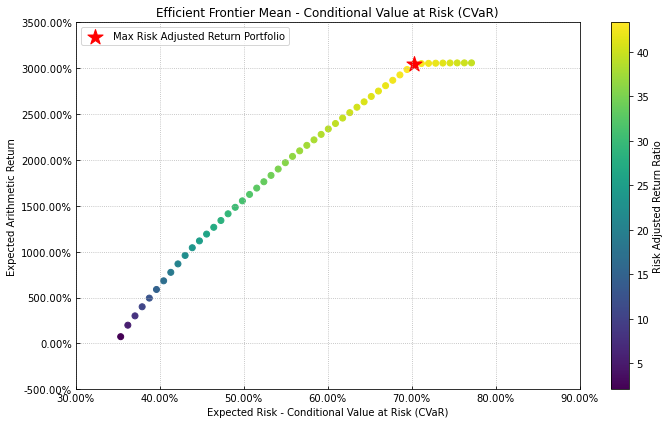

In [68]:
label = 'Max Risk Adjusted Return Portfolio' # Title of point

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

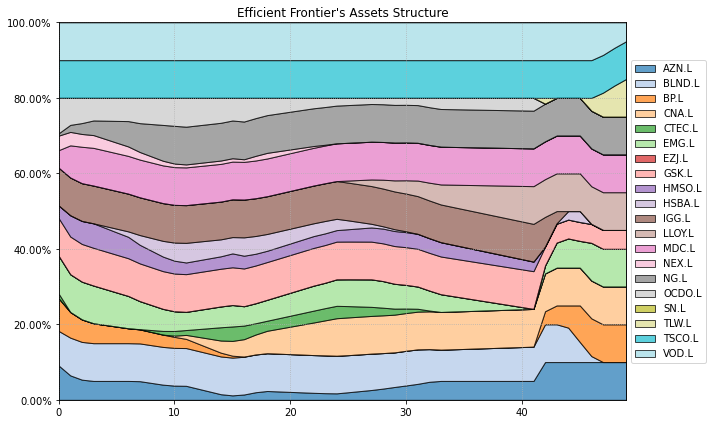

In [69]:
# Plotting efficient frontier composition

ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

In [70]:
# Risk Measures available:
#
# 'MV': Standard Deviation.

# 'CVaR': Conditional Value at Risk.


rms = ['MV', 'CVaR']

w_s = pd.DataFrame([])

for i in rms:
    w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms

In [71]:
w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

<AxesSubplot:>

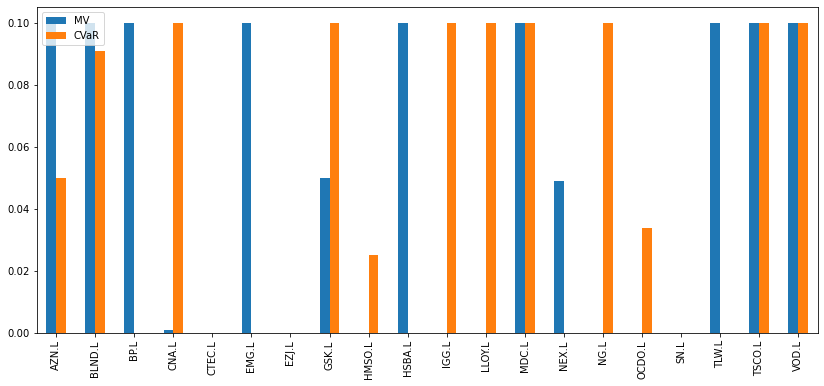

In [72]:
import matplotlib.pyplot as plt

# Plotting a comparison of assets weights for each portfolio

fig = plt.gcf()
fig.set_figwidth(14)
fig.set_figheight(6)
ax = fig.subplots(nrows=1, ncols=1)

w_s.plot.bar(ax=ax)

## Before Covid-19

In [544]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2019-01-01'
end = '2019-12-31'

# Tickers of assets
assets = ['HMSO.L','BLND.L',"HSBA.L",'LLOY.L','EMG.L',
          'IGG.L','CNA.L','NG.L','CTEC.L','MDC.L',
          'SN.L','TSCO.L','OCDO.L','BP.L','TLW.L',
          'VOD.L','GSK.L','AZN.L','EZJ.L','NEX.L']
assets.sort()

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

[*********************100%***********************]  20 of 20 completed


In [545]:
# Calculating returns

Y = data[assets].pct_change().dropna()

display(Y.head())

AZN.L   BLND.L     BP.L    CNA.L   CTEC.L    EMG.L    EZJ.L  \
Date                                                                        
2019-01-03  1.8126%  0.1820%  0.2760%  0.9559% -0.6988% -2.0758% -1.4519%   
2019-01-04  1.3145%  1.5296%  2.3786%  0.0000%  3.7037%  4.0907%  1.9337%   
2019-01-07 -1.3795%  0.3013%  0.0000% -4.4064%  1.2500%  0.9289% -0.6323%   
2019-01-08 -1.7818%  2.6662% -0.1920%  0.0000% -1.1287%  0.0000%  4.3182%   
2019-01-09  0.2035% -0.6950%  0.5964% -0.4191%  1.5341% -3.3274%  0.1743%   

              GSK.L  HMSO.L   HSBA.L   IGG.L  LLOY.L    MDC.L   NEX.L  \
Date                                                                    
2019-01-03  0.4399% 1.0546% -0.8042% 1.1285% 0.3922% -3.4504% 0.1617%   
2019-01-04  0.7697% 0.7673%  2.3542% 2.2318% 3.1250% -0.1967% 0.8611%   
2019-01-07 -0.2766% 0.7920% -2.1935% 2.8547% 1.0417%  3.1538% 0.3735%   
2019-01-08  0.3170% 3.0825%  1.0902% 0.4082% 0.6561%  1.7834% 0.3721%   
2019-01-09  1.1716% 0.2639% -0.4622% 0.8943% 0.2049%  5.3504% 1.2712%   

               NG.L   OCDO.L     SN.L    TLW.L   TSCO.L    VOD.L  
Date                                                              
2019-01-03  0.0776% -2.4180% -2.3093% -0.4363%  4.0720%  0.7229%  
2019-01-04  1.1754%  3.2617%  2.6146%  6.9296% -0.9782%  1.2303%  
2019-01-07 -0.5617%  2.4731% -0.8726%  1.8443%  2.5836% -0.3671%  
2019-01-08  0.6676%  2.7479% -0.7395%  0.1258%  2.7655% -1.1436%  
2019-01-09  0.7270%  1.8837%  1.0997%  0.9294%  1.7780% -1.7995%

In [546]:
#Calculating the portfolio that maximizes Sharpe ratio.
import riskfolio as rp

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

AZN.L  BLND.L    BP.L   CNA.L  CTEC.L   EMG.L   EZJ.L    GSK.L  \
weights 7.1663% 0.2111% 0.0000% 0.0000% 6.7146% 0.0000% 2.7765% 16.6535%   

         HMSO.L  HSBA.L   IGG.L  LLOY.L   MDC.L    NEX.L     NG.L  OCDO.L  \
weights 0.0000% 0.0000% 4.5515% 0.0000% 3.0499% 17.3355% 18.7401% 6.0489%   

           SN.L   TLW.L   TSCO.L   VOD.L  
weights 5.5492% 0.0000% 11.2028% 0.0000%

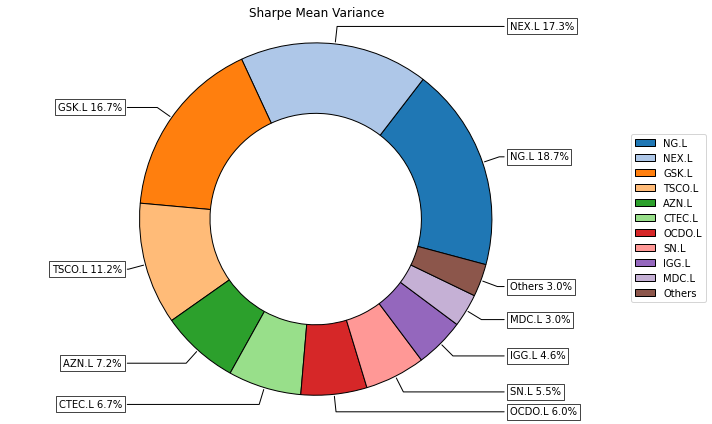

In [547]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

AZN.L  BLND.L    BP.L   CNA.L   CTEC.L   EMG.L   EZJ.L   GSK.L  \
weights 12.7207% 0.0000% 0.0000% 0.0000% 10.0888% 0.0000% 4.8394% 0.0000%   

         HMSO.L  HSBA.L   IGG.L   LLOY.L   MDC.L    NEX.L     NG.L  OCDO.L  \
weights 0.0000% 0.0000% 7.9161% 16.5659% 0.0000% 18.2873% 23.4396% 3.4271%   

           SN.L   TLW.L  TSCO.L   VOD.L  
weights 2.7150% 0.0000% 0.0000% 0.0000%

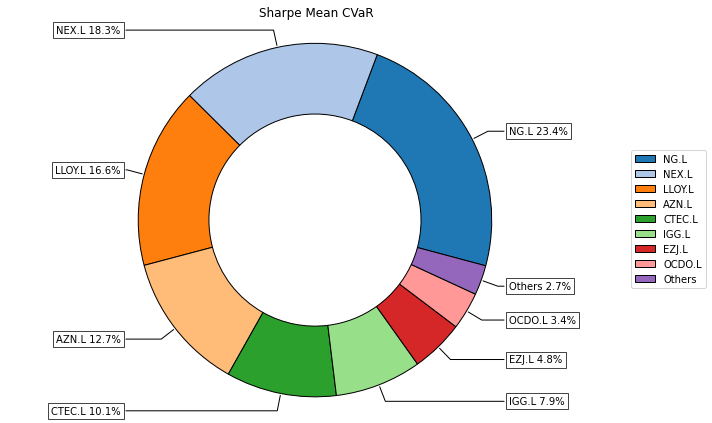

In [548]:
rm = 'CVaR' # Risk measure

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

ax = rp.plot_pie(w=w, title='Sharpe Mean CVaR', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

In [549]:
asset_classes = {'Assets': ['HMSO.L','BLND.L',"HSBA.L",'LLOY.L','EMG.L',
          'IGG.L','CNA.L','NG.L','CTEC.L','MDC.L',
          'SN.L','TSCO.L','OCDO.L','BP.L','TLW.L',
          'VOD.L','GSK.L','AZN.L','EZJ.L','NEX.L'], 
                 'Industry': ['Real Estate','Real Estate',
                              'Financial Services', 'Financial Services',
                              'Financial Services','Financial Services','Utilities',
                              'Utilities','Healthcare','Healthcare',
                              'Healthcare','Consumer Defensive','Consumer Defensive',
                              'Energy','Energy','Communication Services',
                              'Healthcare','Healthcare',
                              'Industrials','Industrials']}

asset_classes = pd.DataFrame(asset_classes)
asset_classes = asset_classes.sort_values(by=['Assets'])

constraints = {'Disabled': [False, False, False],
               'Type': ['All Assets', 'Classes', 'Classes'],
               'Set': ['', 'Industry', 'Industry'],
               'Position': ['', 'Financial Services', 'Healthcare'],
               'Sign': ['<=', '<=', '<='],
               'Weight': [0.1, 0.2, 0.25],
               'Type Relative': ['', '', ''],
               'Relative Set': ['', '', ''],
               'Relative': ['', '', ''],
               'Factor': ['', '', '']
               }

constraints = pd.DataFrame(constraints)

display(constraints)

Disabled        Type       Set            Position Sign   Weight  \
0     False  All Assets                                 <= 10.0000%   
1     False     Classes  Industry  Financial Services   <= 20.0000%   
2     False     Classes  Industry          Healthcare   <= 25.0000%   

  Type Relative Relative Set Relative Factor  
0                                             
1                                             
2

In [550]:
A, B = rp.assets_constraints(constraints, asset_classes)

In [551]:
port.ainequality = A
port.binequality = B

model = 'Classic'
rm = 'MV'
obj = 'Sharpe'
rf = 0

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

AZN.L   BLND.L    BP.L   CNA.L  CTEC.L   EMG.L   EZJ.L   GSK.L  \
weights 9.9999% 10.0000% 0.5325% 0.0000% 5.4349% 7.3510% 4.6799% 4.0084%   

         HMSO.L  HSBA.L    IGG.L  LLOY.L   MDC.L    NEX.L     NG.L   OCDO.L  \
weights 0.0000% 0.0000% 10.0000% 2.4367% 0.0000% 10.0000% 10.0000% 10.0000%   

           SN.L   TLW.L   TSCO.L   VOD.L  
weights 5.5568% 0.0000% 10.0000% 0.0000%

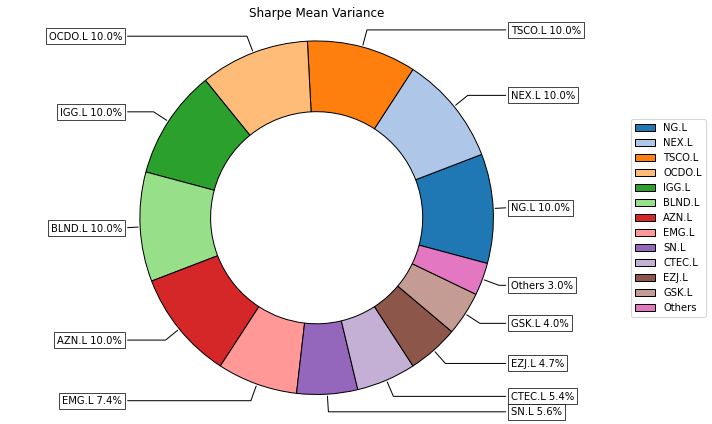

In [552]:
ax = rp.plot_pie(w=w, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

Industry  weights
AZN.L               Healthcare  9.9999%
BLND.L             Real Estate 10.0000%
BP.L                    Energy  0.5325%
CNA.L                Utilities  0.0000%
CTEC.L              Healthcare  5.4349%
EMG.L       Financial Services  7.3510%
EZJ.L              Industrials  4.6799%
GSK.L               Healthcare  4.0084%
HMSO.L             Real Estate  0.0000%
HSBA.L      Financial Services  0.0000%
IGG.L       Financial Services 10.0000%
LLOY.L      Financial Services  2.4367%
MDC.L               Healthcare  0.0000%
NEX.L              Industrials 10.0000%
NG.L                 Utilities 10.0000%
OCDO.L      Consumer Defensive 10.0000%
SN.L                Healthcare  5.5568%
TLW.L                   Energy  0.0000%
TSCO.L      Consumer Defensive 10.0000%
VOD.L   Communication Services  0.0000%

weights
Industry                       
Communication Services  0.0000%
Consumer Defensive     20.0000%
Energy                  0.5325%
Financial Services     19.7876%
Healthcare             25.0000%
Industrials            14.6799%
Real Estate            10.0000%
Utilities              10.0000%

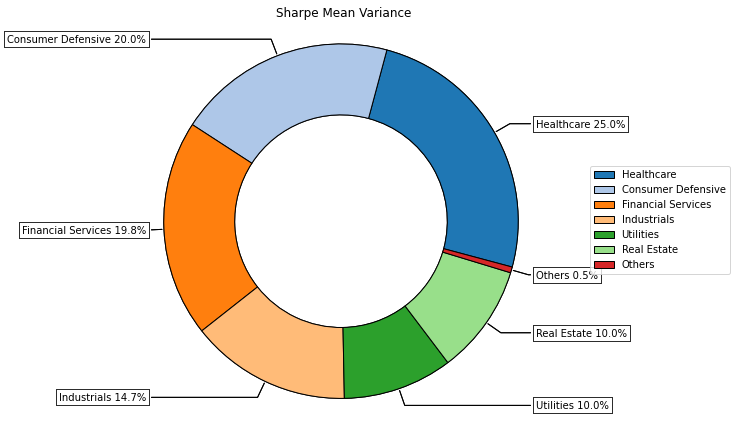

In [554]:
w_classes = pd.concat([asset_classes.set_index('Assets'), w], axis=1)

display(w_classes)
w_classes = w_classes.groupby(['Industry']).sum()

display(w_classes)
ax = rp.plot_pie(w=w_classes, title='Sharpe Mean CVaR', others=0.05, nrow=25,
                 cmap = "tab20", height=6, width=10, ax=None)
ax = rp.plot_pie(w=w_classes, title='Sharpe Mean Variance', others=0.05, nrow=25,
                 cmap = "tab20", height=6, width=10, ax=None)

In [555]:
#Calculate efficient frontier
points = 50# Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

AZN.L   BLND.L     BP.L   CNA.L  CTEC.L   EMG.L   EZJ.L    GSK.L  HMSO.L  \
0 4.3493% 10.0000% 10.0000% 1.0735% 1.4239% 1.0780% 1.7960% 10.0000% 0.0000%   
1 4.7815% 10.0000% 10.0000% 0.0000% 1.9647% 1.7820% 2.4586% 10.0000% 0.0000%   
2 4.9678% 10.0000% 10.0000% 0.0000% 2.1706% 2.4241% 2.7231% 10.0000% 0.0000%   
3 5.1146% 10.0000% 10.0000% 0.0000% 2.3330% 2.9309% 2.9320% 10.0000% 0.0000%   
4 5.2407% 10.0000% 10.0000% 0.0000% 2.4720% 3.3652% 3.1107% 10.0000% 0.0000%   

    HSBA.L   IGG.L  LLOY.L   MDC.L    NEX.L     NG.L  OCDO.L    SN.L   TLW.L  \
0 10.0000% 2.6613% 0.0000% 0.0000% 10.0000% 10.0000% 0.4416% 9.2268% 0.1618%   
1  8.0021% 4.1527% 0.0000% 0.0000% 10.0000% 10.0000% 2.3626% 8.2538% 0.0000%   
2  5.8227% 4.9225% 0.0000% 0.0000% 10.0000% 10.0000% 3.1686% 7.8616% 0.0000%   
3  4.1020% 5.5303% 0.0000% 0.0000% 10.0000% 10.0000% 3.8047% 7.5524% 0.0000%   
4  2.6281% 6.0506% 0.0000% 0.0000% 10.0000% 10.0000% 4.3494% 7.2873% 0.0000%   

    TSCO.L   VOD.L  
0  9.5925% 8.1953%  
1 10.0000% 6.2420%  
2 10.0000% 5.9389%  
3 10.0000% 5.7000%  
4 10.0000% 5.4959%

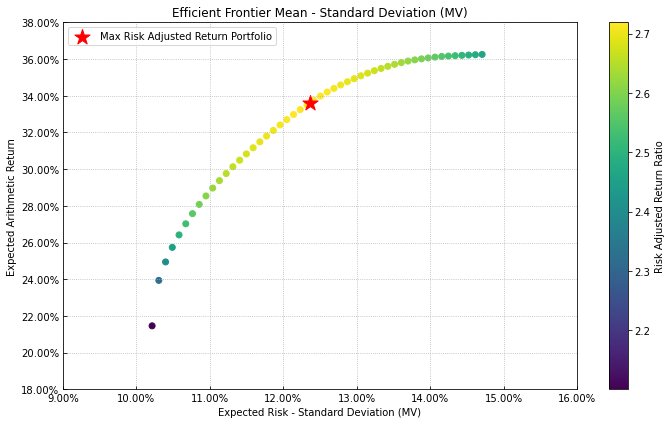

In [556]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

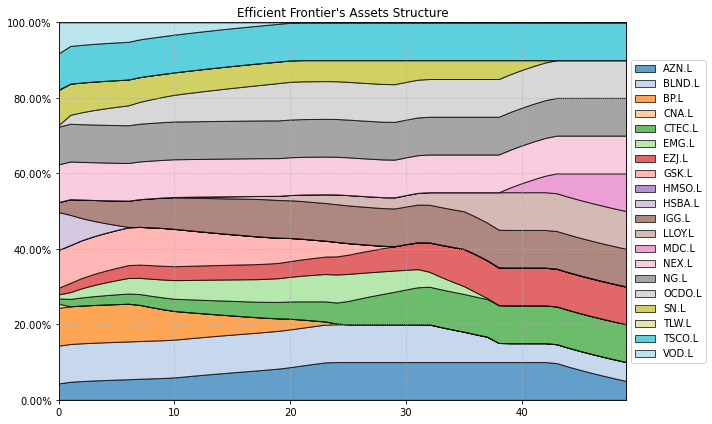

In [557]:
#Plotting efficient frontier composition

ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

In [558]:
rm = 'CVaR' # Risk measure

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

AZN.L  BLND.L    BP.L   CNA.L  CTEC.L   EMG.L   EZJ.L   GSK.L  \
weights 7.9047% 9.3353% 0.0000% 0.0000% 7.4345% 0.0000% 6.3811% 0.0000%   

         HMSO.L  HSBA.L    IGG.L   LLOY.L   MDC.L    NEX.L     NG.L  OCDO.L  \
weights 0.0000% 0.0000% 10.0000% 10.0000% 0.0000% 10.0000% 10.0000% 9.2835%   

           SN.L   TLW.L   TSCO.L   VOD.L  
weights 9.6608% 0.0000% 10.0000% 0.0000%

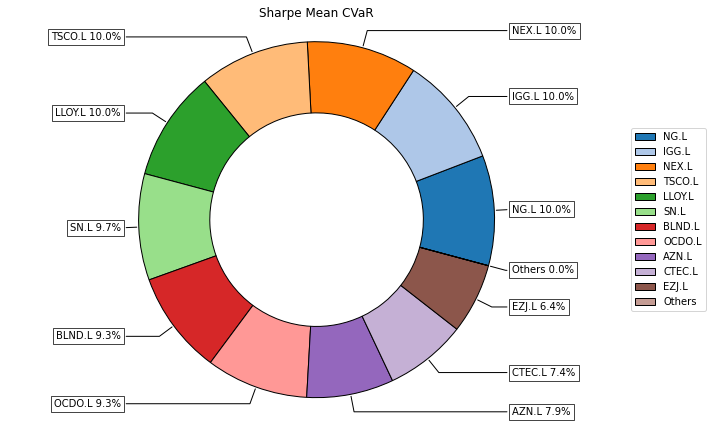

In [560]:
ax = rp.plot_pie(w=w, title='Sharpe Mean CVaR', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

Industry  weights
AZN.L               Healthcare 10.0000%
BLND.L             Real Estate 10.0000%
BP.L                    Energy 10.0000%
CNA.L                Utilities  0.1225%
CTEC.L              Healthcare 10.0000%
EMG.L       Financial Services 10.0000%
EZJ.L              Industrials  0.0000%
GSK.L               Healthcare  1.5142%
HMSO.L             Real Estate  0.0000%
HSBA.L      Financial Services  0.0000%
IGG.L       Financial Services  9.8762%
LLOY.L      Financial Services  0.1238%
MDC.L               Healthcare  3.4858%
NEX.L              Industrials  2.4019%
NG.L                 Utilities  0.1274%
OCDO.L      Consumer Defensive 10.0000%
SN.L                Healthcare  0.0000%
TLW.L                   Energy  2.3482%
TSCO.L      Consumer Defensive 10.0000%
VOD.L   Communication Services 10.0000%

weights
Industry                       
Communication Services 10.0000%
Consumer Defensive     20.0000%
Energy                 12.3482%
Financial Services     20.0000%
Healthcare             25.0000%
Industrials             2.4019%
Real Estate            10.0000%
Utilities               0.2499%

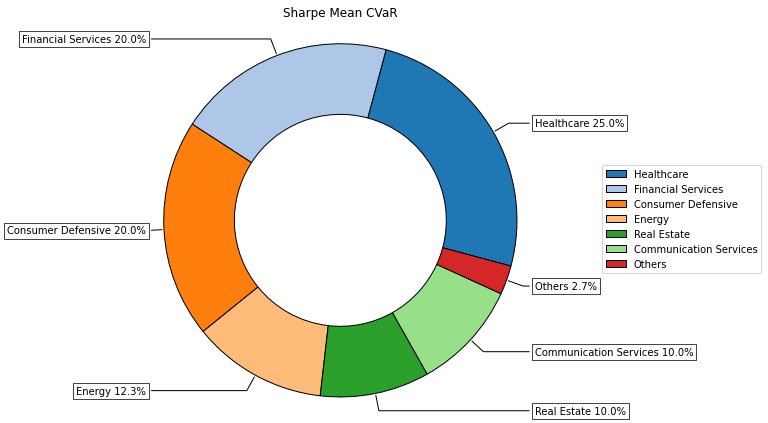

In [96]:
w_classes = pd.concat([asset_classes.set_index('Assets'), w], axis=1)

display(w_classes)
w_classes = w_classes.groupby(['Industry']).sum()

display(w_classes)
ax = rp.plot_pie(w=w_classes, title='Sharpe Mean CVaR', others=0.05, nrow=25,
                 cmap = "tab20", height=6, width=10, ax=None)

In [562]:
points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

AZN.L   BLND.L    BP.L   CNA.L  CTEC.L   EMG.L   EZJ.L    GSK.L  HMSO.L  \
0 8.3250% 10.0000% 1.4493% 1.5246% 4.4132% 0.0000% 2.8281% 10.0000% 0.0000%   
1 1.3341% 10.0000% 0.0000% 1.6148% 4.3946% 0.0000% 6.1198% 10.0000% 0.0000%   
2 2.8000% 10.0000% 0.0000% 0.1692% 3.8495% 0.0000% 5.7351% 10.0000% 0.0000%   
3 4.2479%  9.2148% 0.0000% 0.0000% 4.3881% 0.0000% 5.2029% 10.0000% 0.0000%   
4 4.5984%  8.7308% 0.0000% 0.0000% 5.1445% 0.0000% 4.8156% 10.0000% 0.0000%   

   HSBA.L    IGG.L  LLOY.L   MDC.L    NEX.L     NG.L  OCDO.L    SN.L   TLW.L  \
0 7.3171%  5.8761% 6.8068% 0.0000% 10.0000% 10.0000% 2.3431% 2.2618% 0.0000%   
1 1.3521% 10.0000% 3.9059% 0.0000% 10.0000% 10.0000% 3.9931% 9.2712% 0.0000%   
2 2.3160% 10.0000% 4.4206% 0.0000% 10.0000% 10.0000% 4.3586% 8.3506% 0.0000%   
3 2.6394% 10.0000% 5.6707% 0.0000% 10.0000% 10.0000% 5.0740% 6.3640% 0.0000%   
4 2.1143% 10.0000% 6.5506% 0.0000% 10.0000% 10.0000% 5.6485% 5.2572% 0.0000%   

    TSCO.L   VOD.L  
0  8.4643% 8.3905%  
1  9.5504% 8.4639%  
2 10.0000% 8.0006%  
3 10.0000% 7.1982%  
4 10.0000% 7.1402%

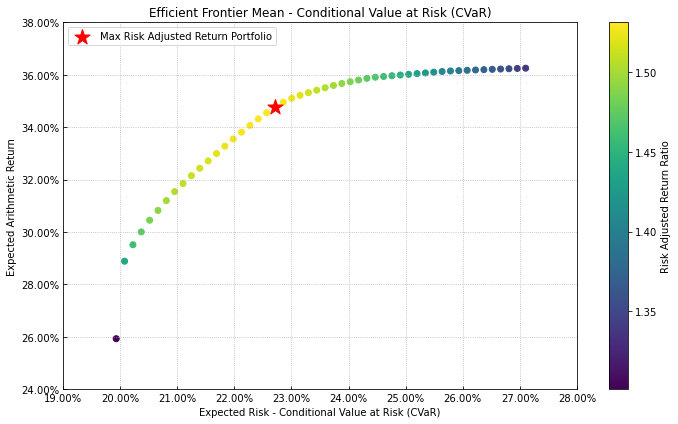

In [563]:
label = 'Max Risk Adjusted Return Portfolio' # Title of point

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

In [564]:
# Risk Measures available:
#
# 'MV': Standard Deviation.

# 'CVaR': Conditional Value at Risk.


rms = ['MV', 'CVaR']

w_s = pd.DataFrame([])

for i in rms:
    w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms

In [565]:
w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

<AxesSubplot:>

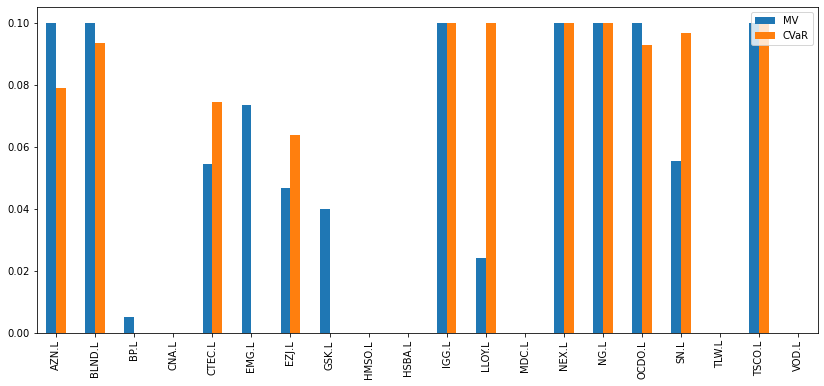

In [566]:
import matplotlib.pyplot as plt

# Plotting a comparison of assets weights for each portfolio

fig = plt.gcf()
fig.set_figwidth(14)
fig.set_figheight(6)
ax = fig.subplots(nrows=1, ncols=1)

w_s.plot.bar(ax=ax)

# Risk Factor Model With Principal Components Regression (PCR)

## Downloading the data

In [75]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2019-01-01'
end = '2022-07-31'

# Tickers of assets
assets = ['HMSO.L','BLND.L',"HSBA.L",'LLOY.L','EMG.L',
          'IGG.L','CNA.L','NG.L','CTEC.L','MDC.L',
          'SN.L','TSCO.L','OCDO.L','BP.L','TLW.L',
          'VOD.L','GSK.L','AZN.L','EZJ.L','NEX.L']
assets.sort()


# Tickers of factors

factors = ['MTUM', 'QUAL', 'VLUE', 'SIZE', 'USMV']
factors.sort()

tickers = assets + factors
tickers.sort()

# Downloading data
data = yf.download(tickers, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = tickers


[*********************100%***********************]  25 of 25 completed


In [76]:
# Calculating returns

X = data[factors].pct_change().dropna()
Y = data[assets].pct_change().dropna()

display(X.head())

MTUM     QUAL     SIZE     USMV     VLUE
Date                                                   
2019-01-03 -2.7621% -2.5156% -1.8567% -1.4632% -1.8958%
2019-01-04  3.3468%  3.5299%  3.4239%  2.1883%  3.5034%
2019-01-07  0.9595%  0.6070%  1.1980%  0.3251%  1.1552%
2019-01-08  1.2375%  1.0783%  1.0184%  0.8576%  0.6772%
2019-01-09  0.5867%  0.5588%  0.7686%  0.0189%  0.6595%

## Estimating Mean Variance Portfolios with PCR

### Estimating the loadings matrix with PCR

In [77]:
import riskfolio as rp

feature_selection = 'PCR' # Method to select best model, could be PCR or Stepwise
n_components = 0.95 # 95% of explained variance. See PCA in scikit learn for more information

loadings = rp.loadings_matrix(X=X, Y=Y, feature_selection=feature_selection,
                              n_components=n_components)

loadings.style.format("{:.4f}")

### Calculating the portfolio that maximizes Sharpe ratio

In [78]:
# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu,
                  method_cov=method_cov)

feature_selection = 'PCR' # Method to select best model, could be PCR or Stepwise
n_components = 0.95 # 95% of explained variance. See PCA in scikit learn for more information

port.factors = X
port.factors_stats(method_mu=method_mu,
                   method_cov=method_cov,
                   dict_risk=dict(feature_selection=feature_selection,
                                  n_components=n_components)
                  )

# Estimate optimal portfolio:

model='FM' # Factor Model
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = False # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

AZN.L  BLND.L    BP.L   CNA.L   CTEC.L    EMG.L   EZJ.L    GSK.L  \
weights 21.6306% 0.0000% 0.0000% 0.0732% 14.4307% 17.5401% 0.0000% 11.7829%   

         HMSO.L  HSBA.L    IGG.L  LLOY.L   MDC.L   NEX.L    NG.L  OCDO.L  \
weights 0.0000% 0.0000% 13.1353% 0.0748% 5.9948% 0.0000% 0.0760% 1.9100%   

           SN.L   TLW.L   TSCO.L   VOD.L  
weights 0.0000% 0.0000% 13.3515% 0.0000%

### Plotting portfolio composition

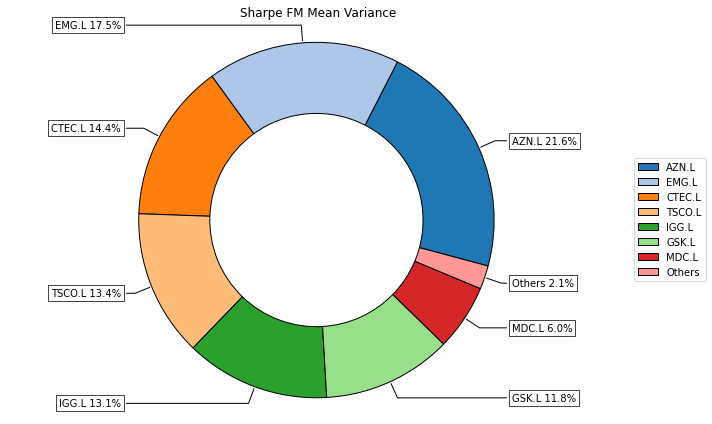

In [79]:
import riskfolio.PlotFunctions as plf

# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w, title='Sharpe FM Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

### Calculate efficient frontier

In [80]:
points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

AZN.L  BLND.L    BP.L   CNA.L  CTEC.L    EMG.L   EZJ.L    GSK.L  HMSO.L  \
0 12.9823% 2.3051% 0.0000% 0.0000% 9.6550%  5.1755% 0.0000% 19.6857% 0.0000%   
1 10.6303% 0.0000% 0.0000% 1.2530% 0.0000% 85.5365% 0.0000%  0.0000% 0.0000%   
2  0.0000% 0.0000% 0.0000% 2.4366% 0.0000% 92.5461% 0.0000%  0.0000% 0.0000%   
3  0.0000% 0.0000% 0.0000% 3.6148% 0.0000% 88.9419% 0.0000%  0.0000% 0.0000%   
4  0.0000% 0.0000% 0.0000% 4.7894% 0.0000% 85.3486% 0.0000%  0.0000% 0.0000%   

   HSBA.L   IGG.L  LLOY.L   MDC.L   NEX.L    NG.L  OCDO.L    SN.L   TLW.L  \
0 5.3034% 8.6493% 0.0000% 3.7645% 0.0000% 0.0000% 4.0588% 5.0882% 0.0000%   
1 0.0000% 0.0000% 1.2816% 0.0000% 0.0000% 1.2986% 0.0000% 0.0000% 0.0000%   
2 0.0000% 0.0000% 2.4924% 0.0000% 0.0000% 2.5249% 0.0000% 0.0000% 0.0000%   
3 0.0000% 0.0000% 3.6977% 0.0000% 0.0000% 3.7457% 0.0000% 0.0000% 0.0000%   
4 0.0000% 0.0000% 4.8993% 0.0000% 0.0000% 4.9627% 0.0000% 0.0000% 0.0000%   

    TSCO.L   VOD.L  
0 17.9182% 5.4140%  
1  0.0000% 0.0000%  
2  0.0000% 0.0000%  
3  0.0000% 0.0000%  
4  0.0000% 0.0000%

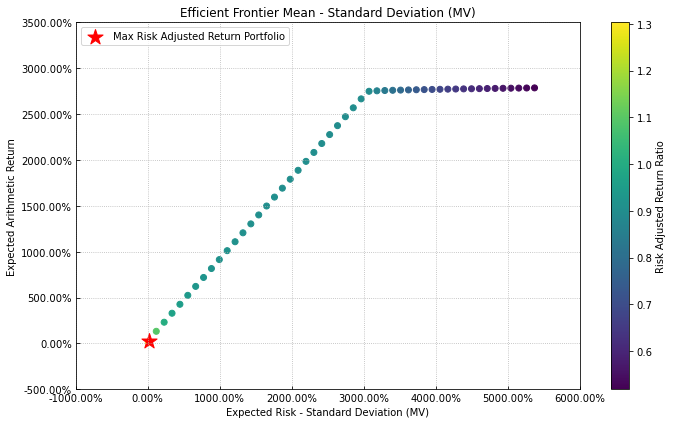

In [81]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu_fm # Expected returns
cov = port.cov_fm # Covariance matrix
returns = port.returns_fm # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.01, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

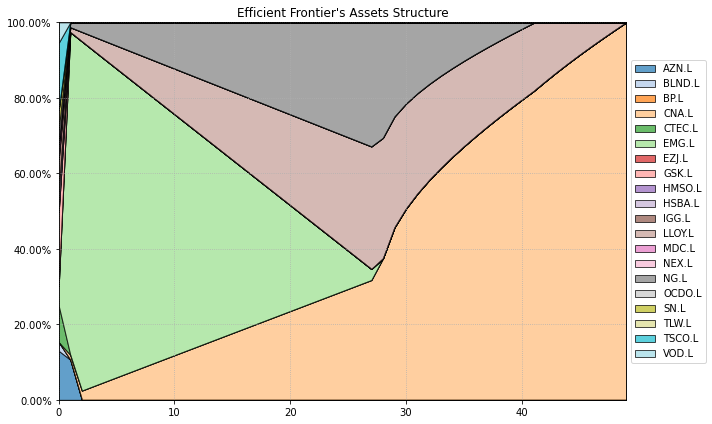

In [82]:

# Plotting efficient frontier composition

ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

## Estimating CVaR Portfolios with PCR

In [83]:
# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu,
                  method_cov=method_cov)

feature_selection = 'PCR' # Method to select best model, could be PCR or Stepwise
n_components = 0.95 # 95% of explained variance. See PCA in scikit learn for more information

port.factors = X
port.factors_stats(method_mu=method_mu,
                   method_cov=method_cov,
                   dict_risk=dict(feature_selection=feature_selection,
                                  n_components=n_components)
                  )

# Estimate optimal portfolio:

model='FM' # Factor Model
rm = 'CVaR' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = False # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

AZN.L  BLND.L    BP.L   CNA.L  CTEC.L   EMG.L   EZJ.L   GSK.L  \
weights 0.0000% 0.0000% 0.0000% 0.0000% 0.0000% 0.0000% 0.0000% 0.0000%   

         HMSO.L  HSBA.L   IGG.L  LLOY.L   MDC.L   NEX.L     NG.L   OCDO.L  \
weights 0.0000% 0.0000% 0.0000% 0.0000% 0.0000% 0.0000% 16.1367% 83.8633%   

           SN.L   TLW.L  TSCO.L   VOD.L  
weights 0.0000% 0.0000% 0.0000% 0.0000%

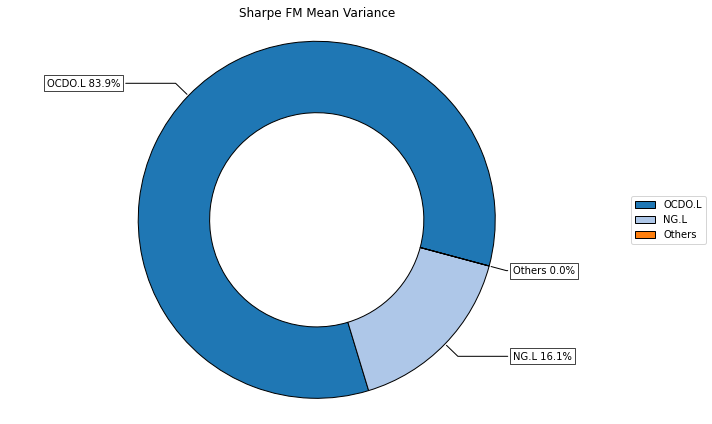

In [84]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w, title='Sharpe FM Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

## Constraints on Assets and Assets Classes

In [85]:
# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu,
                  method_cov=method_cov)

feature_selection = 'PCR' # Method to select best model, could be PCR or Stepwise
n_components = 0.95 # 95% of explained variance. See PCA in scikit learn for more information

port.factors = X
port.factors_stats(method_mu=method_mu,
                   method_cov=method_cov,
                   dict_risk=dict(feature_selection=feature_selection,
                                  n_components=n_components)
                  )



In [86]:
port.factors

MTUM     QUAL     SIZE     USMV     VLUE
Date                                                   
2019-01-03 -2.7621% -2.5156% -1.8567% -1.4632% -1.8958%
2019-01-04  3.3468%  3.5299%  3.4239%  2.1883%  3.5034%
2019-01-07  0.9595%  0.6070%  1.1980%  0.3251%  1.1552%
2019-01-08  1.2375%  1.0783%  1.0184%  0.8576%  0.6772%
2019-01-09  0.5867%  0.5588%  0.7686%  0.0189%  0.6595%
...             ...      ...      ...      ...      ...
2022-07-25  1.2579% -0.1530%  0.1646% -0.0697%  0.4505%
2022-07-26 -0.1939% -1.3702% -1.2282% -0.1814% -0.7368%
2022-07-27  1.1296%  2.5455%  2.2767%  1.2025%  1.8180%
2022-07-28  0.8466%  1.5904%  1.4812%  1.4092%  0.8663%
2022-07-29  1.1781%  1.0685%  0.9533%  0.5586%  0.3666%

[921 rows x 5 columns]

In [87]:
asset_classes = {'Assets': ['HMSO.L','BLND.L',"HSBA.L",'LLOY.L','EMG.L',
          'IGG.L','CNA.L','NG.L','CTEC.L','MDC.L',
          'SN.L','TSCO.L','OCDO.L','BP.L','TLW.L',
          'VOD.L','GSK.L','AZN.L','EZJ.L','NEX.L'], 
                 'Industry': ['Real Estate','Real Estate',
                              'Financial Services', 'Financial Services',
                              'Financial Services','Financial Services','Utilities',
                              'Utilities','Healthcare','Healthcare',
                              'Healthcare','Consumer Defensive','Consumer Defensive',
                              'Energy','Energy','Communication Services',
                              'Healthcare','Healthcare',
                              'Industrials','Industrials']}

asset_classes = pd.DataFrame(asset_classes)
asset_classes = asset_classes.sort_values(by=['Assets'])

constraints = {'Disabled': [False, False, False],
               'Type': ['All Assets', 'Classes', 'Classes'],
               'Set': ['', 'Industry', 'Industry'],
               'Position': ['', 'Financial Services', 'Healthcare'],
               'Sign': ['<=', '<=', '<='],
               'Weight': [0.1, 0.2, 0.25],
               'Type Relative': ['', '', ''],
               'Relative Set': ['', '', ''],
               'Relative': ['', '', ''],
               'Factor': ['', '', '']
               }

constraints = pd.DataFrame(constraints)

display(constraints)

Disabled        Type       Set            Position Sign   Weight  \
0     False  All Assets                                 <= 10.0000%   
1     False     Classes  Industry  Financial Services   <= 20.0000%   
2     False     Classes  Industry          Healthcare   <= 25.0000%   

  Type Relative Relative Set Relative Factor  
0                                             
1                                             
2

In [88]:
A, B = rp.assets_constraints(constraints, asset_classes)

In [89]:
port.ainequality = A
port.binequality = B


In [101]:
model = 'FM'
rm = 'MV'
obj = 'Sharpe'

rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'
w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

AZN.L   BLND.L     BP.L   CNA.L   CTEC.L    EMG.L   EZJ.L   GSK.L  \
weights 10.0000% 10.0000% 10.0000% 0.1225% 10.0000% 10.0000% 0.0000% 1.5142%   

         HMSO.L  HSBA.L   IGG.L  LLOY.L   MDC.L   NEX.L    NG.L   OCDO.L  \
weights 0.0000% 0.0000% 9.8762% 0.1238% 3.4858% 2.4019% 0.1274% 10.0000%   

           SN.L   TLW.L   TSCO.L    VOD.L  
weights 0.0000% 2.3482% 10.0000% 10.0000%

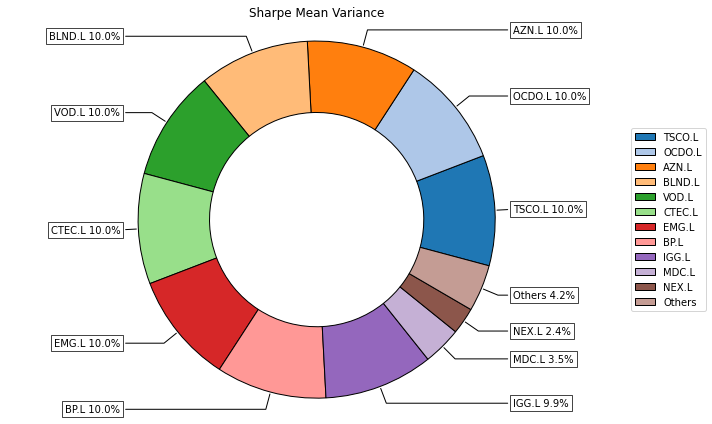

In [102]:
ax = rp.plot_pie(w=w, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

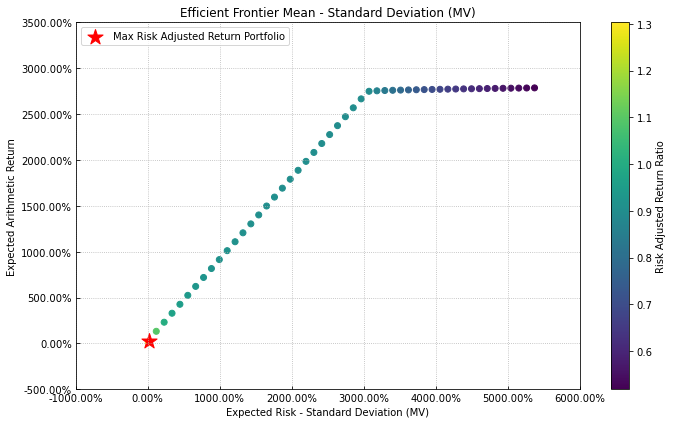

In [103]:
label = 'Max Risk Adjusted Return Portfolio' # Title of point

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

In [104]:
w_classes = pd.concat([asset_classes.set_index('Assets'), w], axis=1)

display(w_classes)

Industry  weights
AZN.L               Healthcare 10.0000%
BLND.L             Real Estate 10.0000%
BP.L                    Energy 10.0000%
CNA.L                Utilities  0.1225%
CTEC.L              Healthcare 10.0000%
EMG.L       Financial Services 10.0000%
EZJ.L              Industrials  0.0000%
GSK.L               Healthcare  1.5142%
HMSO.L             Real Estate  0.0000%
HSBA.L      Financial Services  0.0000%
IGG.L       Financial Services  9.8762%
LLOY.L      Financial Services  0.1238%
MDC.L               Healthcare  3.4858%
NEX.L              Industrials  2.4019%
NG.L                 Utilities  0.1274%
OCDO.L      Consumer Defensive 10.0000%
SN.L                Healthcare  0.0000%
TLW.L                   Energy  2.3482%
TSCO.L      Consumer Defensive 10.0000%
VOD.L   Communication Services 10.0000%

In [105]:
w_classes = w_classes.groupby(['Industry']).sum()

display(w_classes)

weights
Industry                       
Communication Services 10.0000%
Consumer Defensive     20.0000%
Energy                 12.3482%
Financial Services     20.0000%
Healthcare             25.0000%
Industrials             2.4019%
Real Estate            10.0000%
Utilities               0.2499%

weights
Industry                       
Communication Services 10.0000%
Consumer Defensive     20.0000%
Energy                 12.3482%
Financial Services     20.0000%
Healthcare             25.0000%
Industrials             2.4019%
Real Estate            10.0000%
Utilities               0.2499%

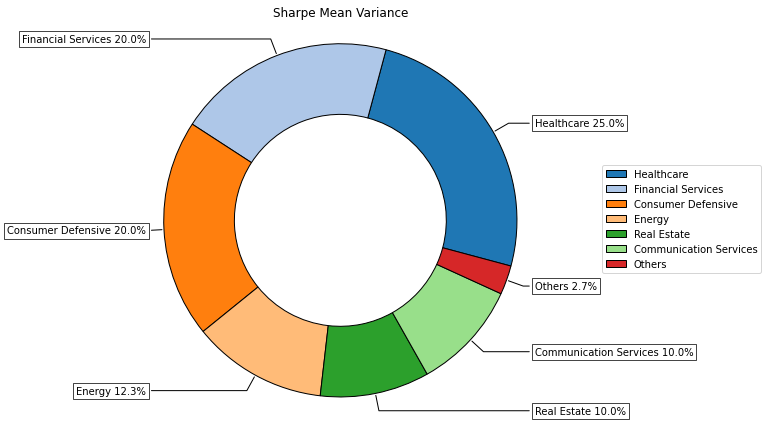

In [106]:
display(w_classes)
ax = rp.plot_pie(w=w_classes, title='Sharpe Mean Variance', others=0.05, nrow=25,
                 cmap = "tab20", height=6, width=10, ax=None)

AZN.L  BLND.L    BP.L    CNA.L   CTEC.L   EMG.L   EZJ.L   GSK.L  \
weights 10.0000% 5.0000% 0.0000% 10.0000% 10.0000% 0.0000% 0.0000% 5.0000%   

         HMSO.L  HSBA.L    IGG.L   LLOY.L   MDC.L   NEX.L     NG.L   OCDO.L  \
weights 0.0000% 0.0000% 10.0000% 10.0000% 0.0000% 0.0000% 10.0000% 10.0000%   

           SN.L   TLW.L   TSCO.L    VOD.L  
weights 0.0000% 0.0000% 10.0000% 10.0000%

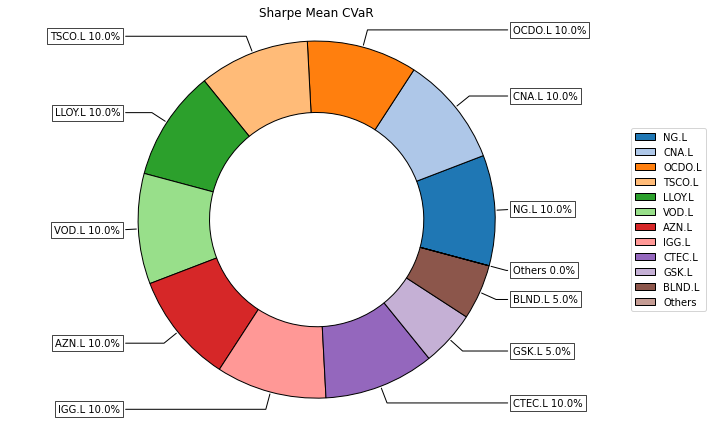

In [97]:
rm = 'CVaR' # Risk measure

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)
ax = rp.plot_pie(w=w, title='Sharpe Mean CVaR', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

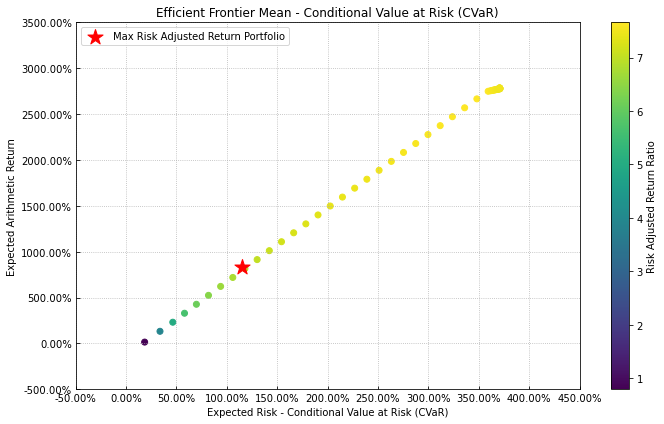

In [98]:

label = 'Max Risk Adjusted Return Portfolio' # Title of point

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

Industry  weights
AZN.L               Healthcare 10.0000%
BLND.L             Real Estate  5.0000%
BP.L                    Energy  0.0000%
CNA.L                Utilities 10.0000%
CTEC.L              Healthcare 10.0000%
EMG.L       Financial Services  0.0000%
EZJ.L              Industrials  0.0000%
GSK.L               Healthcare  5.0000%
HMSO.L             Real Estate  0.0000%
HSBA.L      Financial Services  0.0000%
IGG.L       Financial Services 10.0000%
LLOY.L      Financial Services 10.0000%
MDC.L               Healthcare  0.0000%
NEX.L              Industrials  0.0000%
NG.L                 Utilities 10.0000%
OCDO.L      Consumer Defensive 10.0000%
SN.L                Healthcare  0.0000%
TLW.L                   Energy  0.0000%
TSCO.L      Consumer Defensive 10.0000%
VOD.L   Communication Services 10.0000%

weights
Industry                       
Communication Services 10.0000%
Consumer Defensive     20.0000%
Energy                  0.0000%
Financial Services     20.0000%
Healthcare             25.0000%
Industrials             0.0000%
Real Estate             5.0000%
Utilities              20.0000%

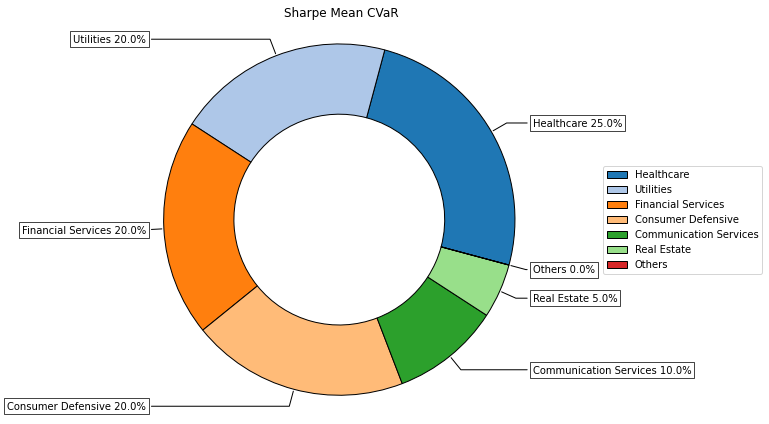

In [100]:
w_classes = pd.concat([asset_classes.set_index('Assets'), w], axis=1)

display(w_classes)
w_classes = w_classes.groupby(['Industry']).sum()

display(w_classes)
ax = rp.plot_pie(w=w_classes, title='Sharpe Mean CVaR', others=0.05, nrow=25,
                 cmap = "tab20", height=6, width=10, ax=None)

In [99]:
risk = ['MV', 'CVaR', 'MDD']
label = ['Std. Dev.', 'CVaR', 'Max Drawdown']
alpha = 0.05

for i in range(3):
    limits = port.frontier_limits(model=model, rm=risk[i], rf=rf, hist=hist)
    risk_min = rp.Sharpe_Risk(limits['w_min'], cov=cov, returns=returns, rm=risk[i], rf=rf, alpha=alpha)
    risk_max = rp.Sharpe_Risk(limits['w_max'], cov=cov, returns=returns, rm=risk[i], rf=rf, alpha=alpha)    

    if 'Drawdown' in label[i]:
        factor = 1    
    else:
        factor = 252**0.5

    print('\nMin Return ' + label[i] + ': ', (mu @ limits['w_min']).item() * 252)
    print('Max Return ' + label[i] + ': ',  (mu @ limits['w_max']).item() * 252)
    print('Min ' + label[i] + ': ', risk_min * factor)
    print('Max ' + label[i] + ': ', risk_max * factor)


Min Return Std. Dev.:  0.1283637717083108
Max Return Std. Dev.:  8.367645455711731
Min Std. Dev.:  0.1346975466063588
Max Std. Dev.:  9.175528290966957

Min Return CVaR:  0.14403976292065881
Max Return CVaR:  8.367645458763556
Min CVaR:  0.23802188725142615
Max CVaR:  1.2149211898964791

Min Return Max Drawdown:  0.20230894284885503
Max Return Max Drawdown:  8.367645458765267
Min Max Drawdown:  0.1807824433422509
Max Max Drawdown:  0.49170580669552066
